In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib 
from matplotlib import pyplot as plt
import gc
import multiprocessing as mp
from multiprocessing import Process, Queue
queue = Queue()
import random
from matplotlib.pyplot import figure
import math

In [2]:
def read_df(file_title,house_nb):
    try:
        df=pd.read_table(file_title, sep="," )
        df.columns = ["time","consumption"]
        try:
            df['time'] = pd.to_datetime(df['time'],unit='s')
        except:
            df['time'] = pd.to_datetime(df['time'])
        df.index= df.time
        df = df.sort_index()
        df.reset_index(drop=True, inplace=True)
        return (df,house_nb)
    except:
        return(None)

In [3]:
pool = mp.Pool(processes = 3)
result=pool.starmap(read_df,(("Refit_Resampled/fridge/house_"+str(i+1)+".csv",i+1) for i in range(21)))
Refit_fridges={}
for i in range(len(result)):
    if result[i]!=None:
        Refit_fridges[result[i][1]]=result[i][0]

In [6]:
def csv_to_activations(file_title):
    df=pd.read_table(file_title, sep="," )
    df = df[['beginning', 'end']]
    activation = [tuple(x) for x in df.to_numpy()]
    return(activation)

In [7]:
Refit_fridge_activations={}
for house_nb in Refit_fridges.keys():
    Refit_fridge_activations[house_nb]=csv_to_activations("Refit_activations/fridge/house_"+str(house_nb))
Refit_fridge_activations.keys()

dict_keys([1, 4, 7, 8, 11, 18, 20])

In [8]:
def add_margin(activation_list,df_length,margin=1):
  on_consumptions=[]
  for activation_tuple in activation_list:
    if ((activation_tuple[0]-margin)>=1):
      start=activation_tuple[0]-margin
    else:
      start=1
    if ((activation_tuple[1]+margin)<=df_length):
      end=activation_tuple[1]+margin
    else:
      end=df_length
    on_consumptions.append((start,end))
  return(on_consumptions)

In [9]:
Refit_fridge_activations_margin={}
for key in Refit_fridge_activations.keys():
    Refit_fridge_activations_margin[key]=add_margin(Refit_fridge_activations[key],len(Refit_fridges[key].index),2)
print(Refit_fridge_activations_margin[1][1])
print(Refit_fridge_activations[1][1])
Refit_fridge_activations=Refit_fridge_activations_margin

(1399, 1574)
(1401, 1572)


In [10]:
for key in Refit_fridge_activations.keys():
    activations=Refit_fridge_activations[key]
    Refit_fridge_activations[key]=[]
    for activation in activations:
        if (round((activation[1]-activation[0])/6)<=2000):
            Refit_fridge_activations[key].append(activation)

In [10]:
def get_activation_avg (df,activations,house_nb):
    averages=[]
    for activation in activations:
        start=activation[0]
        end=activation[1]
        avg=sum(df.consumption.iloc[start:end])/len(df.consumption.iloc[start:end])
        averages.append(avg)
    return(averages,house_nb)

In [11]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_activation_avg,((Refit_fridges[i],Refit_fridge_activations[i],i) for i in Refit_fridges.keys() ))

In [12]:
Refit_fridge_avg={}
for i in range(len(result)):
        Refit_fridge_avg[result[i][1]]=result[i][0]

In [13]:
Refit_fridge_avg.keys()

dict_keys([1, 4, 7, 8, 11, 18, 20])

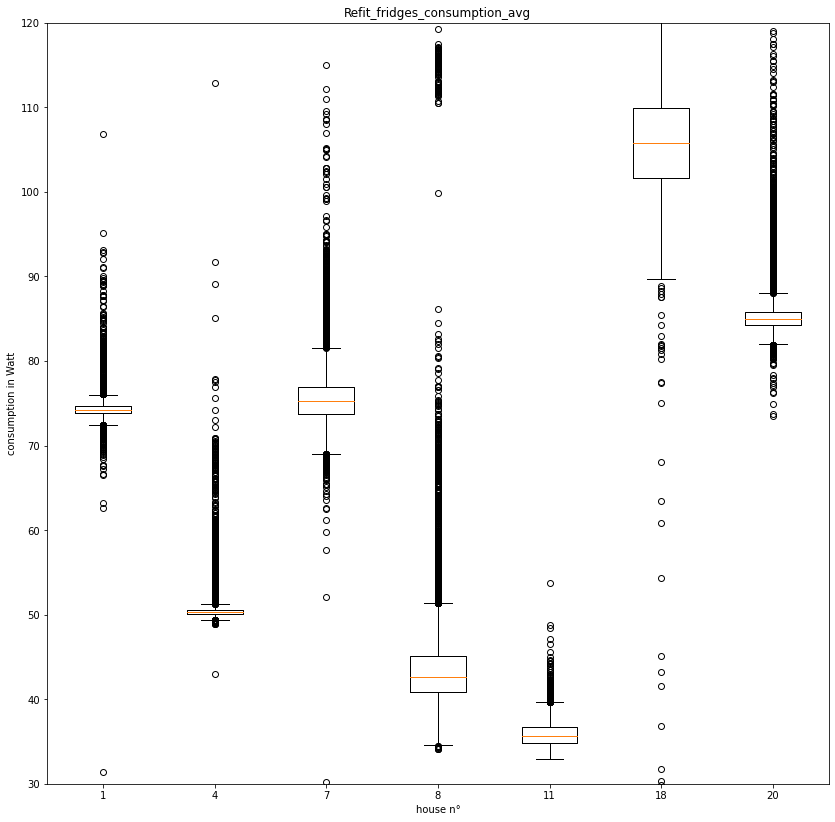

In [14]:
fig7, ax7 = plt.subplots(figsize=(14,14))
ax7.set_title('Refit_fridges_consumption_avg')
ax7.boxplot(Refit_fridge_avg.values())
ax7.set_ylim(30,120)
ax7.set_xticklabels(Refit_fridges.keys())
#plt.savefig('Refit_fridges_consumption_avg.jpg',dpi=184)
plt.ylabel("consumption in Watt")
plt.xlabel("house n°")
plt.show()

In [15]:
min_avg_thresh={1:72,4:45,7:65,8:32,11:30,18:88,20:81}

In [16]:
for key in min_avg_thresh.keys():
    activations=Refit_fridge_activations[key]
    averages=Refit_fridge_avg[key]
    Refit_fridge_activations[key]=[]
    for i in range(len(activations)):
        if averages[i]>=min_avg_thresh[key]:
            Refit_fridge_activations[key].append(activations[i])

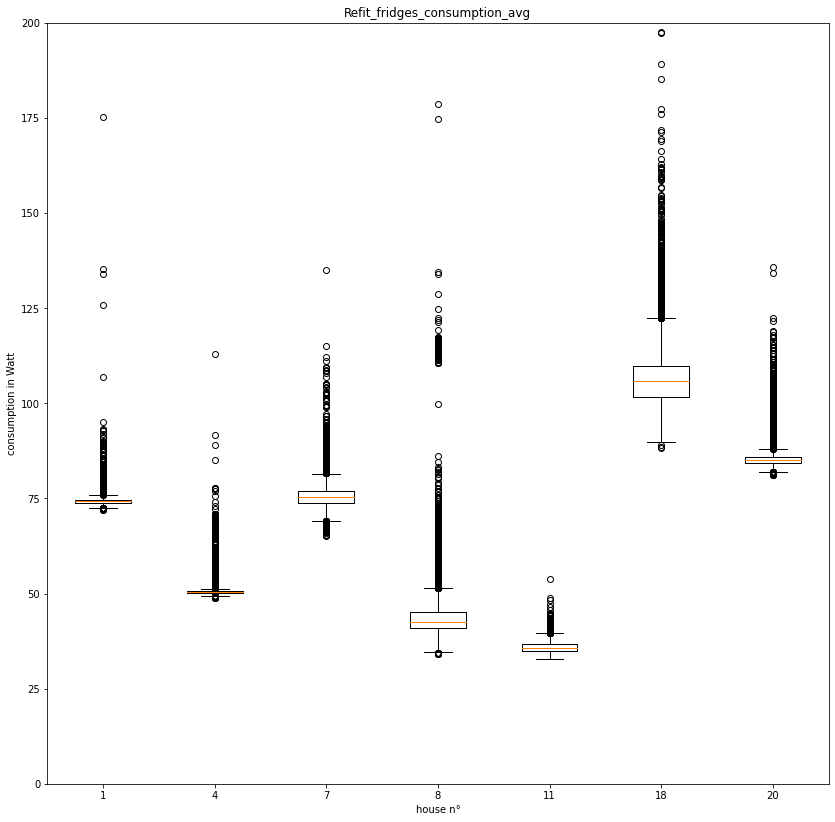

In [43]:
fig7, ax7 = plt.subplots(figsize=(14,14))
ax7.set_title('Refit_fridges_consumption_avg')
ax7.boxplot(Refit_fridge_avg.values())
ax7.set_ylim(0,200)
ax7.set_xticklabels(Refit_fridges.keys())
#plt.savefig('Refit_fridges_consumption_avg.jpg',dpi=184)
plt.ylabel("consumption in Watt")
plt.xlabel("house n°")
plt.show()

In [17]:
nb_of_activations=[]
for key in Refit_fridge_activations.keys():
    nb_of_activations.append(len(Refit_fridge_activations[key]))

<ipython-input-18-6b0a4cab7631>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([1, 4, 7, 8, 11, 18, 20],fontsize=18)


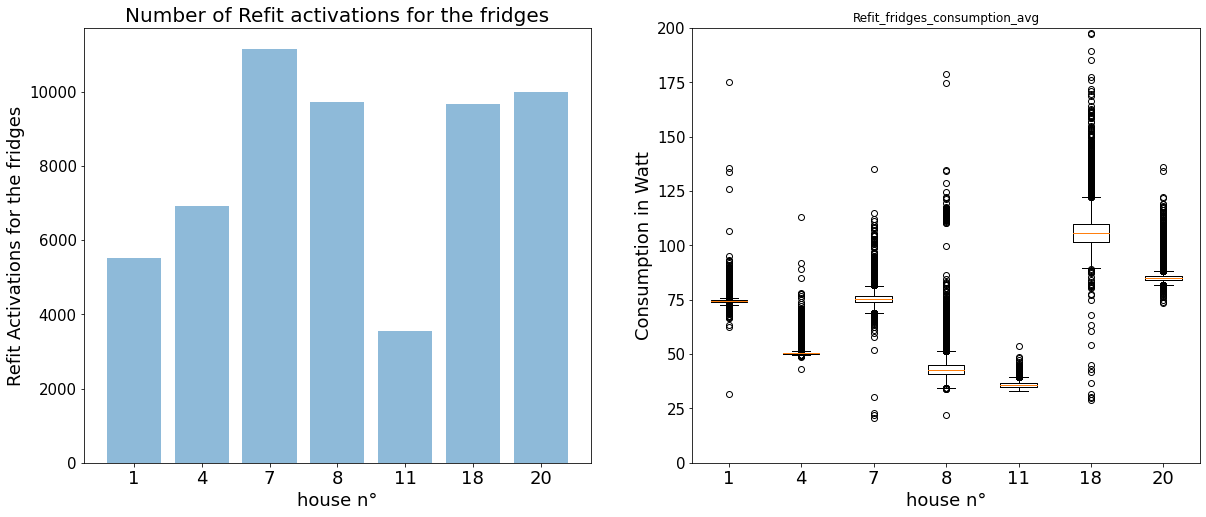

In [18]:
fig, (ax1, ax7) = plt.subplots(1,2,figsize=(20,8))

y_pos = np.arange(7)
ax1.bar(y_pos,nb_of_activations, align='center', alpha=0.5)
ax1.set_title('Number of Refit activations for the fridges',fontsize=20)
ax1.set_xlabel('house n°', fontsize=18)
ax1.set_ylabel('Refit Activations for the fridges', fontsize=18)
plt.setp(ax1.get_yticklabels(), fontsize=15)
ax1.set_xticklabels([1, 4, 7, 8, 11, 18, 20],fontsize=18)
ax1.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([0,1,2,3,4,5,6,7]))

ax7.set_title('Refit_fridges_consumption_avg')
ax7.boxplot(Refit_fridge_avg.values())
ax7.set_ylim(0,200)
ax7.set_xticklabels(Refit_fridges.keys(),fontsize=18)
ax7.set_xlabel('house n°', fontsize=18)
ax7.set_ylabel('Consumption in Watt', fontsize=18)
plt.setp(ax7.get_yticklabels(), fontsize=15)


#plt.savefig('Number_Consumption_fridge_freezers.jpg',dpi=184)
plt.show()

In [19]:
def get_activation_max (df,activations,house_nb):
    maximums=[]
    for activation in activations:
        start=activation[0]
        end=activation[1]
        maximus=max(df.consumption.iloc[start:end])
        maximums.append(maximus)
    return(maximums,house_nb)

In [20]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_activation_max,((Refit_fridges[i],Refit_fridge_activations[i],i) for i in Refit_fridges.keys() ))

In [21]:
Refit_fridge_max={}
for i in range(len(result)):
        Refit_fridge_max[result[i][1]]=result[i][0]

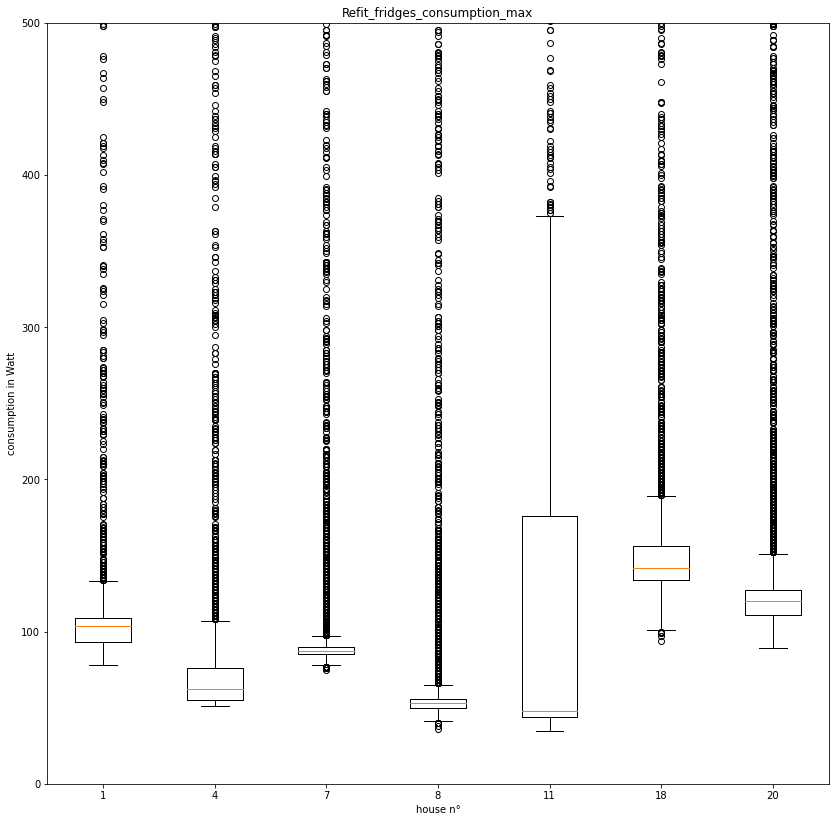

In [22]:
fig7, ax7 = plt.subplots(figsize=(14,14))
ax7.set_title('Refit_fridges_consumption_max')
ax7.boxplot(Refit_fridge_max.values())
ax7.set_ylim(0,500)
ax7.set_xticklabels(Refit_fridges.keys())
plt.savefig('Refit_fridges_consumption_max.jpg',dpi=184)
plt.ylabel("consumption in Watt")
plt.xlabel("house n°")
plt.show()

In [9]:
fridge_avg_thres={1:80,4:55,7:83,8:56,11:40,18:135,20:89}

In [10]:
fridge_max_thres={}
for key in fridge_avg_thres.keys():
    fridge_max_thres[key]=300

In [11]:
fridge_max_thres[7]=350
fridge_max_thres[18]=400
fridge_max_thres[20]=400

In [12]:
def normal_avg (df,activation,thresh):
    start=activation[0]
    end=activation[1]
    avg=sum(df.consumption.iloc[start:end])/len(df.consumption.iloc[start:end])
    if avg<=thresh:
        return True
    else:
        return False

In [13]:
def normal_max(df,activation,thresh=350):
    start=activation[0]
    end=activation[1]
    maximus=max(df.consumption.iloc[start:end])
    if maximus<=thresh:
        return True
    else:
        return False

In [14]:
def get_normal_activations(df,activations,house_nb):
    normal_activations=[]
    for activation in activations:
        if normal_avg(df,activation,fridge_avg_thres[house_nb]) and normal_max(df,activation,fridge_max_thres[house_nb]):
            normal_activations.append(activation)
    return(normal_activations,house_nb)

In [15]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_normal_activations,((Refit_fridges[i],Refit_fridge_activations[i],i) for i in fridge_avg_thres.keys() ))

In [16]:
Refit_fridge_normal_activations={}
for i in range(len(result)):
        Refit_fridge_normal_activations[result[i][1]]=result[i][0]

In [16]:
i=20
Refit_fridge_normal_activations[i]=get_normal_activations(Refit_fridges[i],Refit_fridge_activations[i],i)[0]

In [4]:
def get_anomolous_activations(activations,normal_activations,house_nb):
    anomolous_activations=[]
    for activation in activations:
        if activation not in normal_activations:
            anomolous_activations.append(activation)
    return(anomolous_activations,house_nb)

In [18]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_anomolous_activations,((Refit_fridge_activations[i],Refit_fridge_normal_activations[i],i) for i in fridge_avg_thres.keys() ))

In [19]:
Refit_fridge_anomolous_activations={}
for i in range(len(result)):
        Refit_fridge_anomolous_activations[result[i][1]]=result[i][0]

In [117]:
i=20
Refit_fridge_anomolous_activations[i]=get_anomolous_activations(Refit_fridge_activations[i],Refit_fridge_normal_activations[i],i)[0]

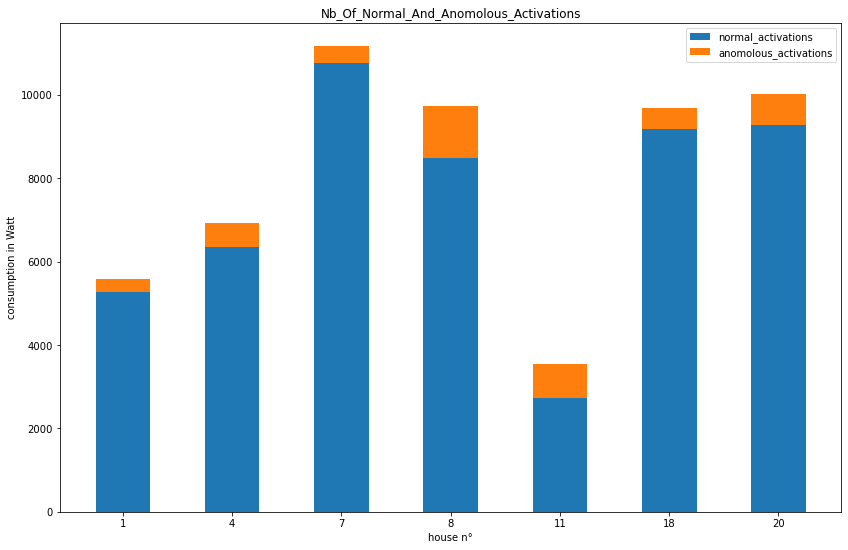

In [20]:
nb_normal_activations=[]
nb_anomolous_activations=[]
for i in fridge_avg_thres.keys(): 
    nb_normal_activations.append(len(Refit_fridge_normal_activations[i]))
    nb_anomolous_activations.append(len(Refit_fridge_anomolous_activations[i]))
fig, ax = plt.subplots(figsize =(14, 9))
width =0.5
y_pos = np.arange(7)
ax.bar(np.arange(len(nb_normal_activations)), nb_normal_activations, width=width,label='normal_activations')
ax.bar(np.arange(len(nb_anomolous_activations)), nb_anomolous_activations,bottom=nb_normal_activations, width=width,label="anomolous_activations")
plt.xticks(y_pos, Refit_fridge_normal_activations.keys())
plt.title('Nb_Of_Normal_And_Anomolous_Activations')
plt.legend()
plt.ylabel("consumption in Watt")
plt.xlabel("house n°")

plt.savefig('Refit_fridges_Nb_Of_Normal_And_Anomolous_Activations.jpg',dpi=184)

plt.show()

/home/mahdi/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


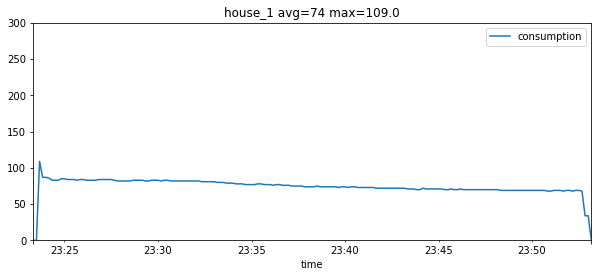

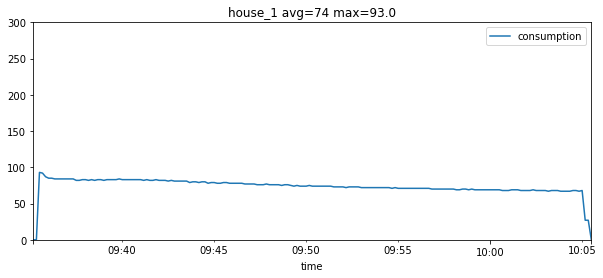

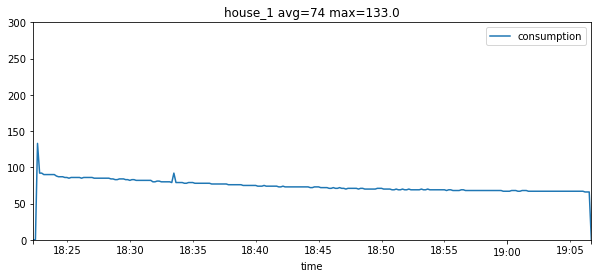

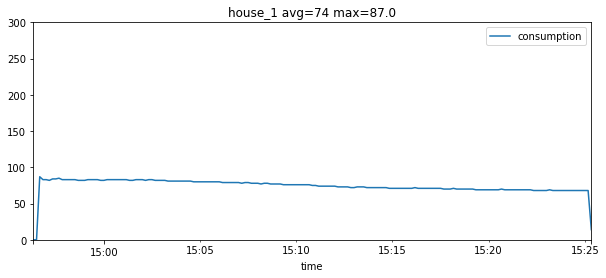

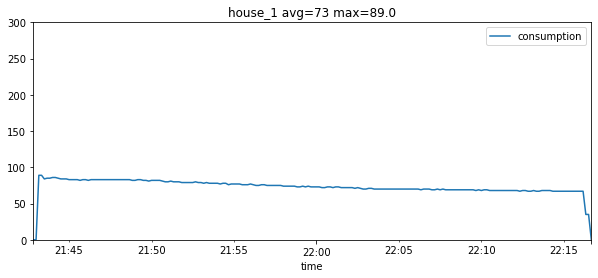

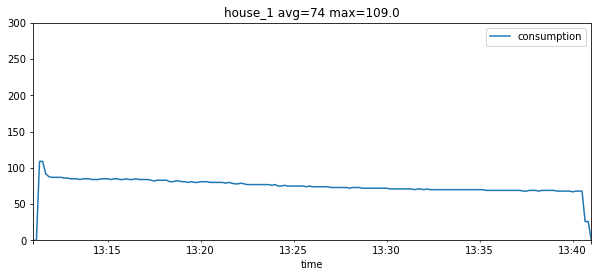

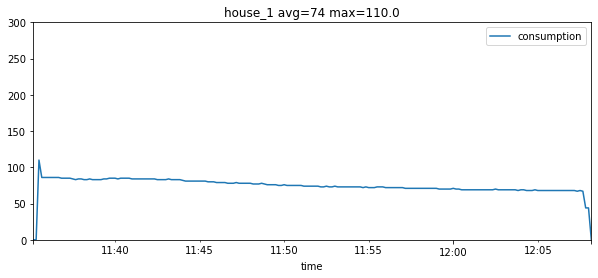

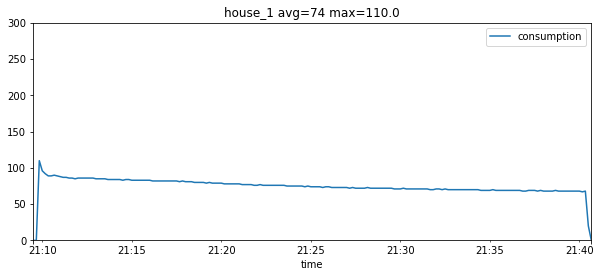

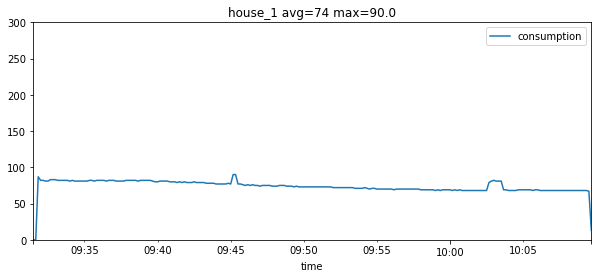

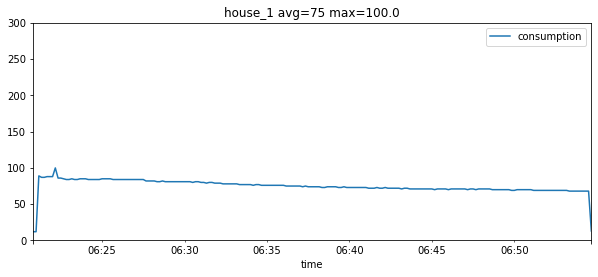

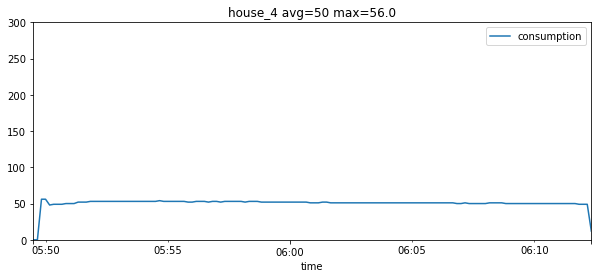

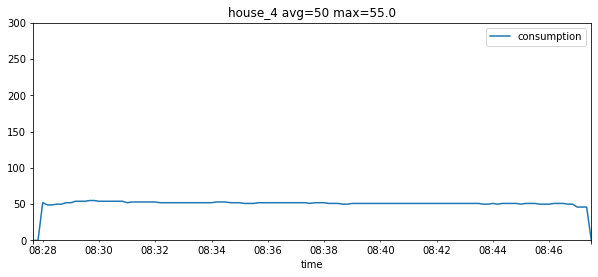

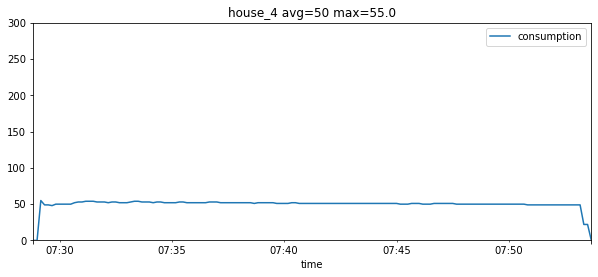

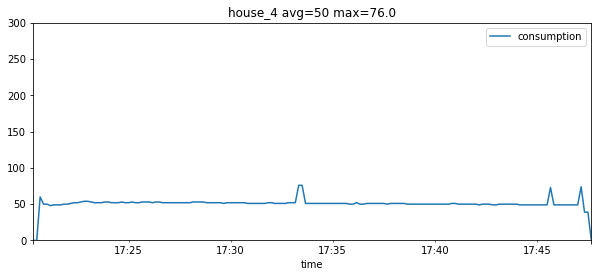

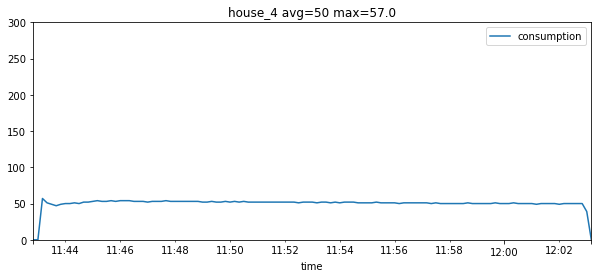

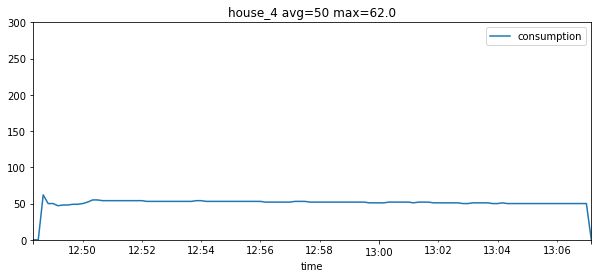

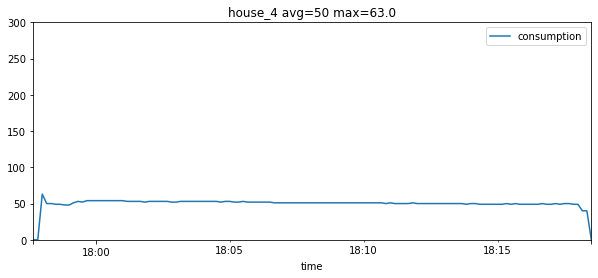

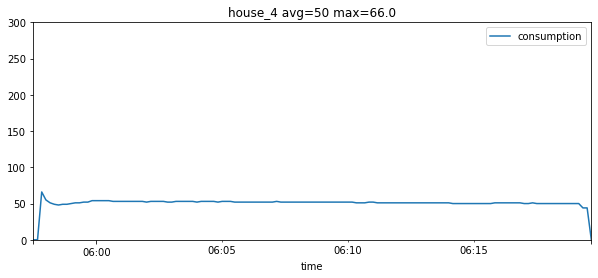

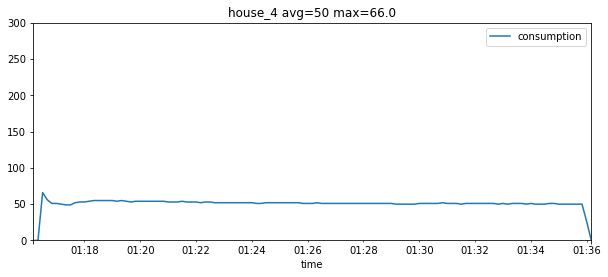

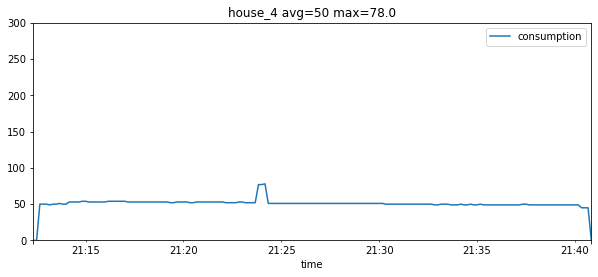

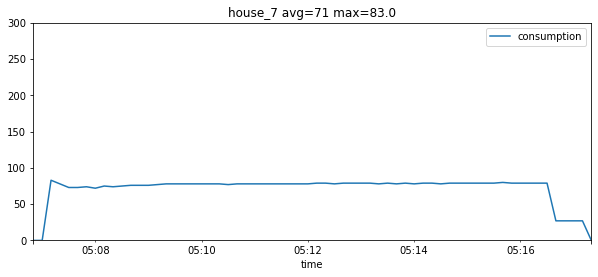

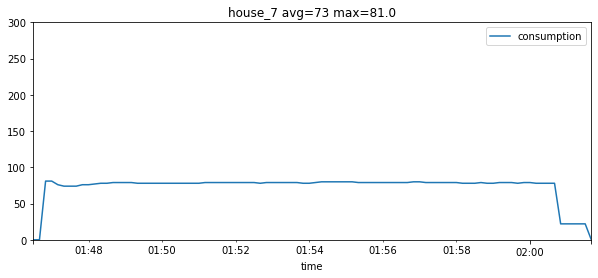

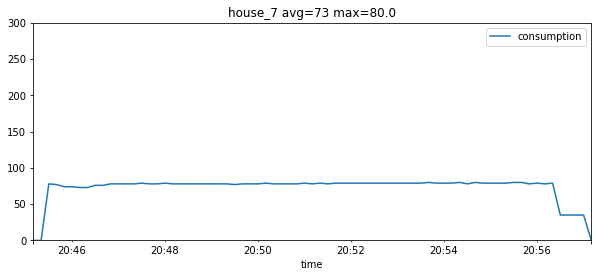

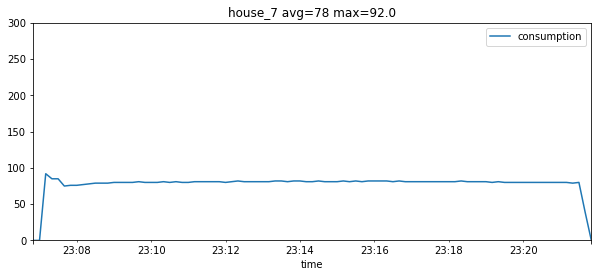

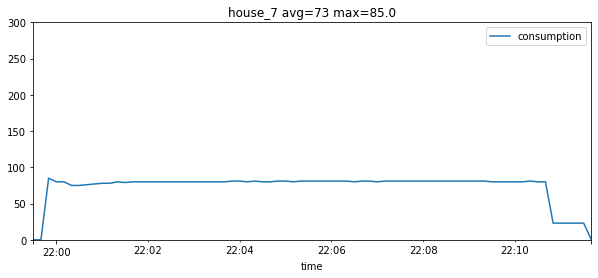

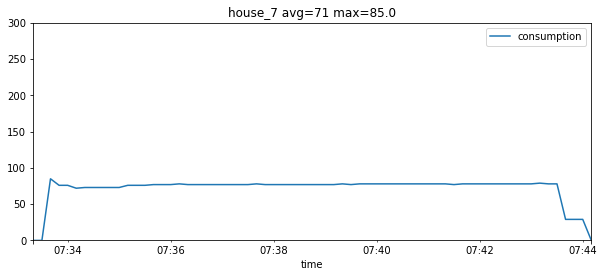

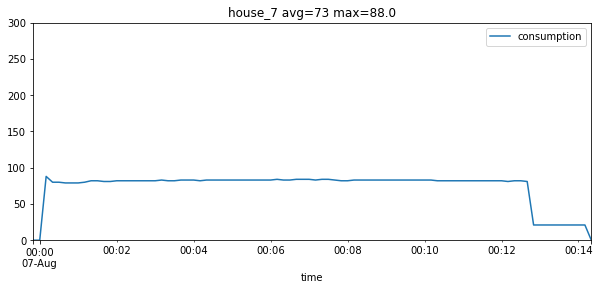

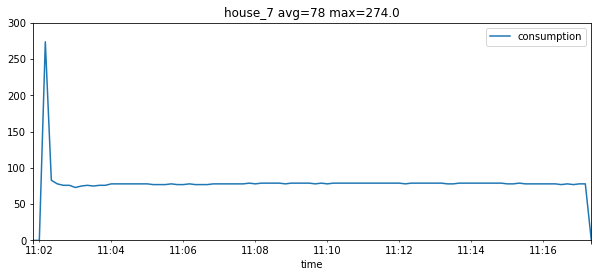

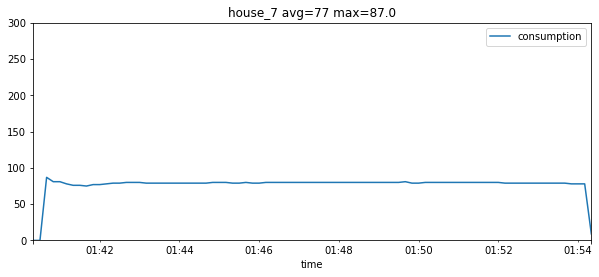

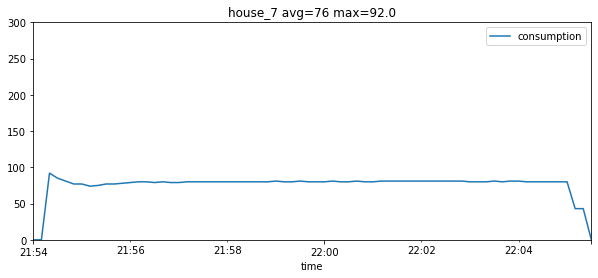

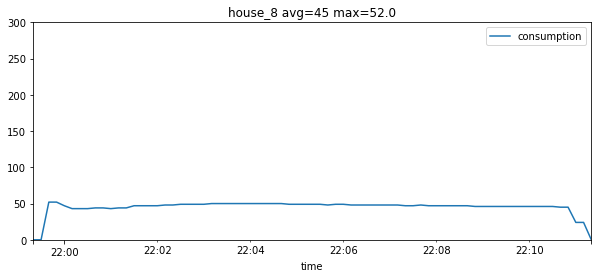

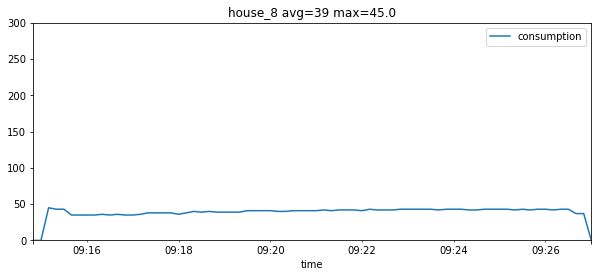

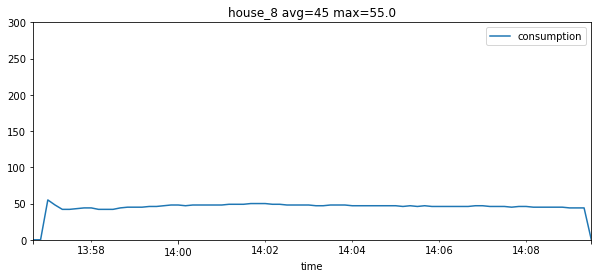

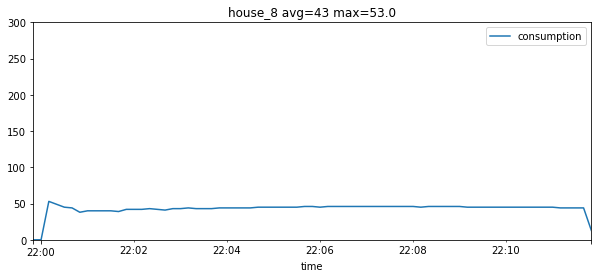

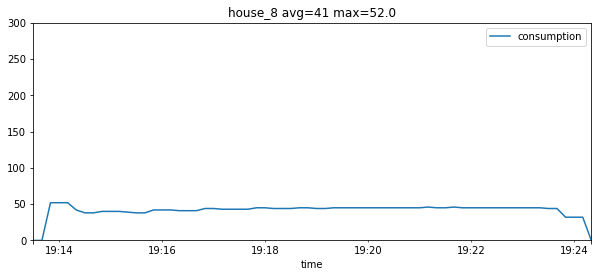

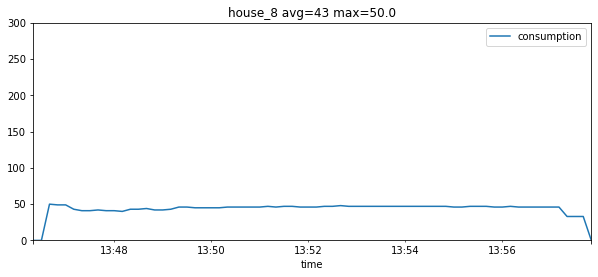

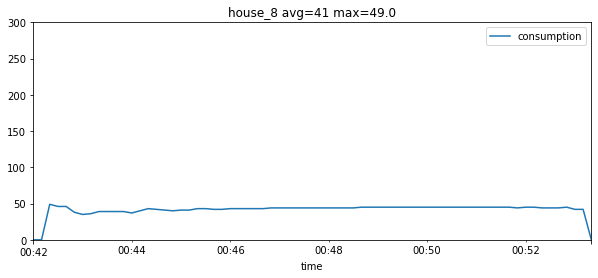

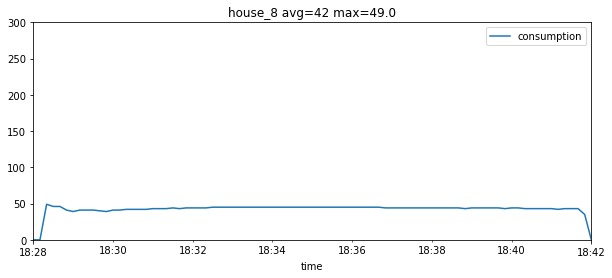

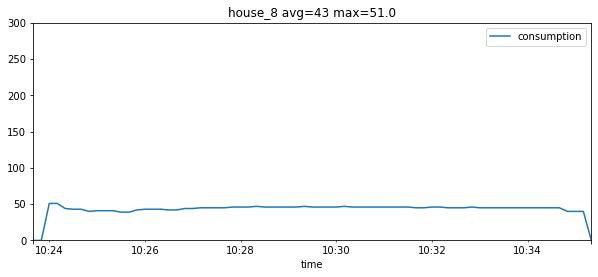

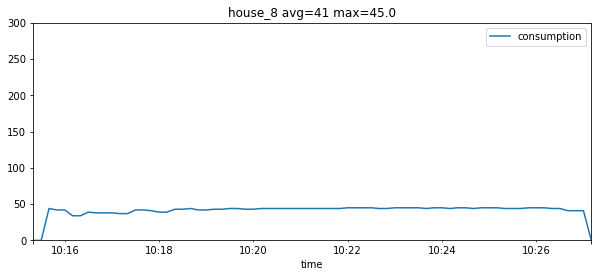

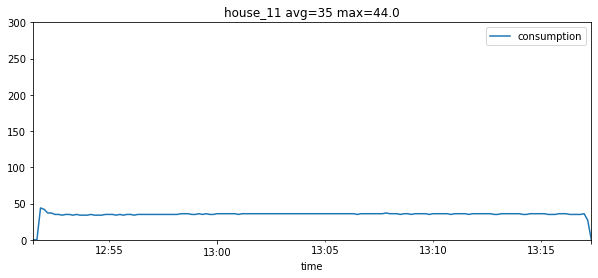

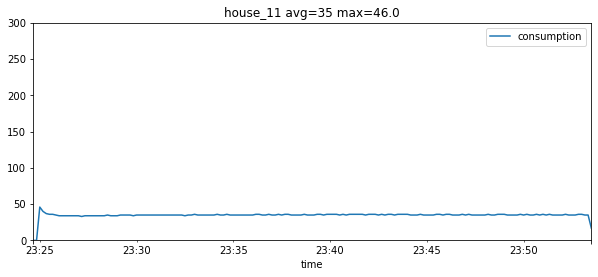

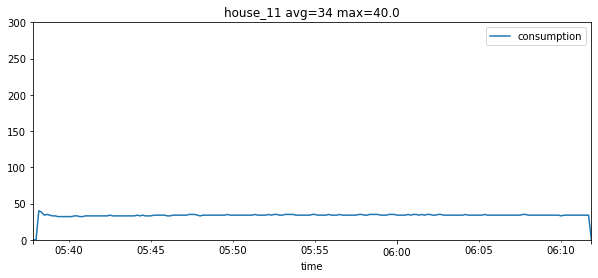

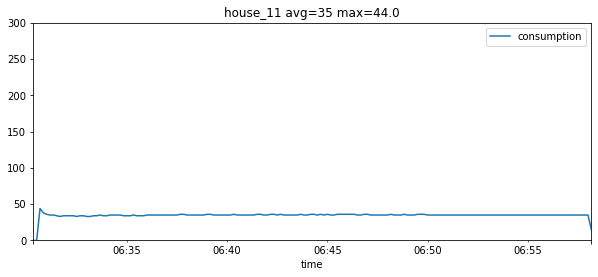

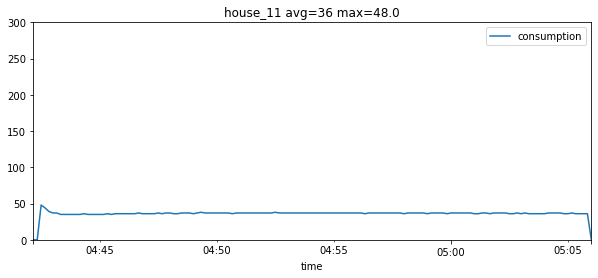

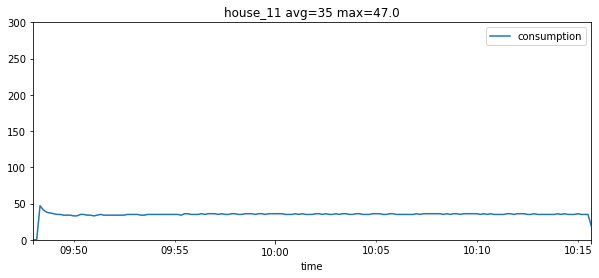

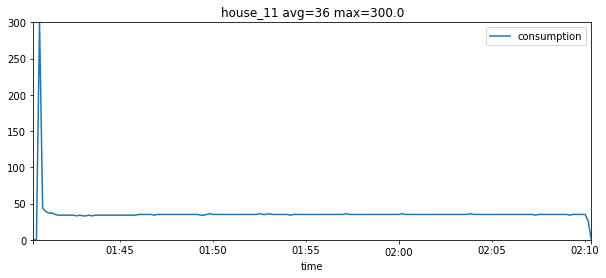

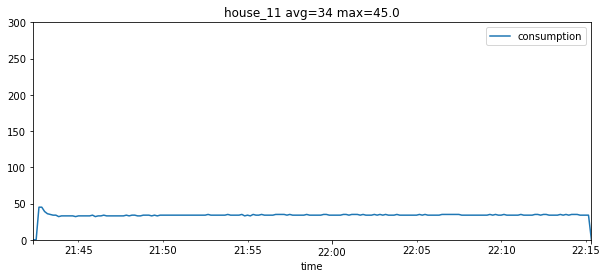

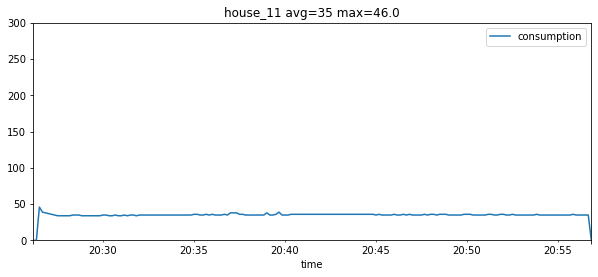

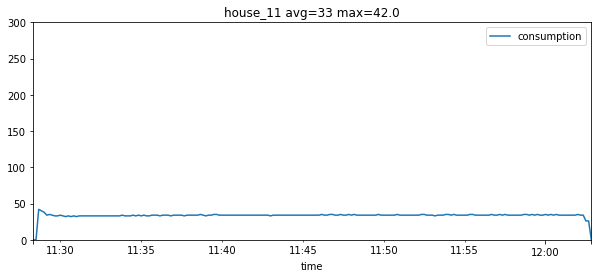

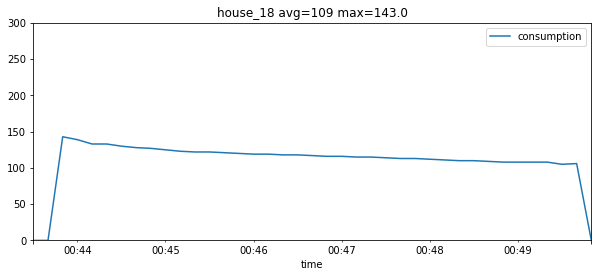

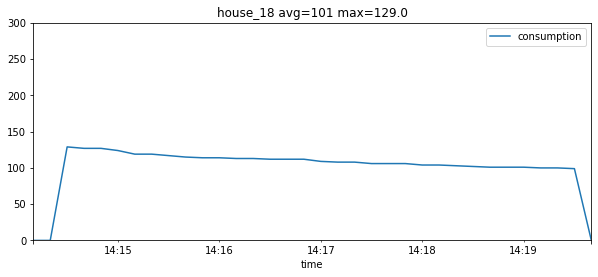

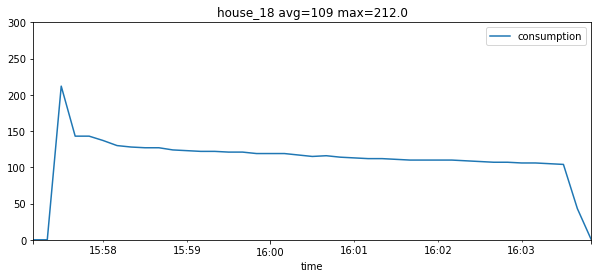

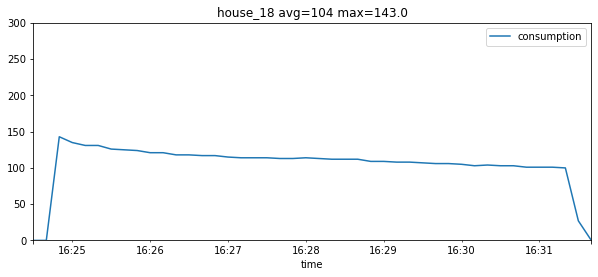

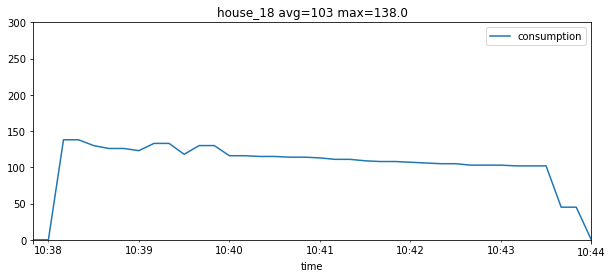

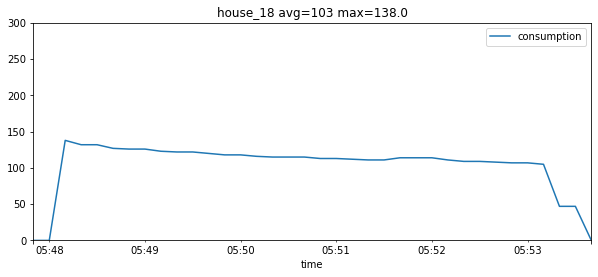

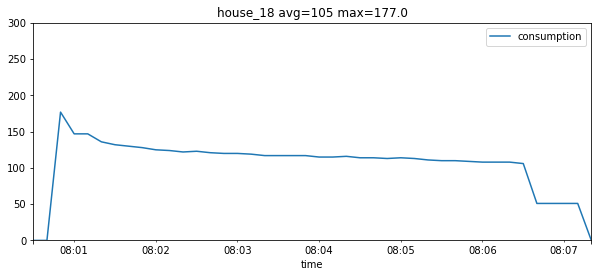

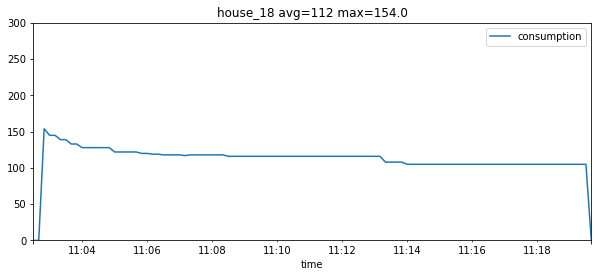

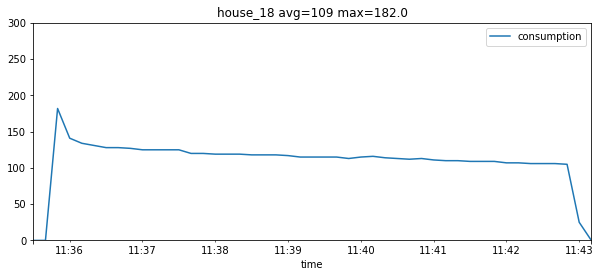

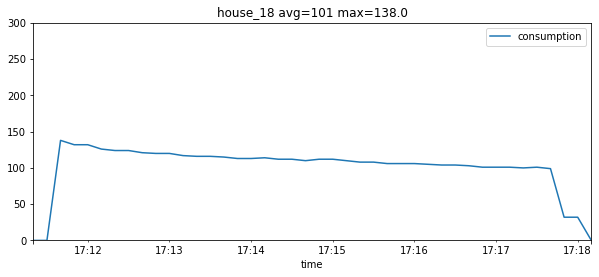

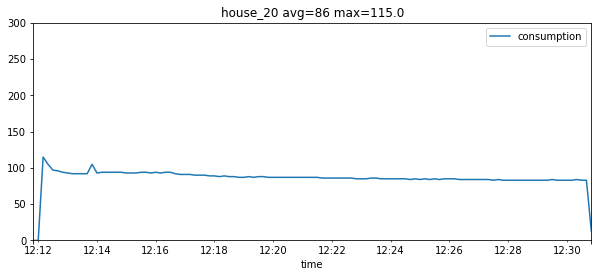

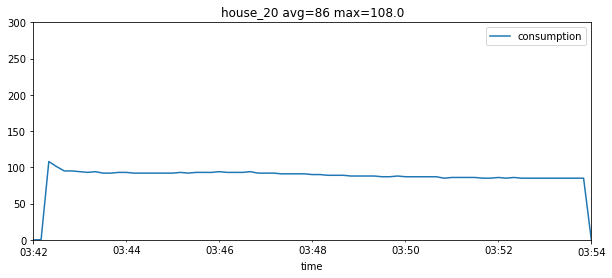

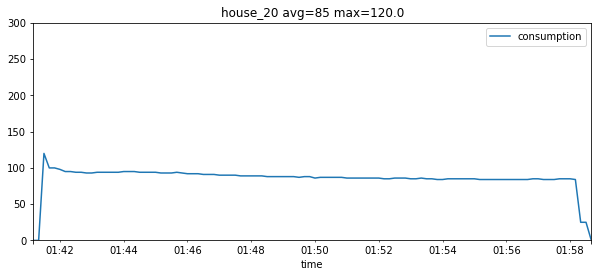

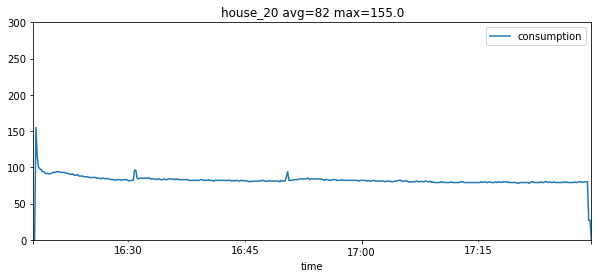

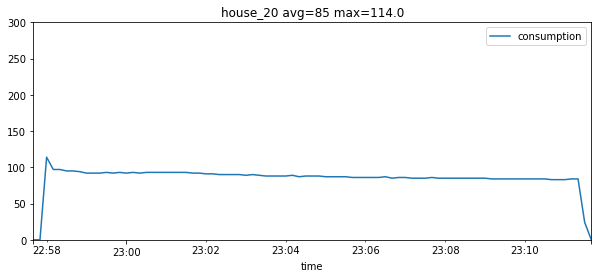

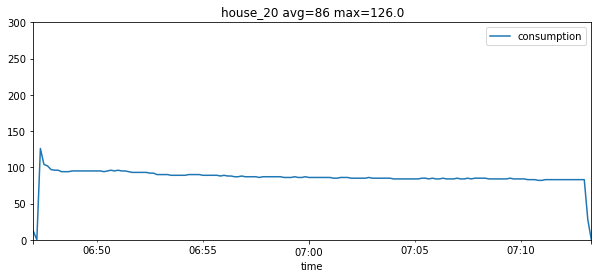

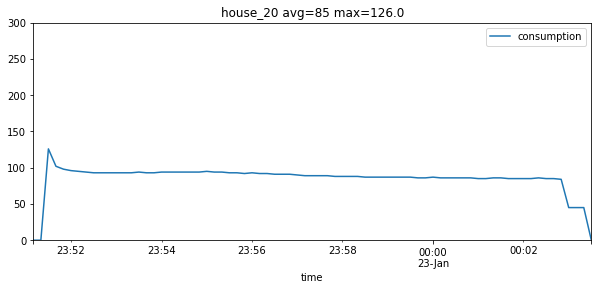

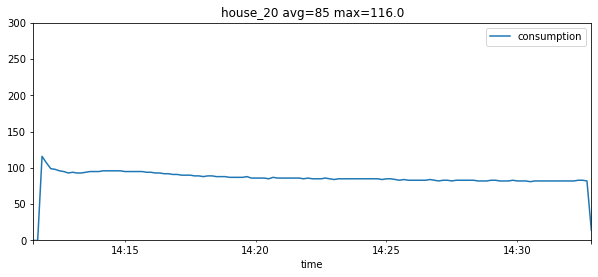

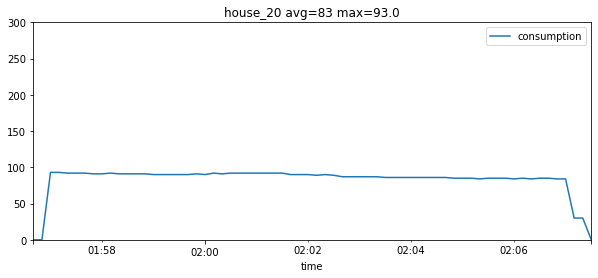

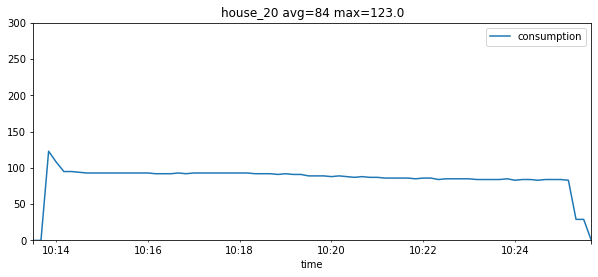

In [65]:
for house in fridge_avg_thres.keys():
    activations=random.sample(range(0, len(Refit_fridge_normal_activations[house])),10)
    df=Refit_fridges[house]
    for activation in activations:
        beginning=Refit_fridge_normal_activations[house][activation][0]
        end=Refit_fridge_normal_activations[house][activation][1]
        avg=sum(df.consumption.iloc[beginning:end])/len(df.consumption.iloc[beginning:end])
        maximus=max(df.consumption.iloc[beginning:end])
        ax=df.iloc[beginning:end].plot(x="time",y=['consumption'], figsize=(10,4),title="house_"+str(house)+" avg="+str(round(avg))+" max="+str(maximus))
        ax.set_ylim(0,300)

/home/mahdi/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


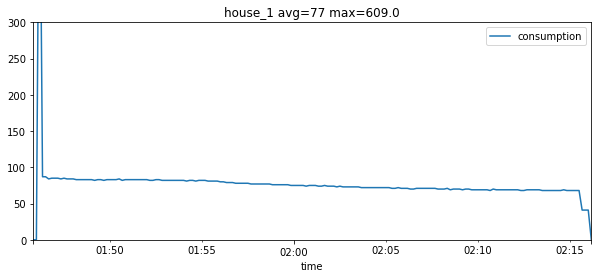

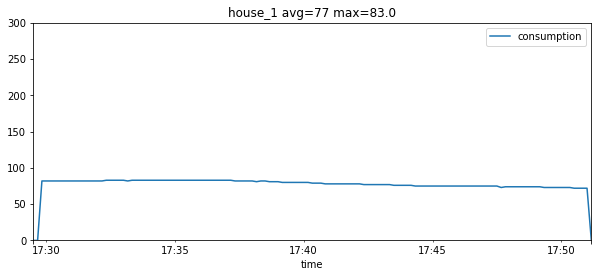

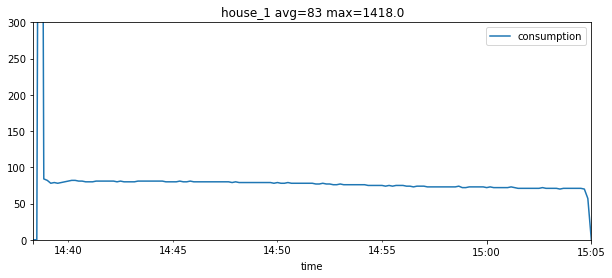

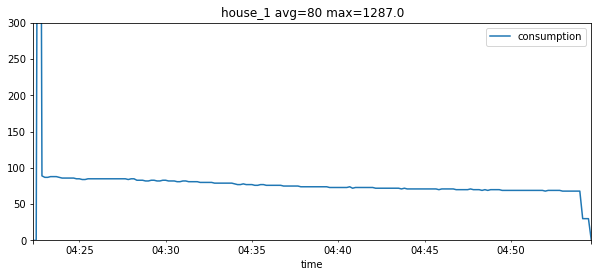

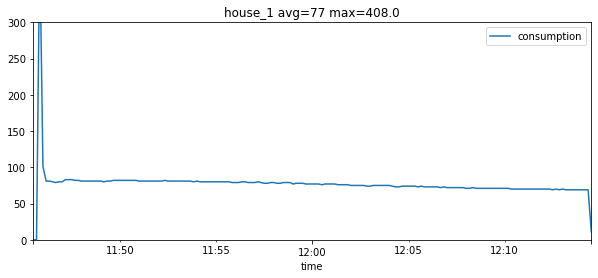

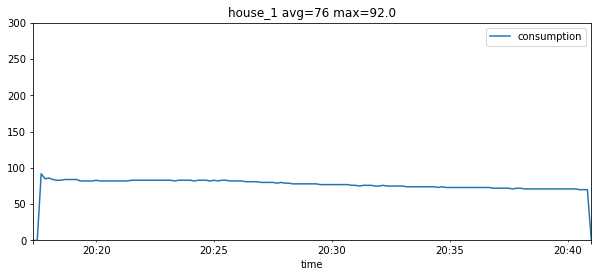

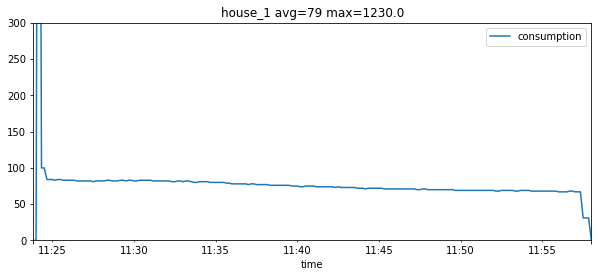

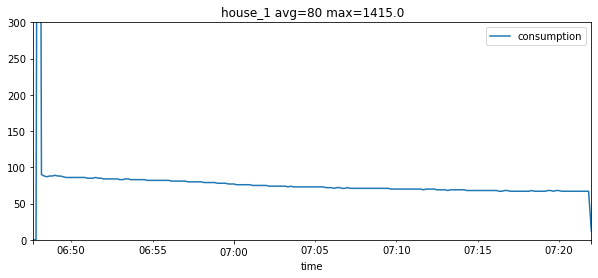

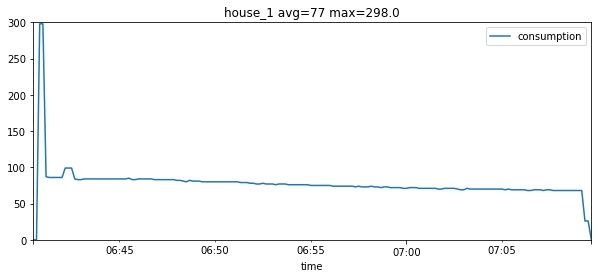

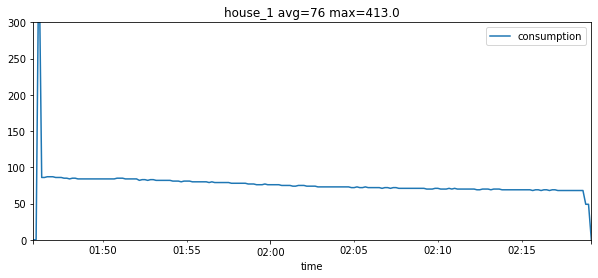

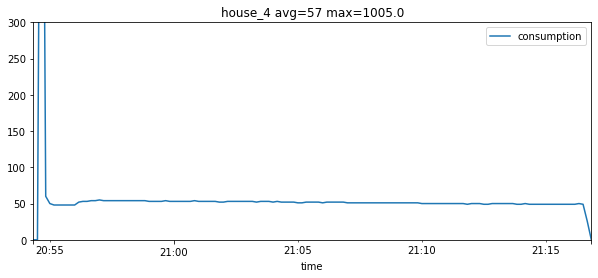

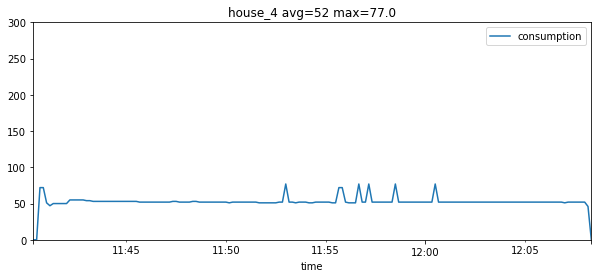

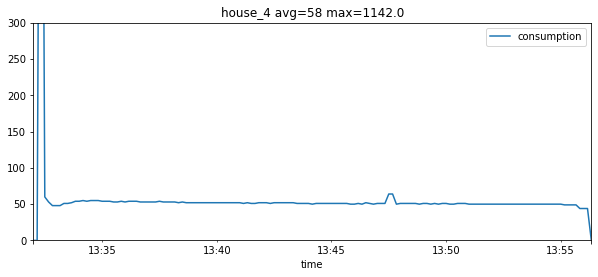

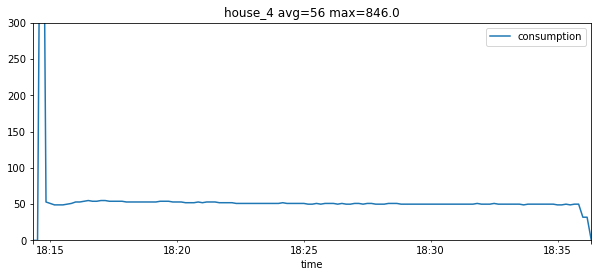

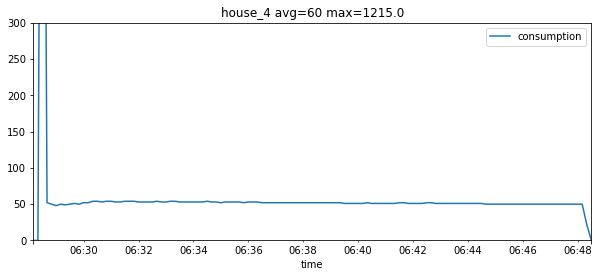

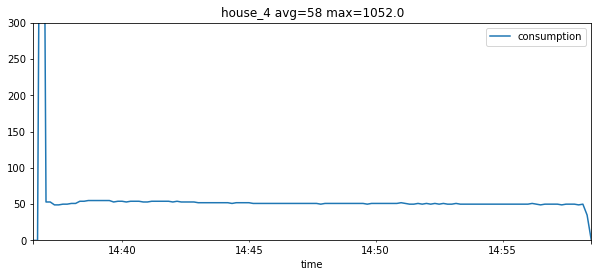

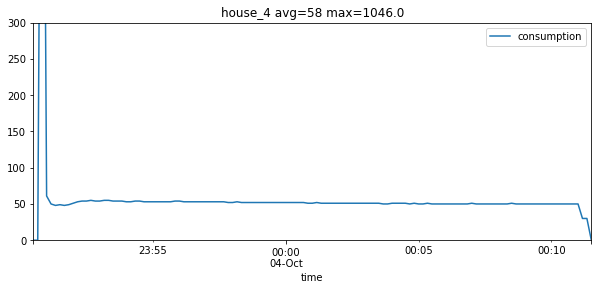

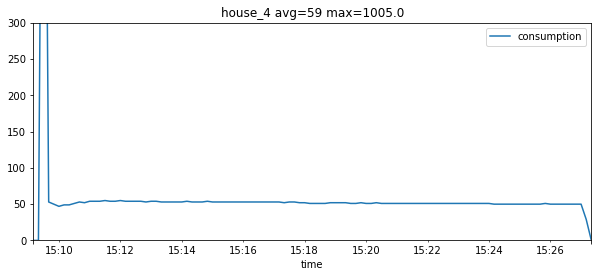

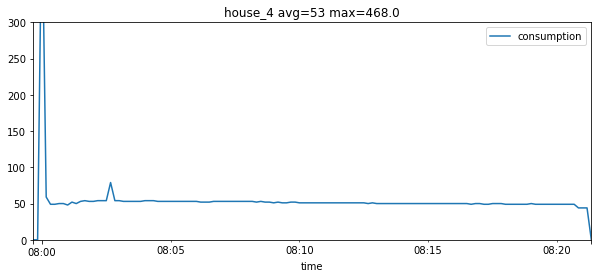

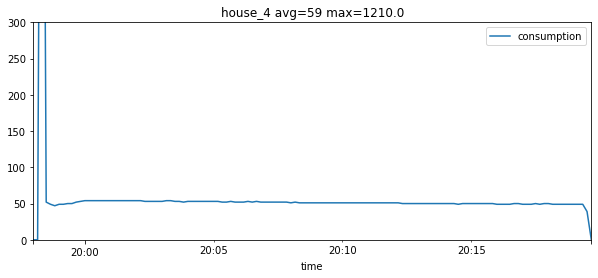

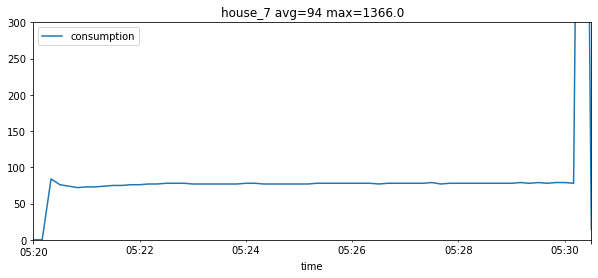

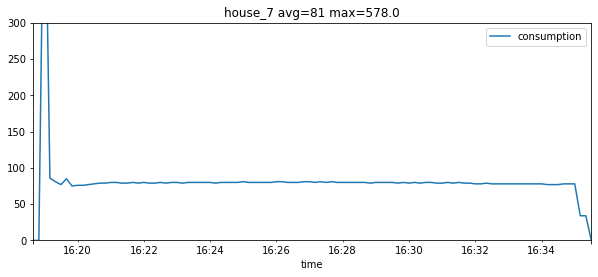

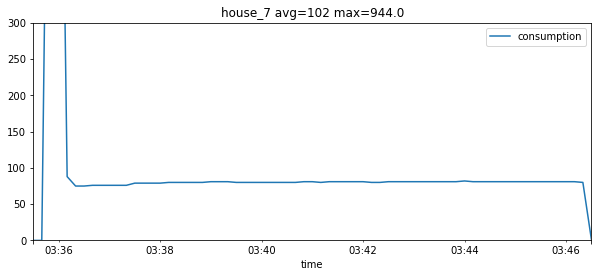

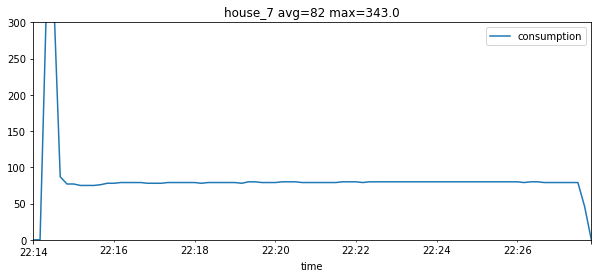

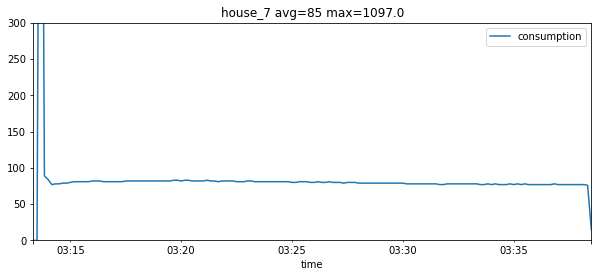

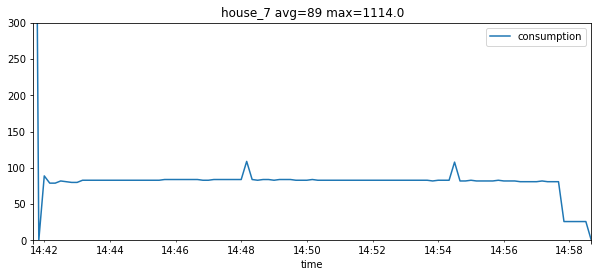

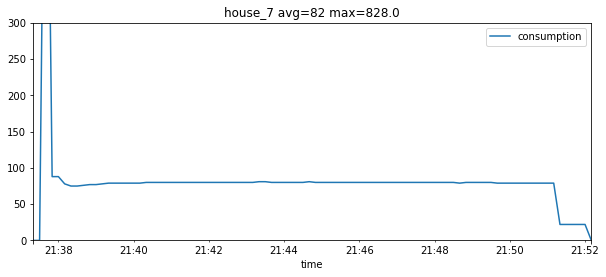

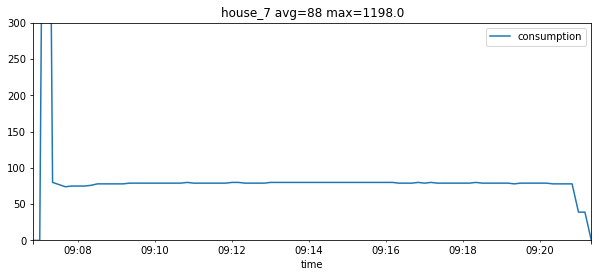

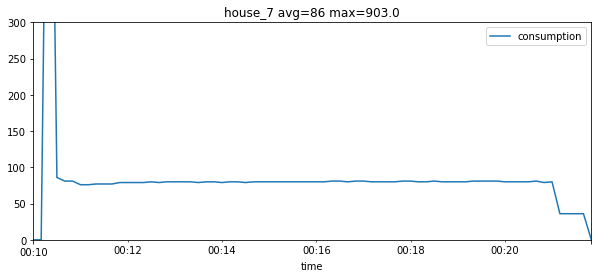

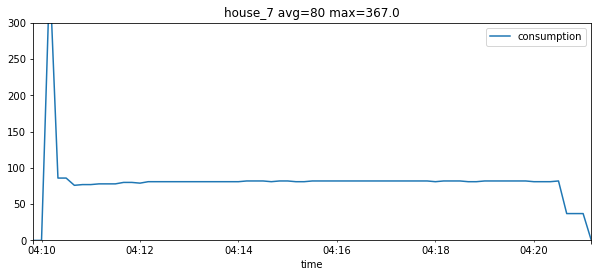

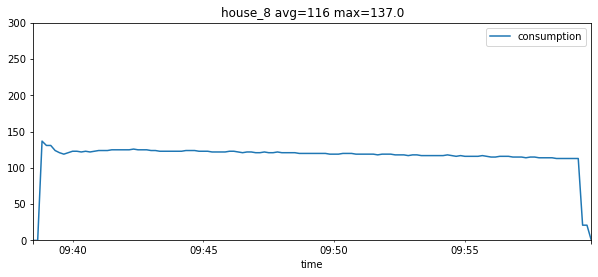

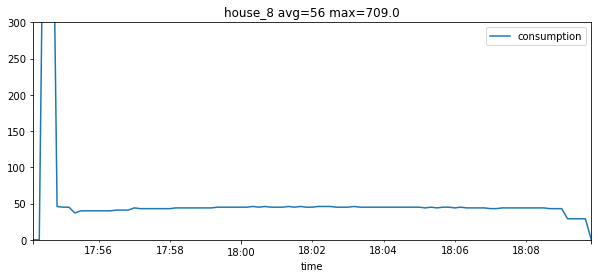

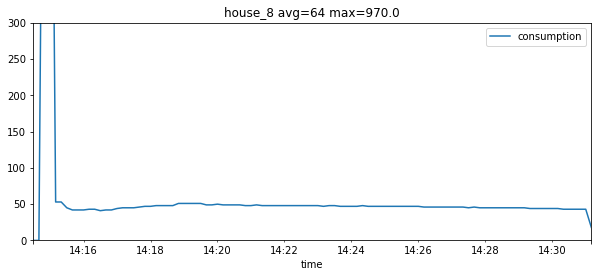

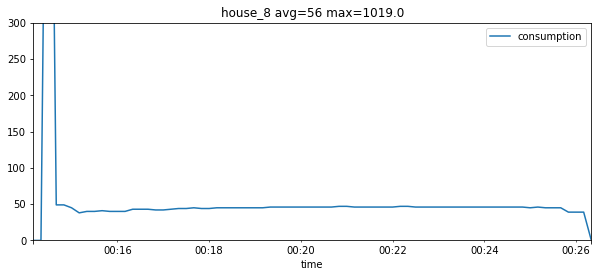

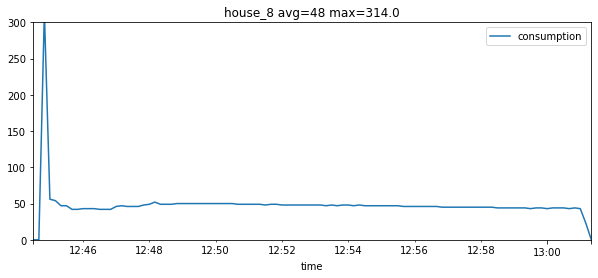

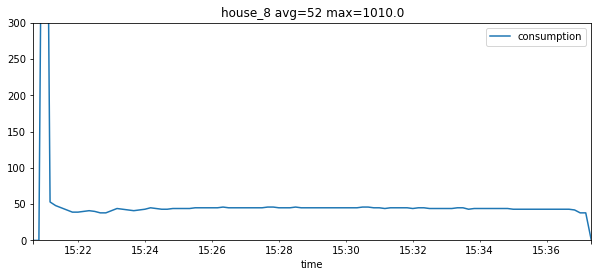

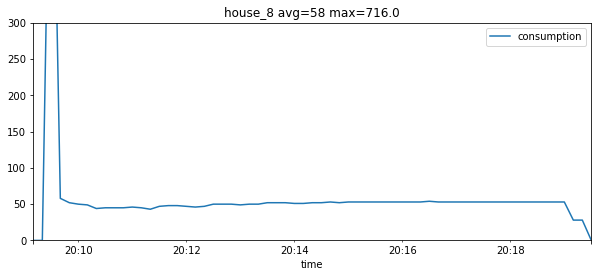

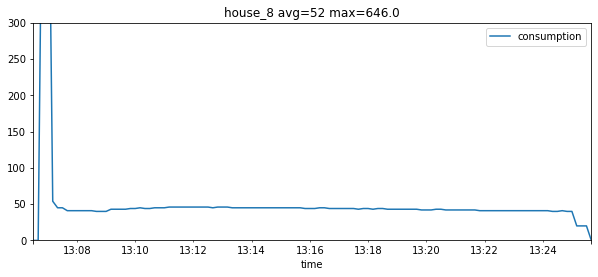

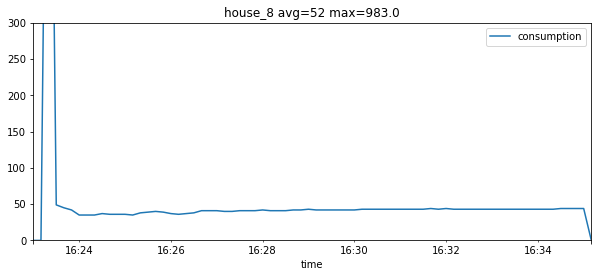

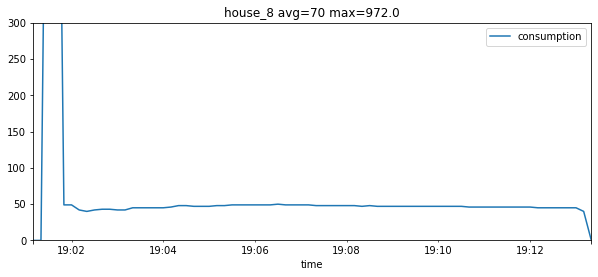

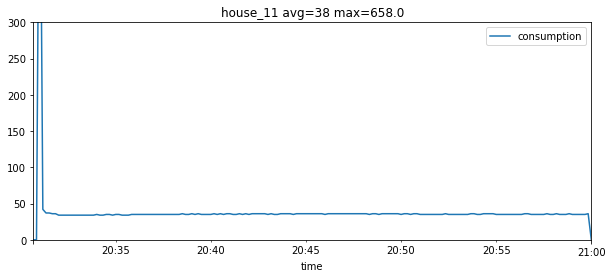

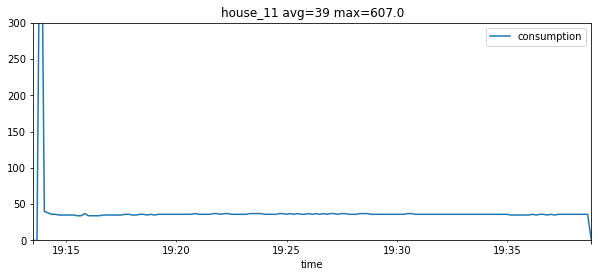

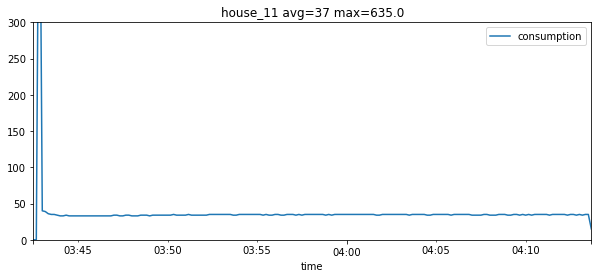

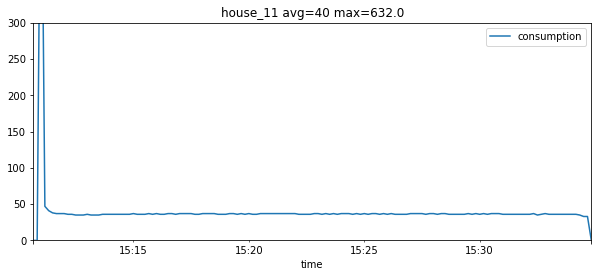

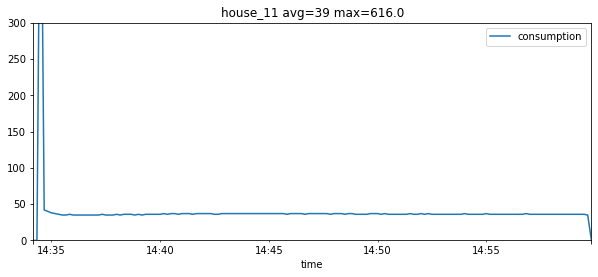

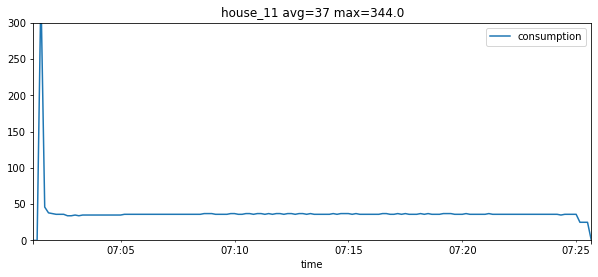

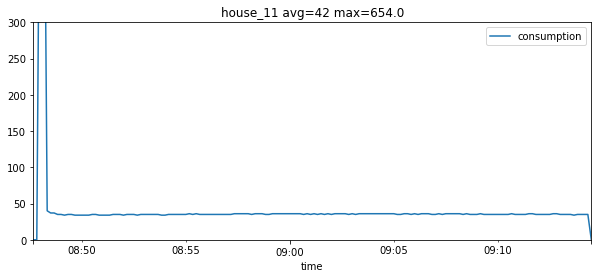

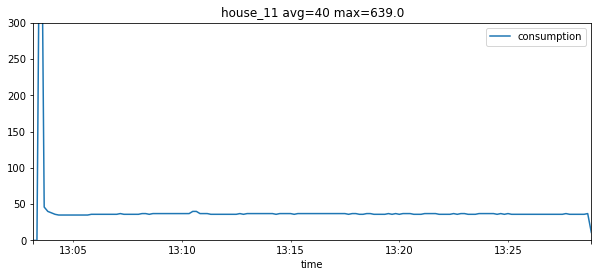

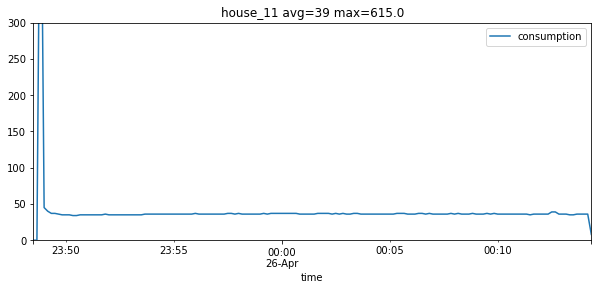

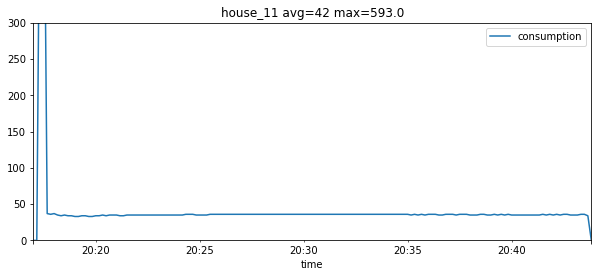

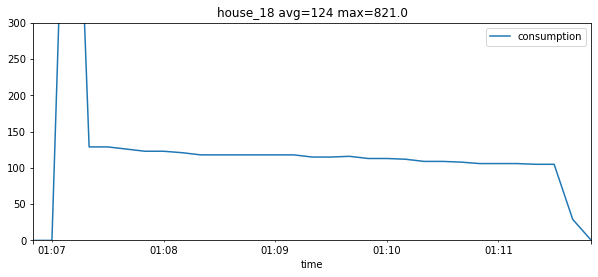

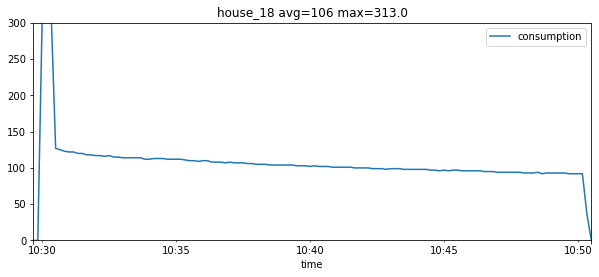

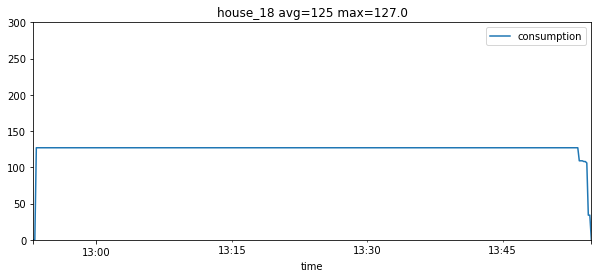

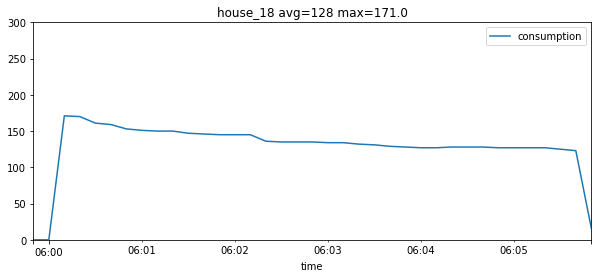

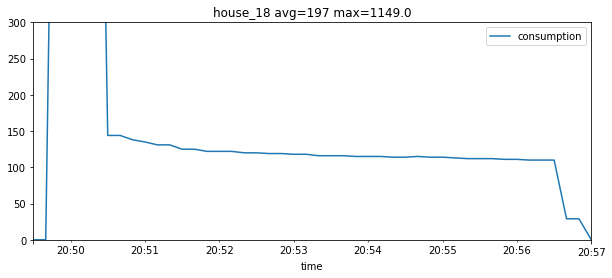

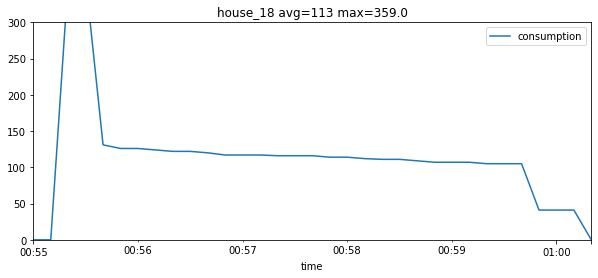

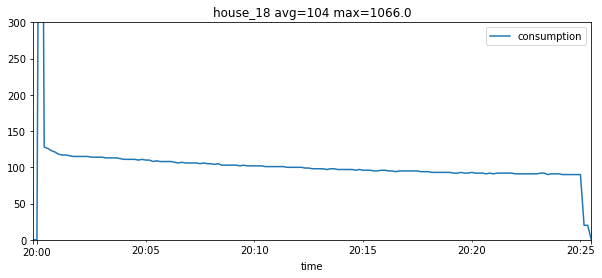

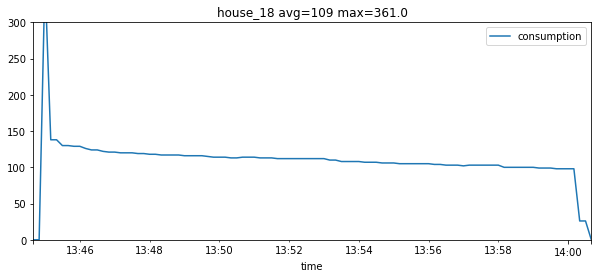

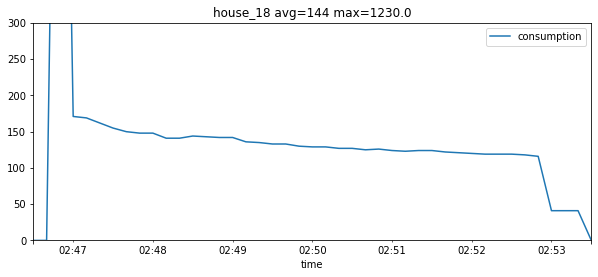

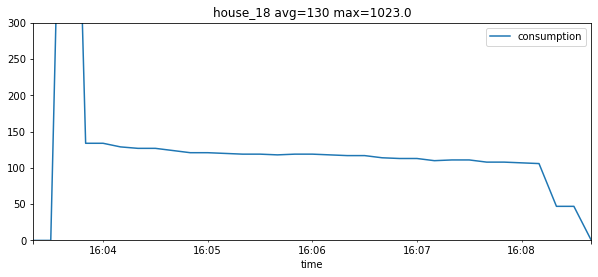

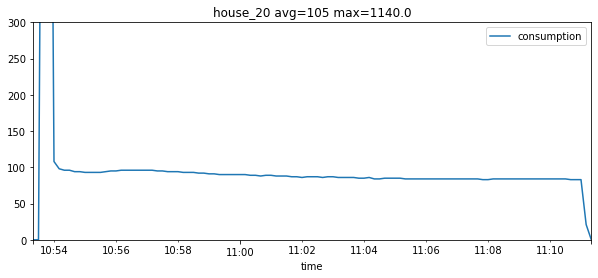

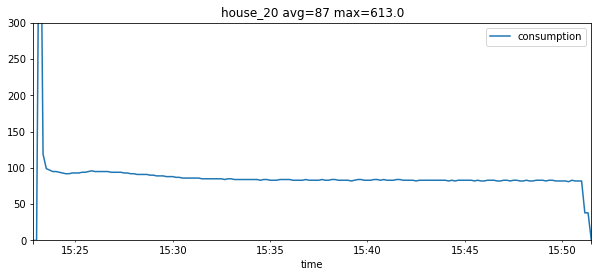

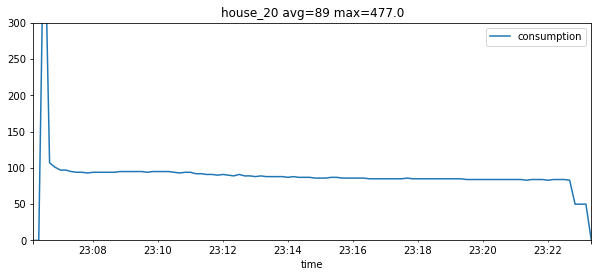

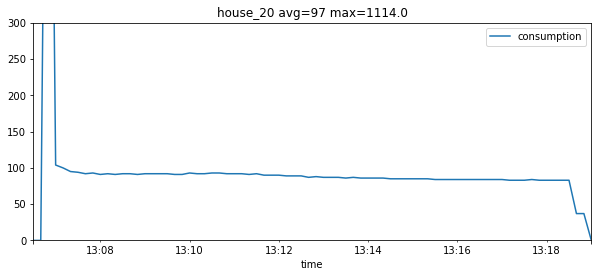

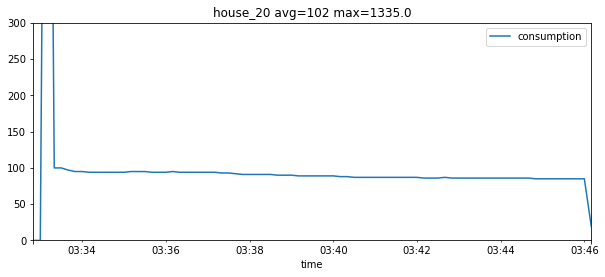

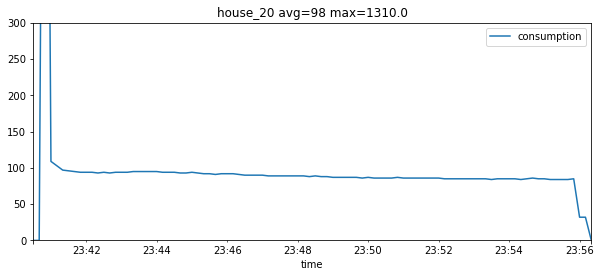

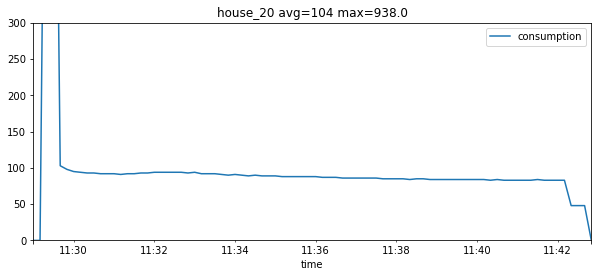

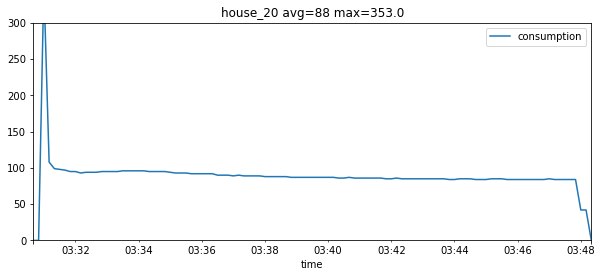

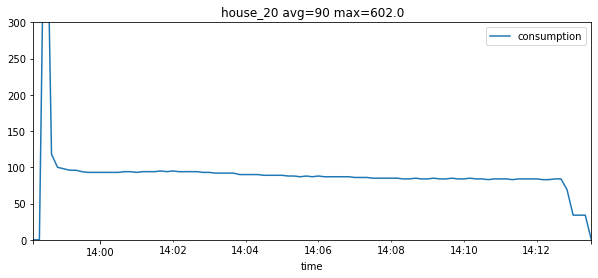

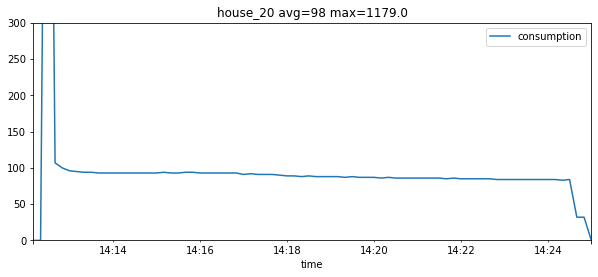

In [67]:
for house in fridge_avg_thres.keys():
    activations=random.sample(range(0, len(Refit_fridge_anomolous_activations[house])),10)
    df=Refit_fridges[house]
    for activation in activations:
        beginning=Refit_fridge_anomolous_activations[house][activation][0]
        end=Refit_fridge_anomolous_activations[house][activation][1]
        avg=sum(df.consumption.iloc[beginning:end])/len(df.consumption.iloc[beginning:end])
        maximus=max(df.consumption.iloc[beginning:end])
        ax=df.iloc[beginning:end].plot(x="time",y=['consumption'], figsize=(10,4),title="house_"+str(house)+" avg="+str(round(avg))+" max="+str(maximus))
        ax.set_ylim(0,300)

/home/mahdi/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


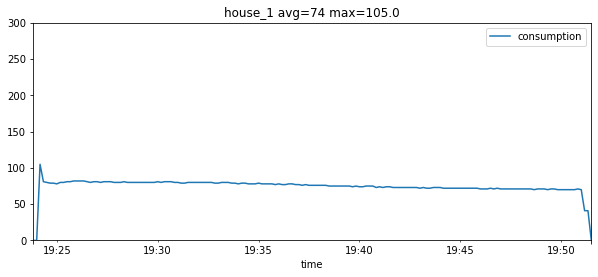

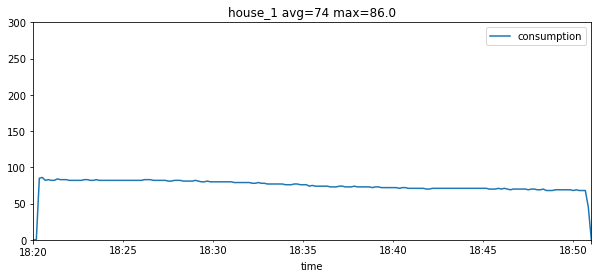

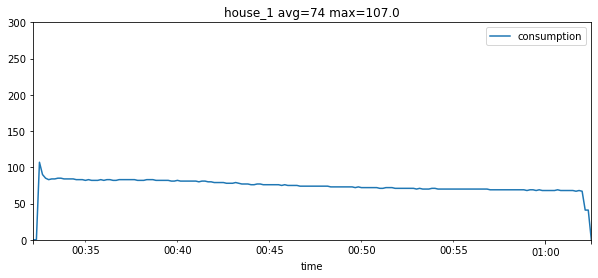

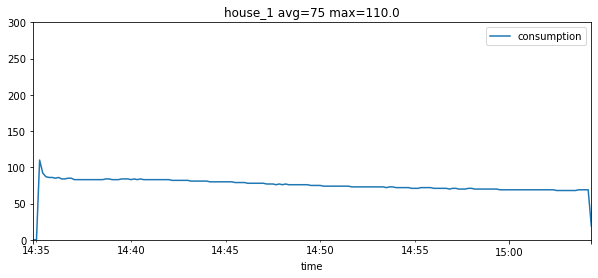

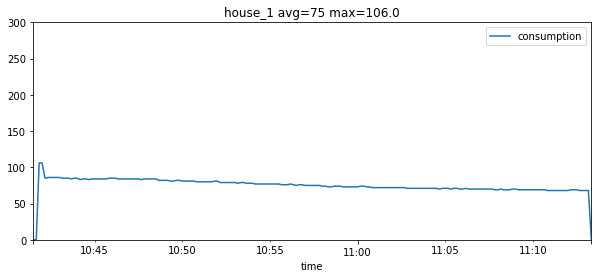

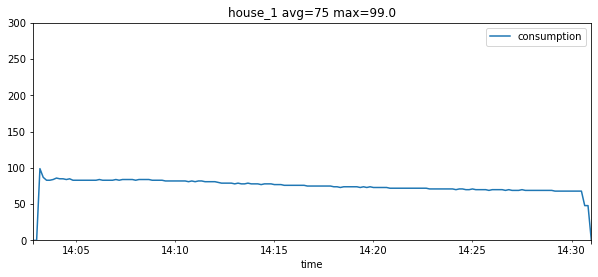

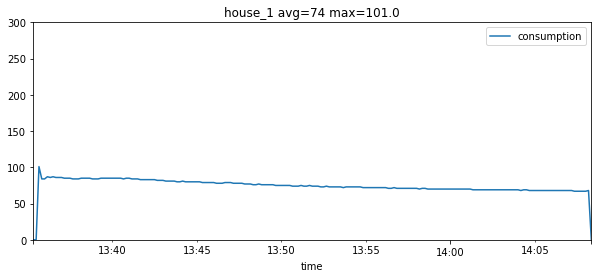

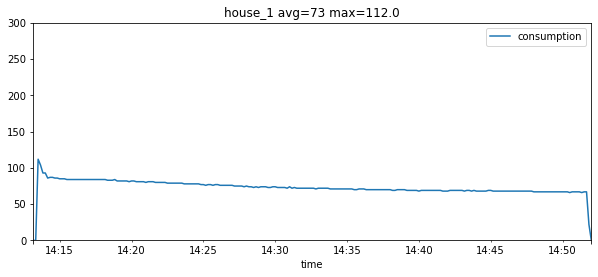

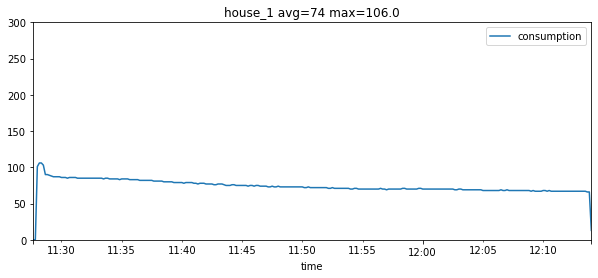

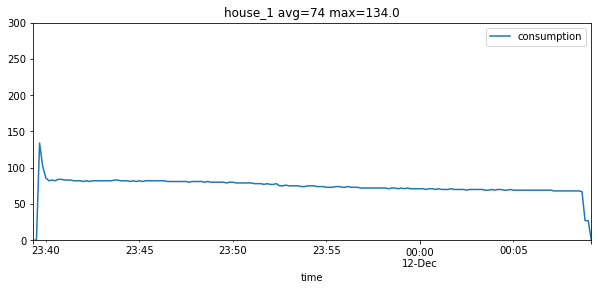

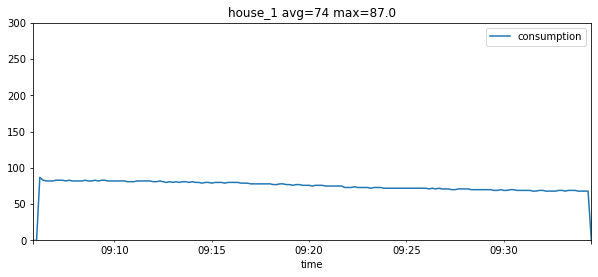

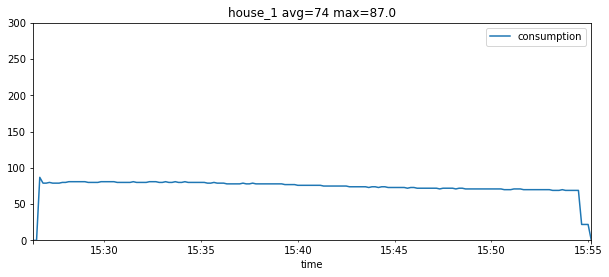

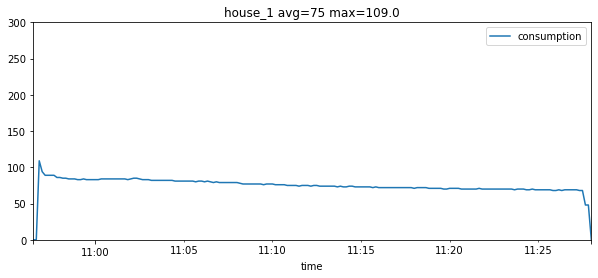

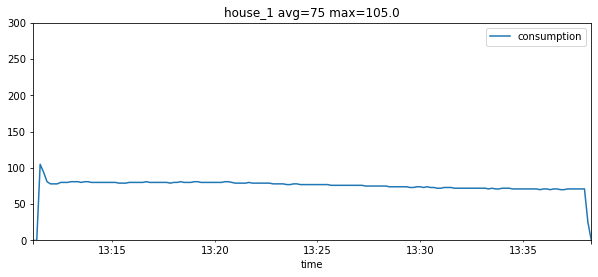

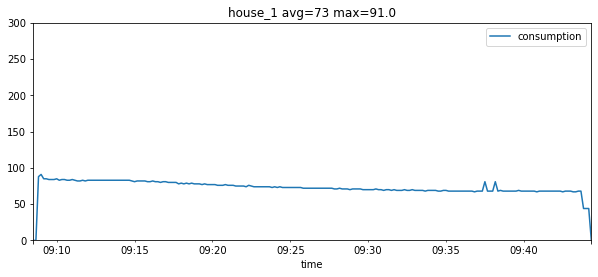

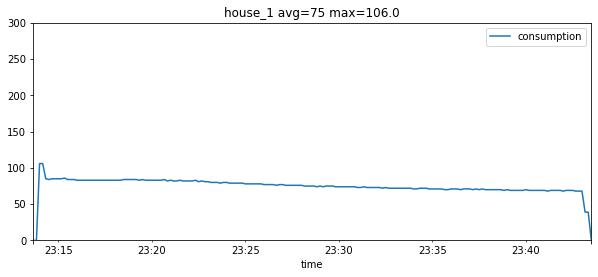

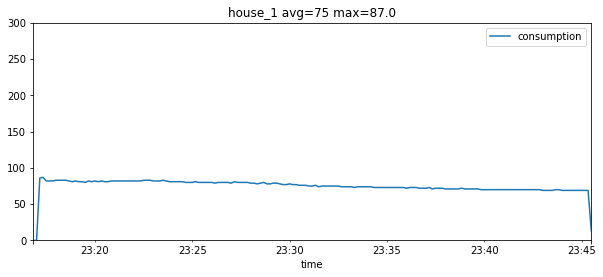

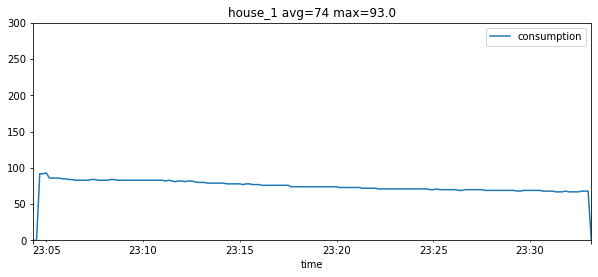

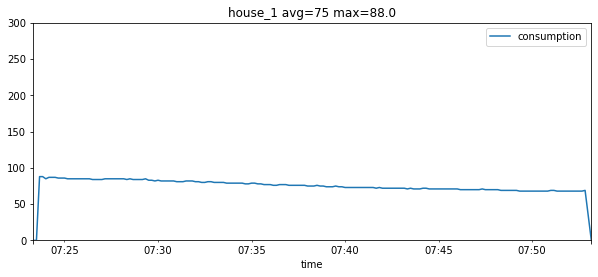

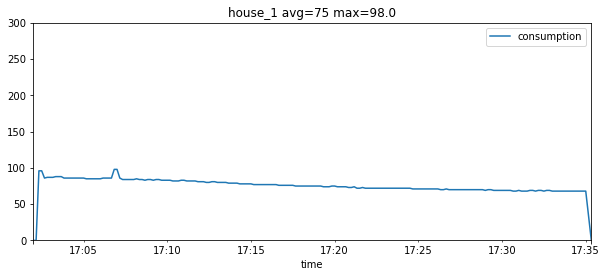

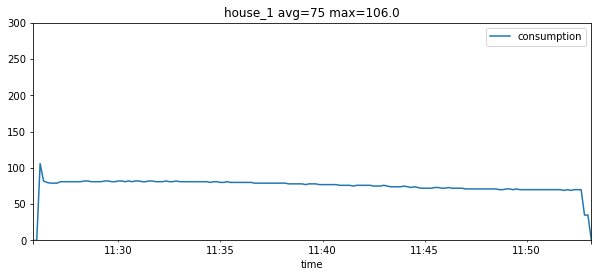

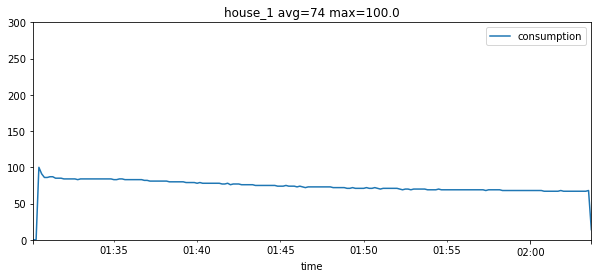

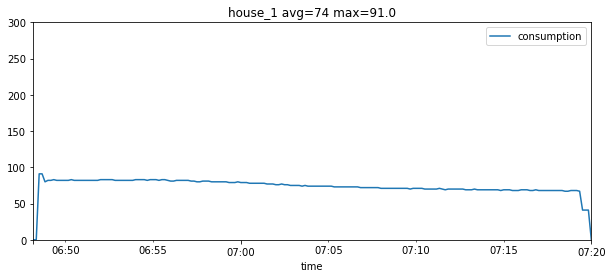

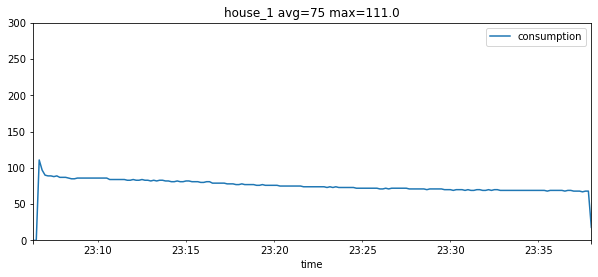

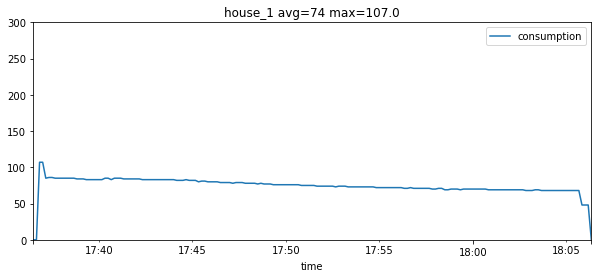

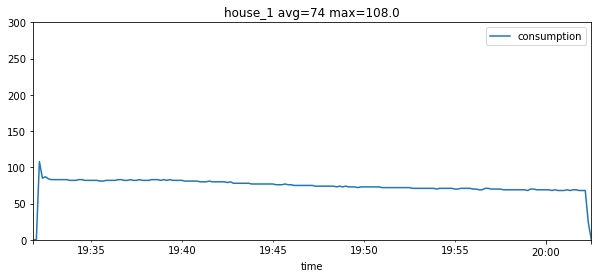

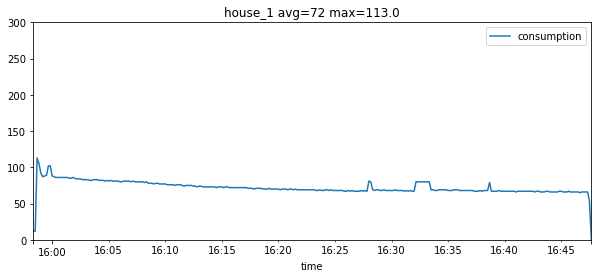

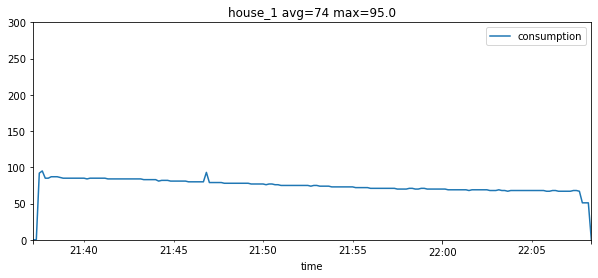

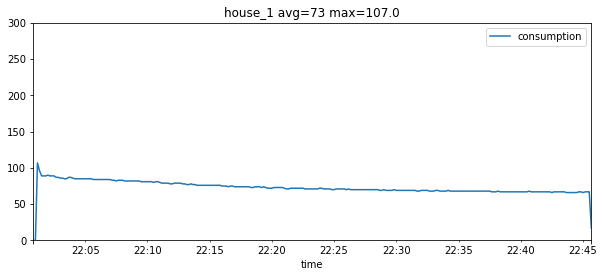

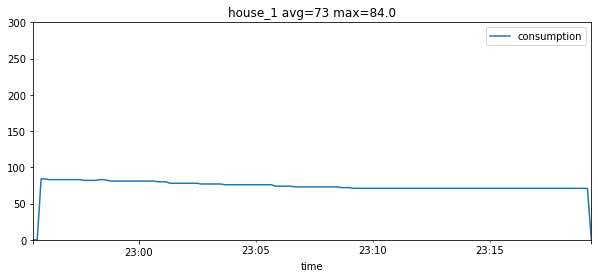

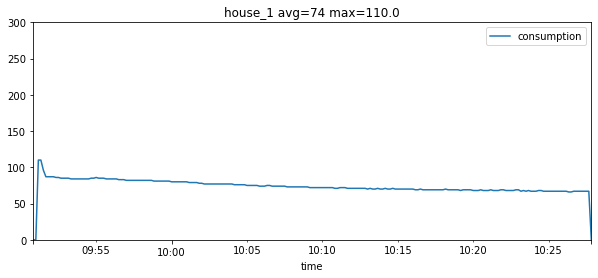

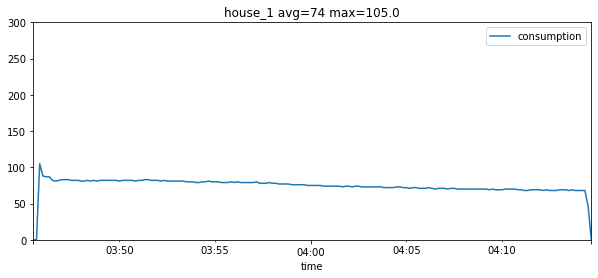

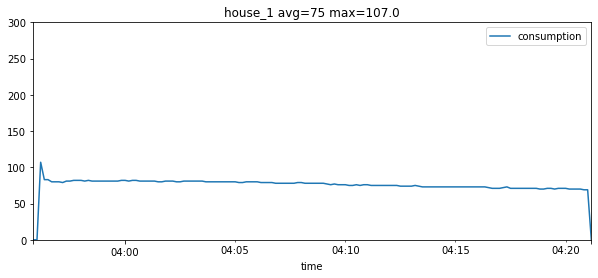

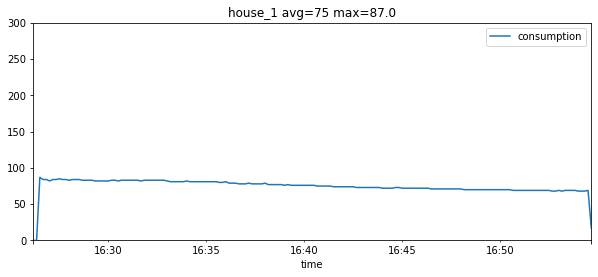

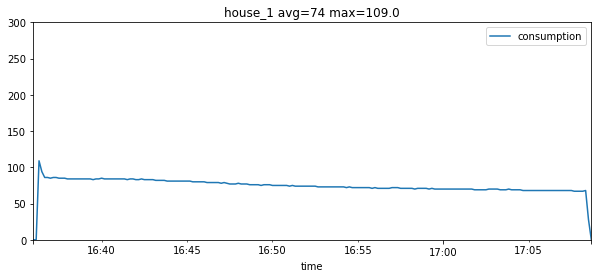

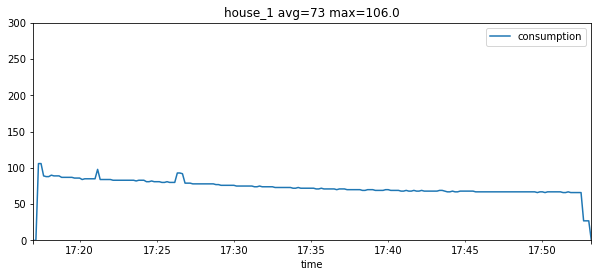

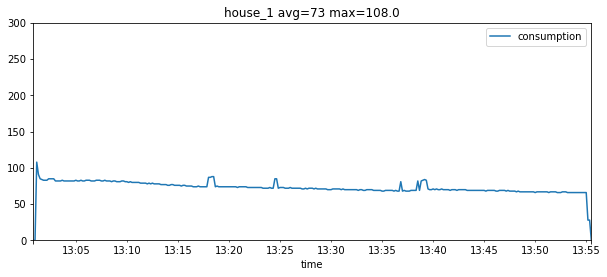

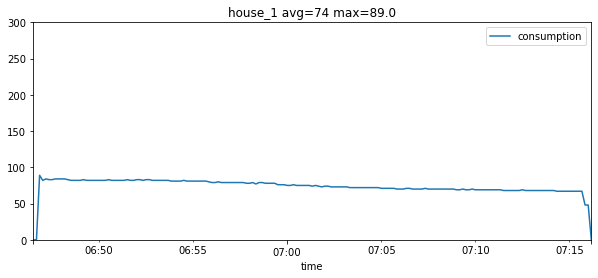

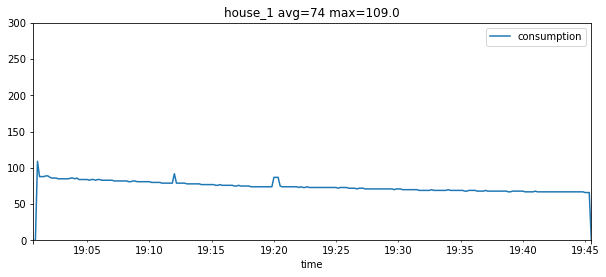

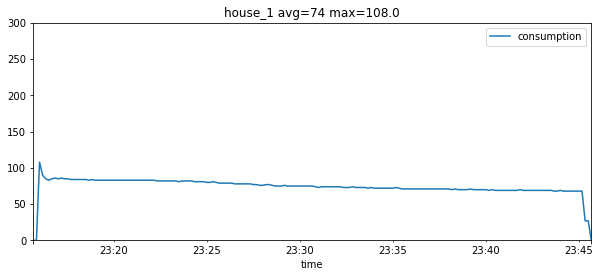

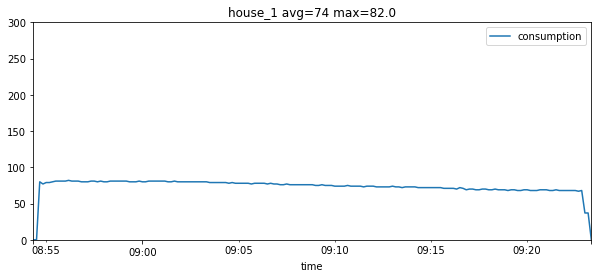

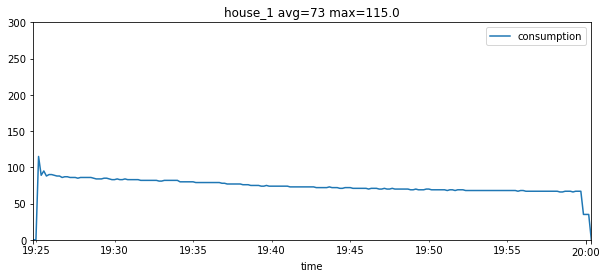

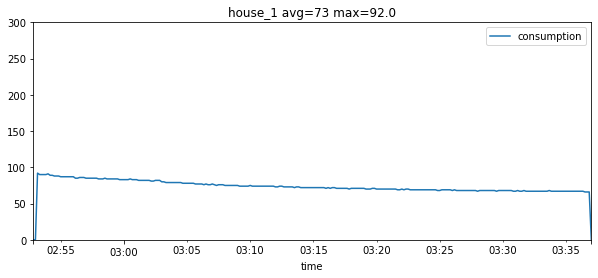

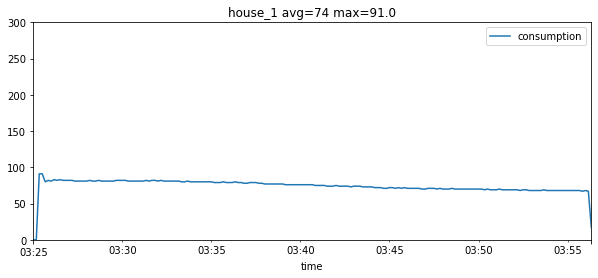

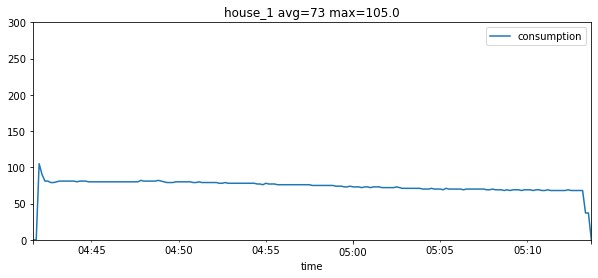

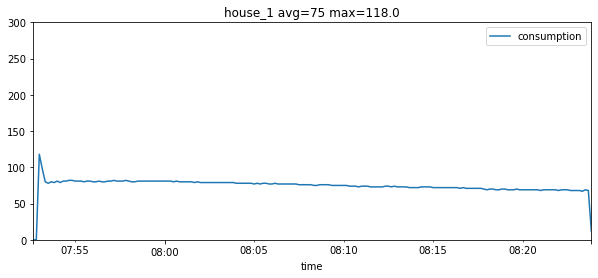

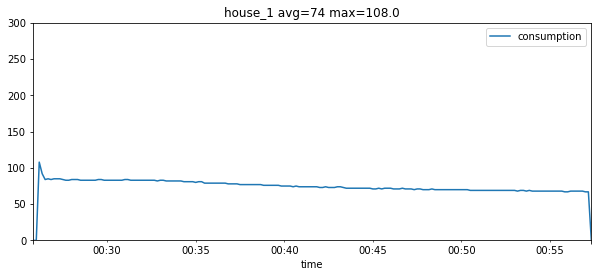

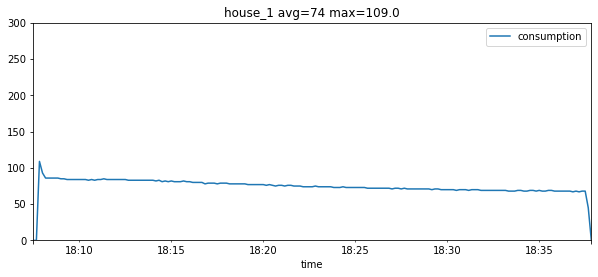

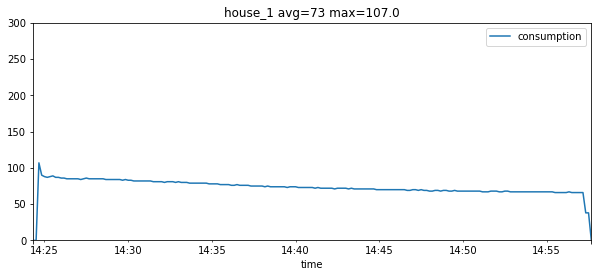

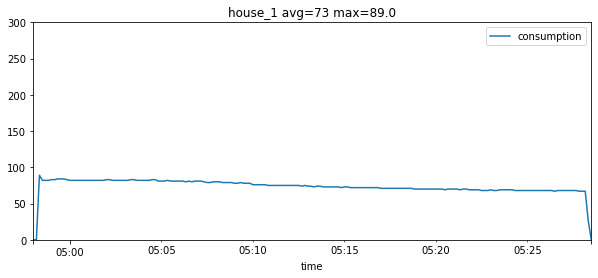

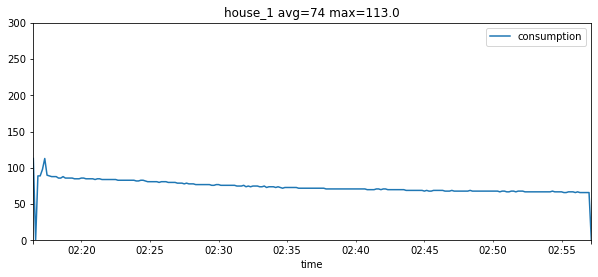

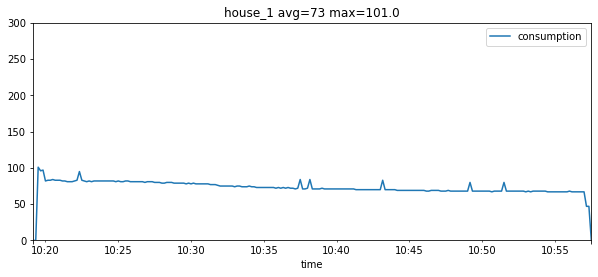

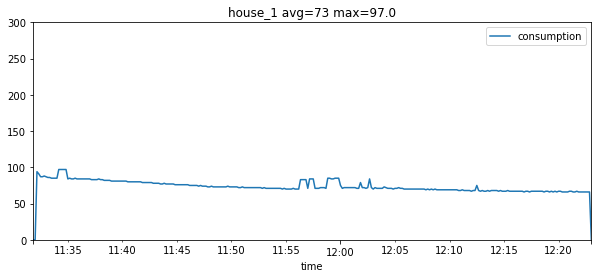

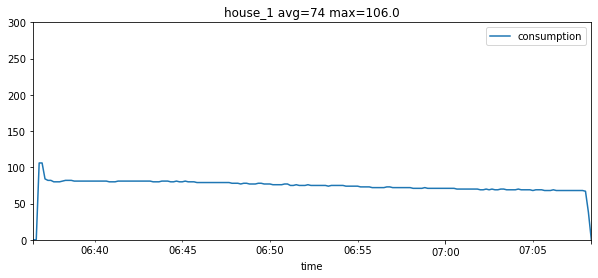

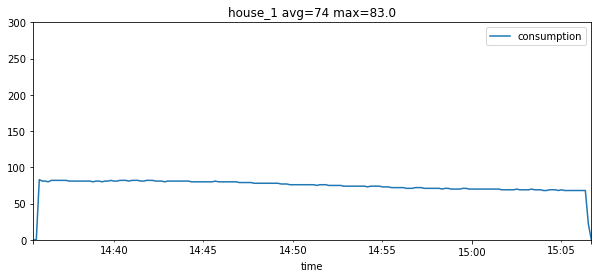

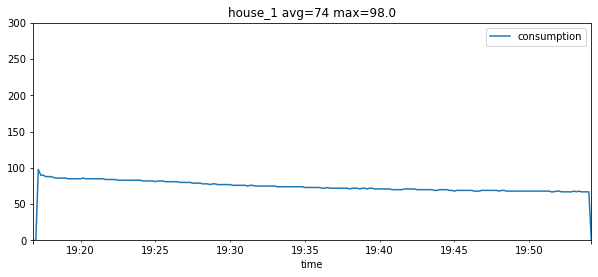

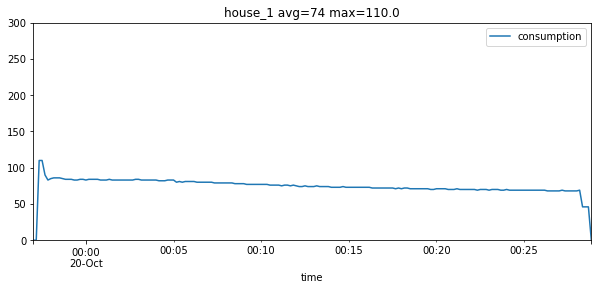

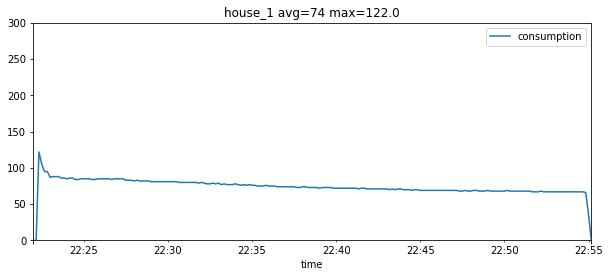

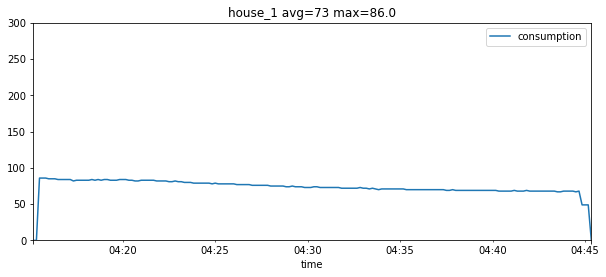

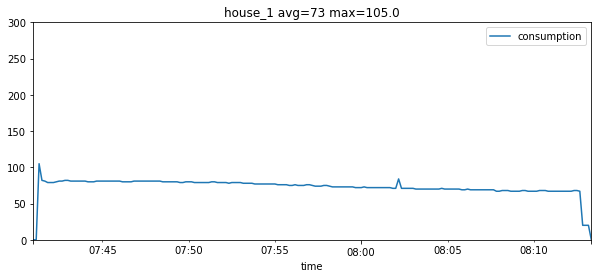

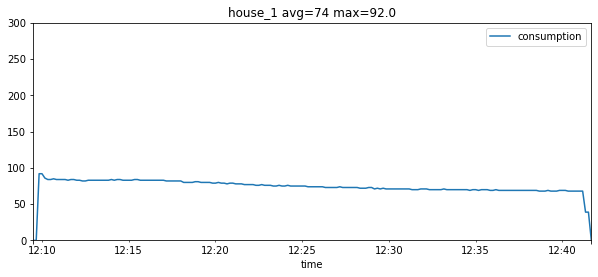

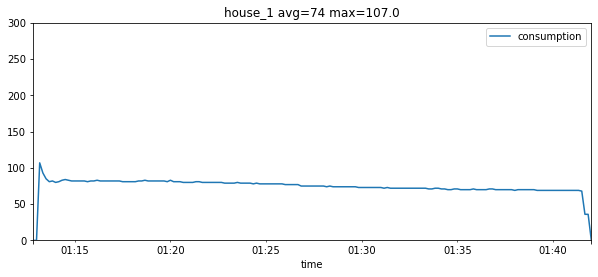

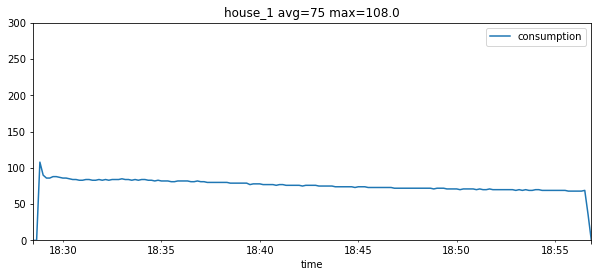

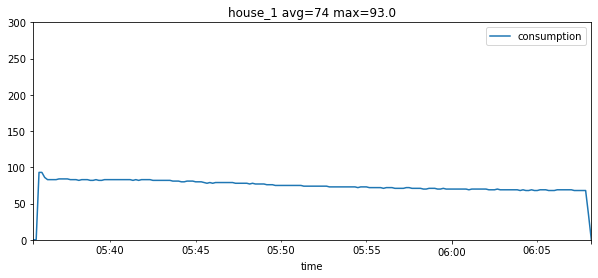

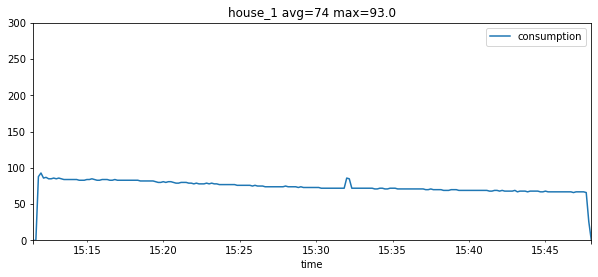

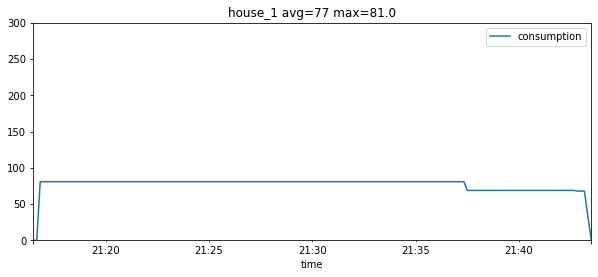

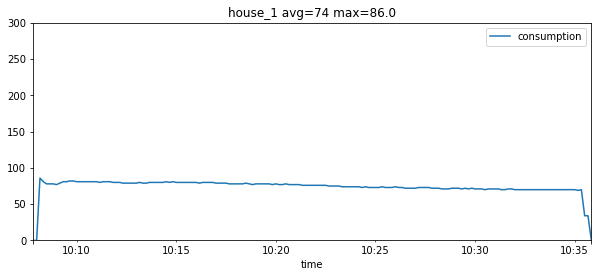

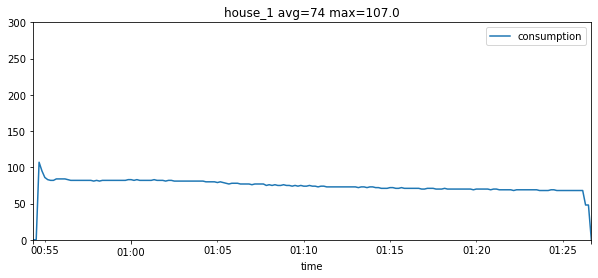

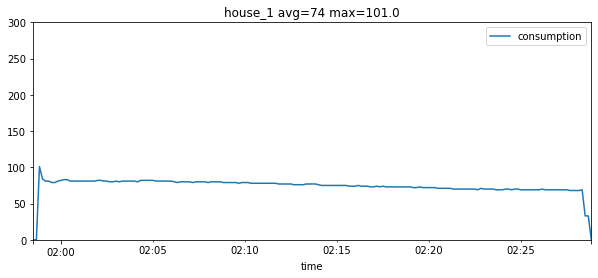

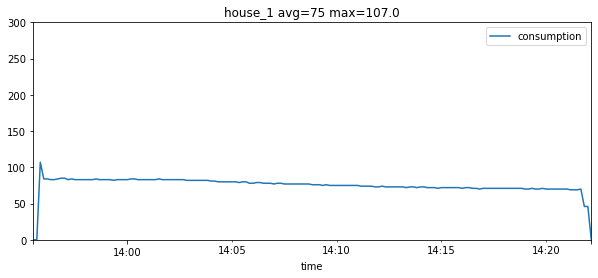

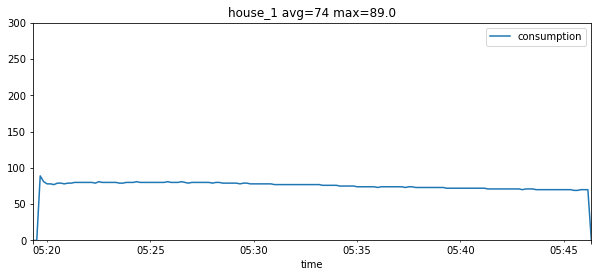

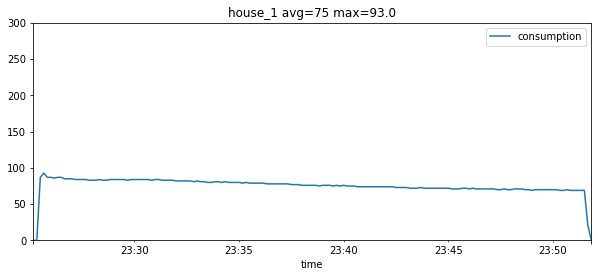

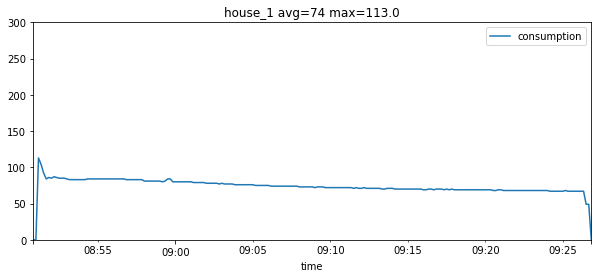

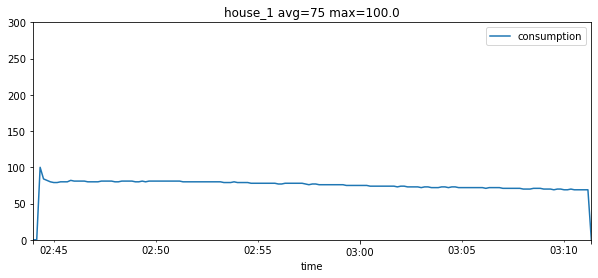

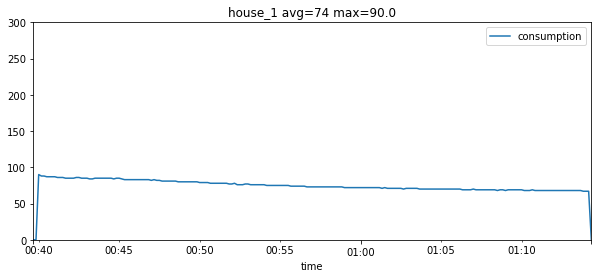

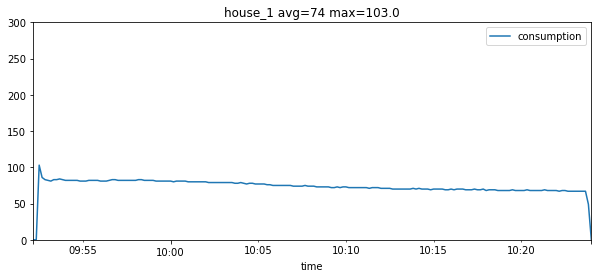

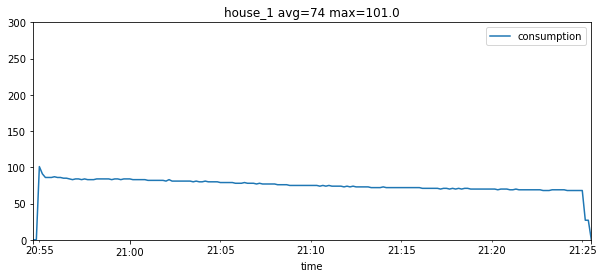

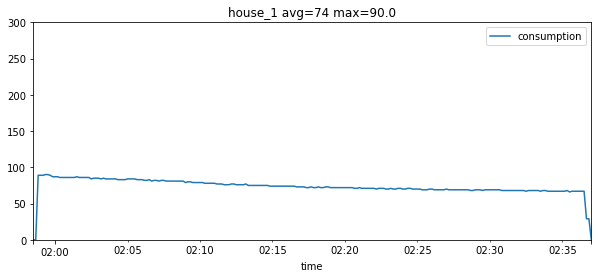

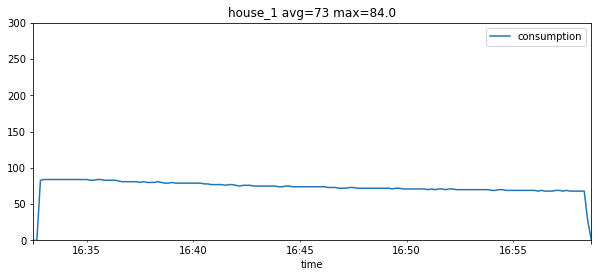

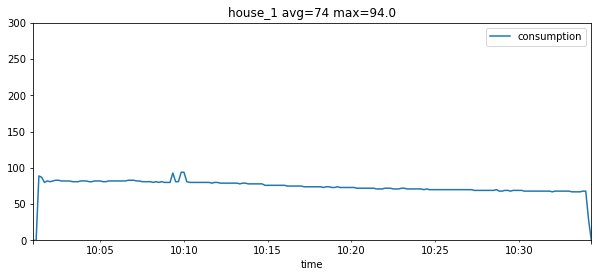

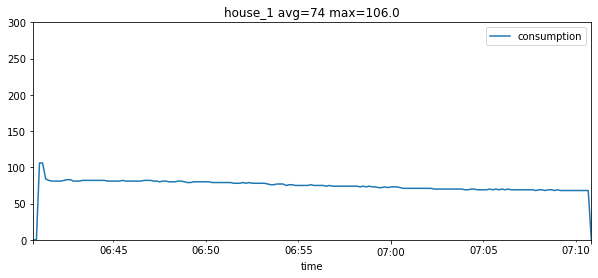

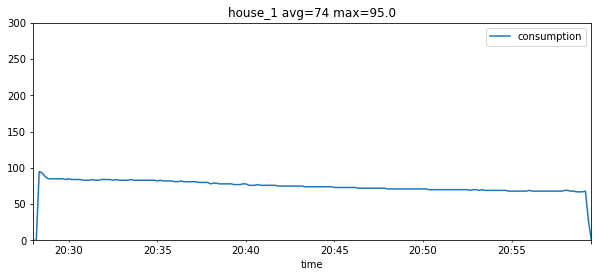

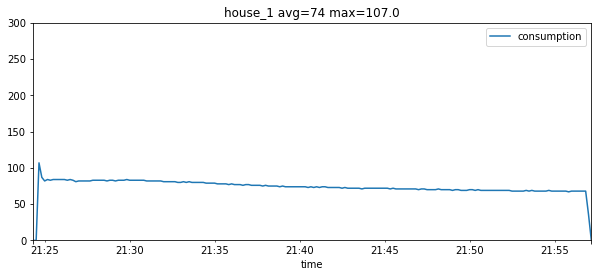

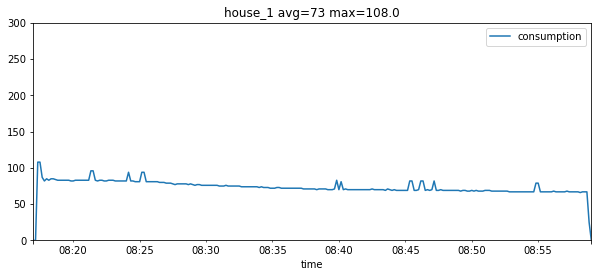

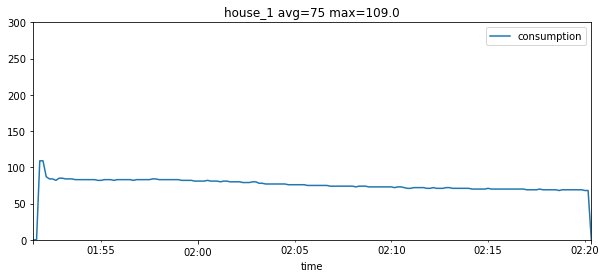

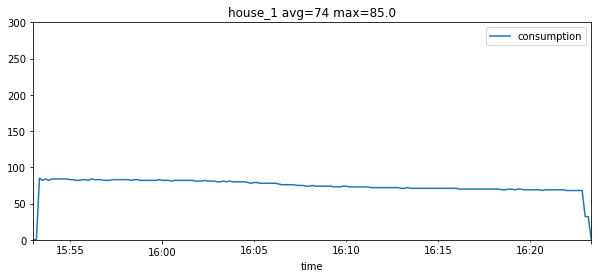

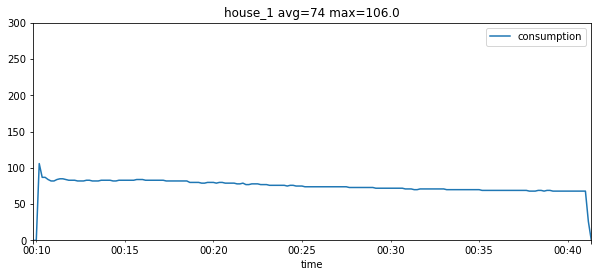

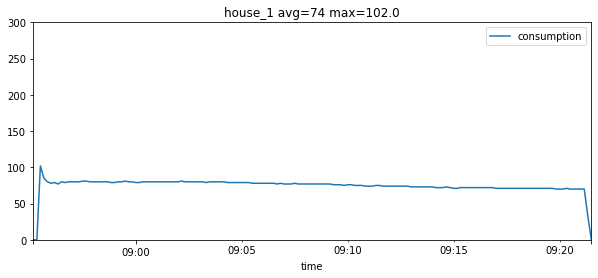

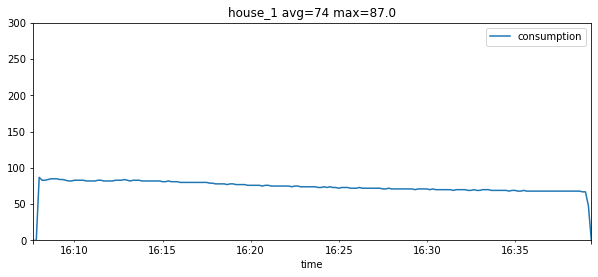

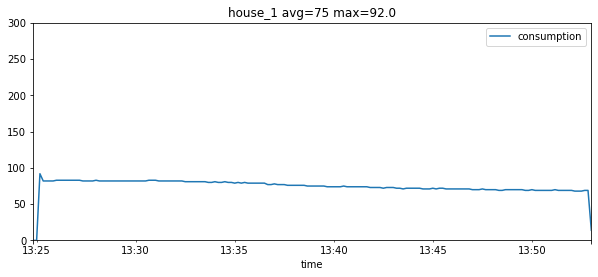

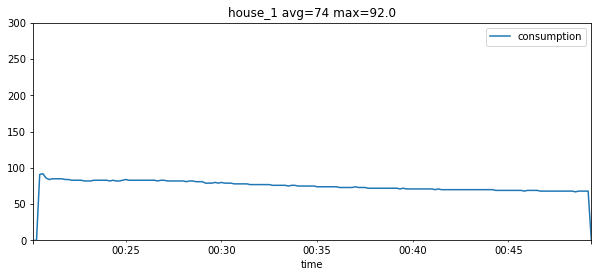

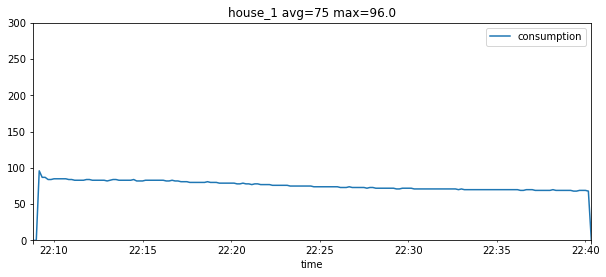

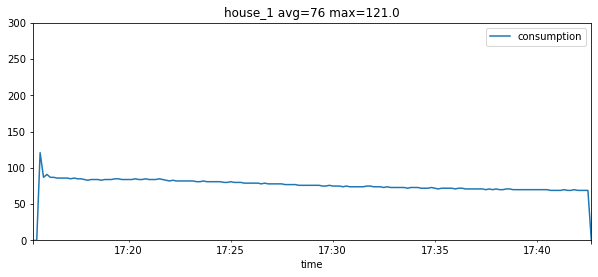

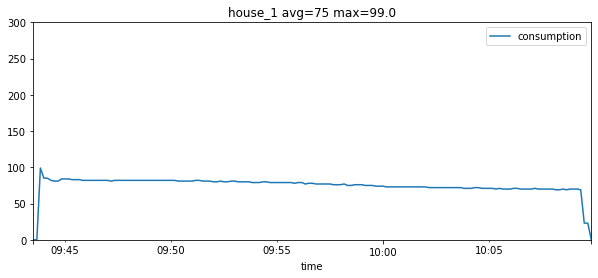

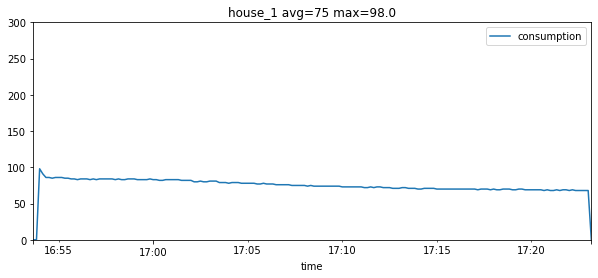

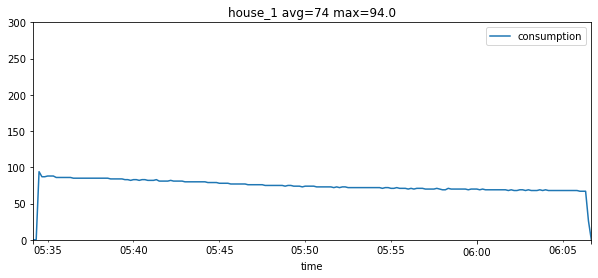

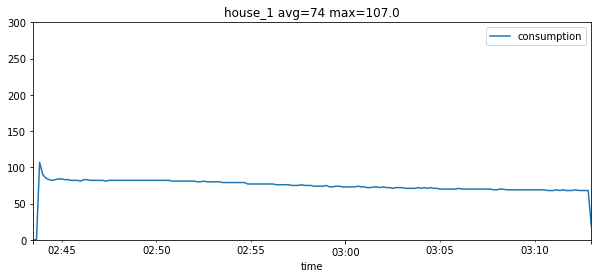

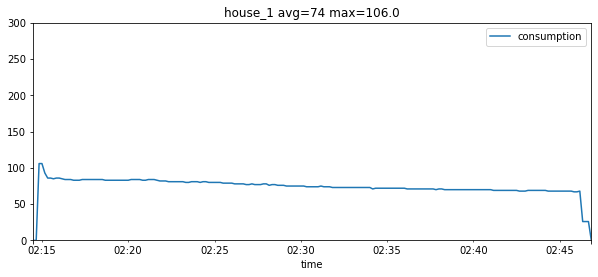

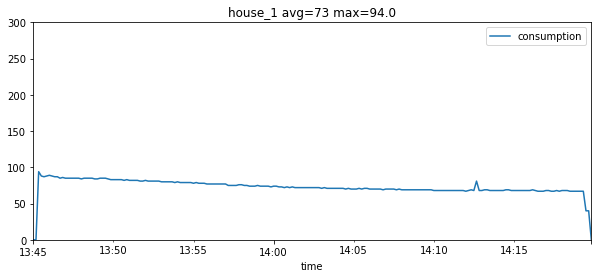

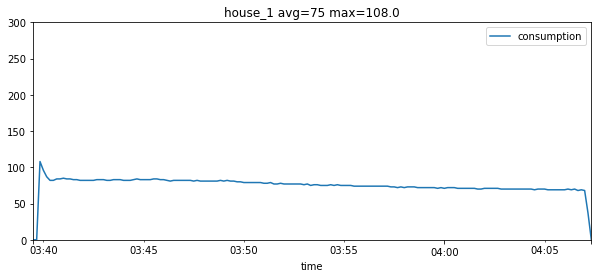

In [74]:
house=1
activations=random.sample(range(0, len(Refit_fridge_normal_activations[house])),100)
df=Refit_fridges[house]
for activation in activations:
    beginning=Refit_fridge_normal_activations[house][activation][0]
    end=Refit_fridge_normal_activations[house][activation][1]
    avg=sum(df.consumption.iloc[beginning:end])/len(df.consumption.iloc[beginning:end])
    maximus=max(df.consumption.iloc[beginning:end])
    ax=df.iloc[beginning:end].plot(x="time",y=['consumption'], figsize=(10,4),title="house_"+str(house)+" avg="+str(round(avg))+" max="+str(maximus))
    ax.set_ylim(0,300)

/home/mahdi/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


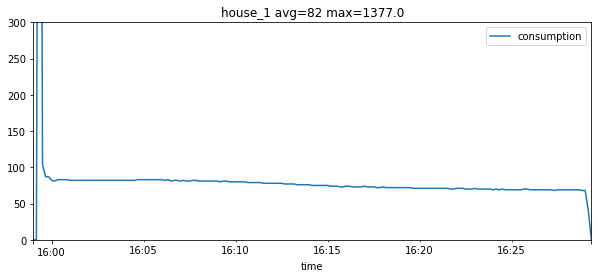

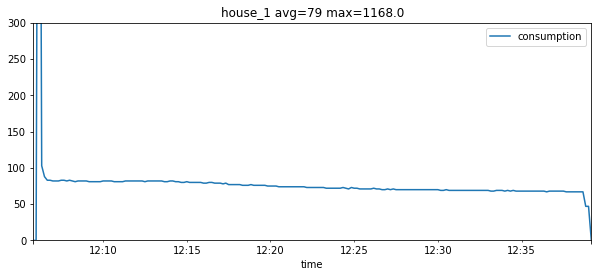

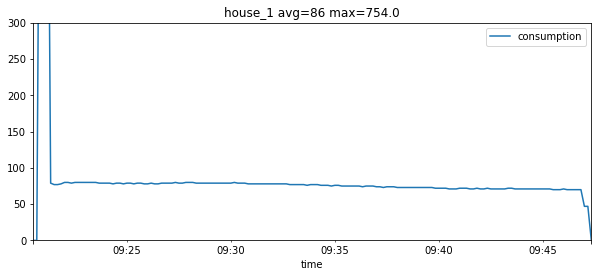

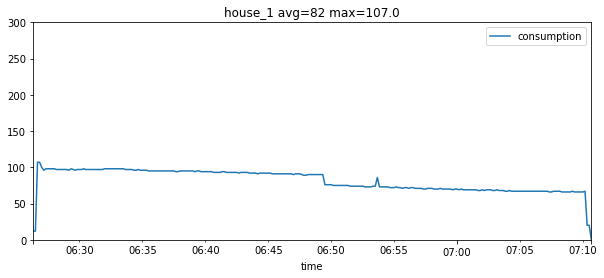

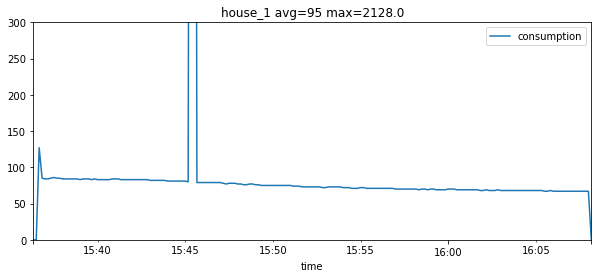

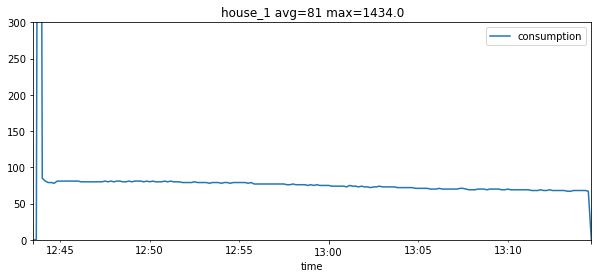

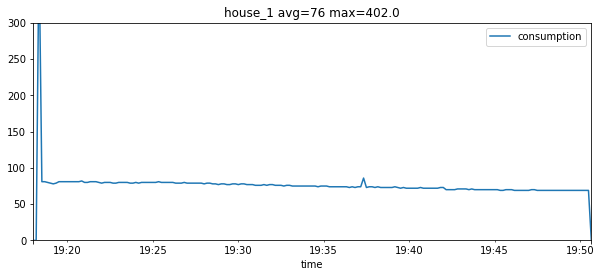

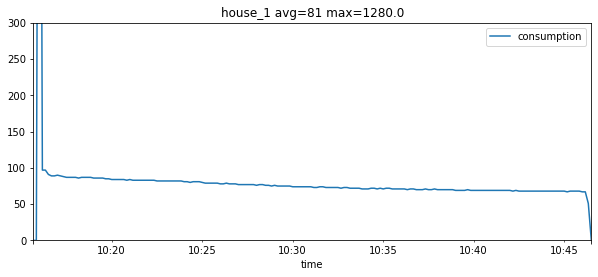

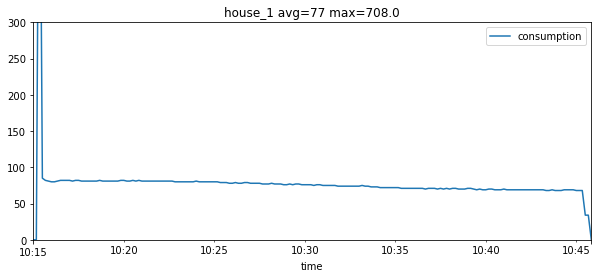

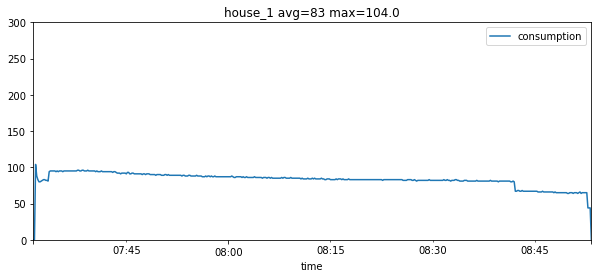

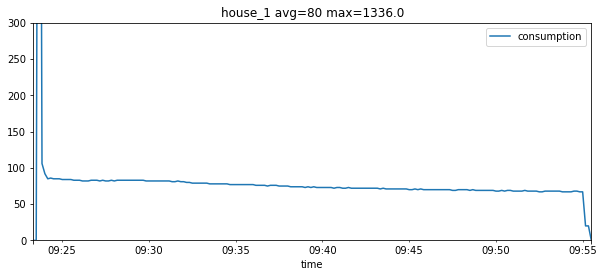

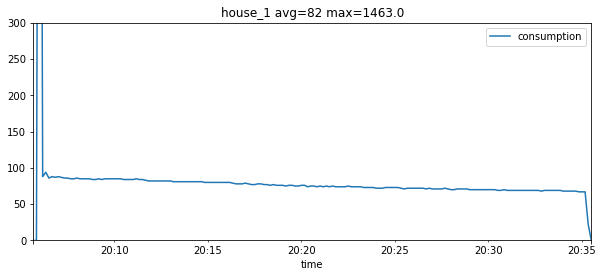

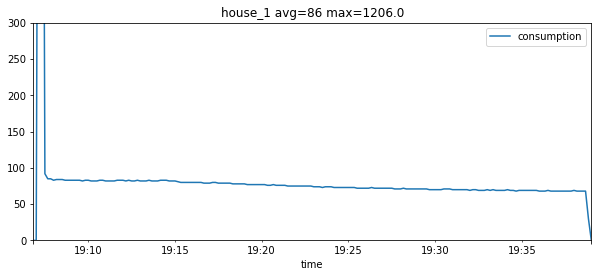

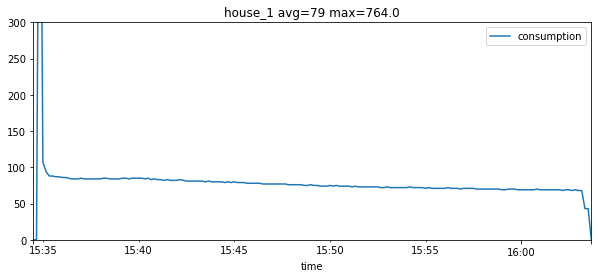

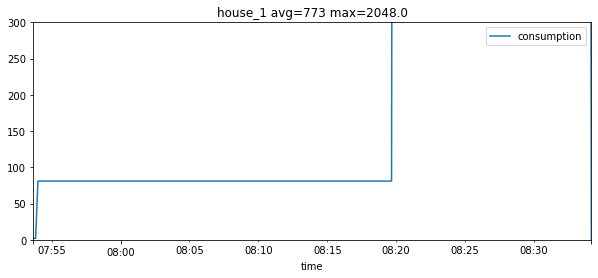

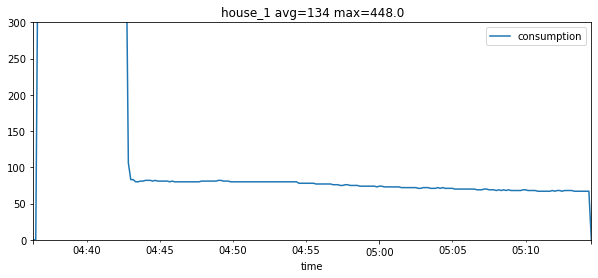

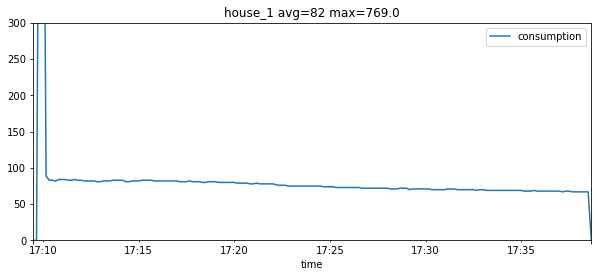

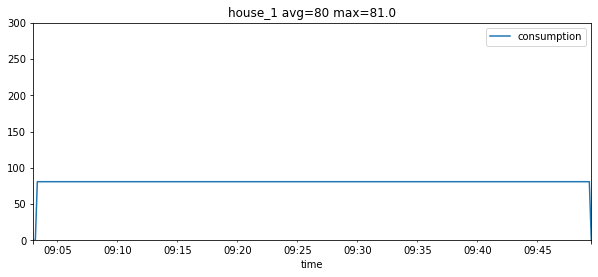

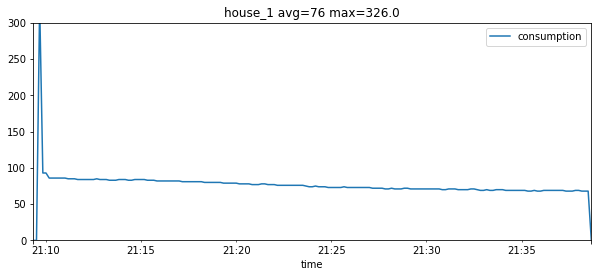

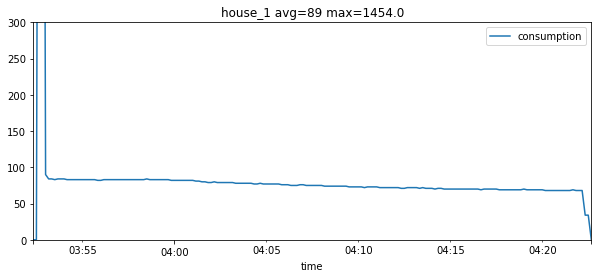

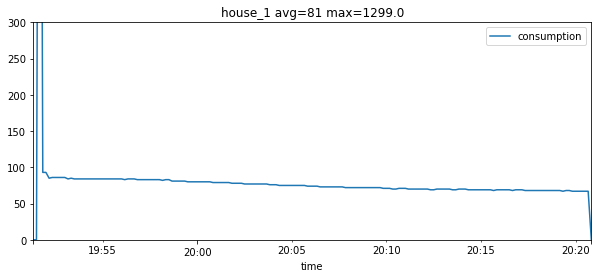

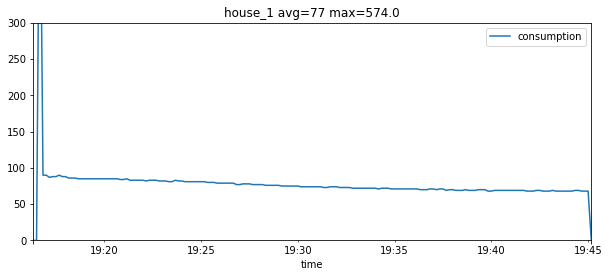

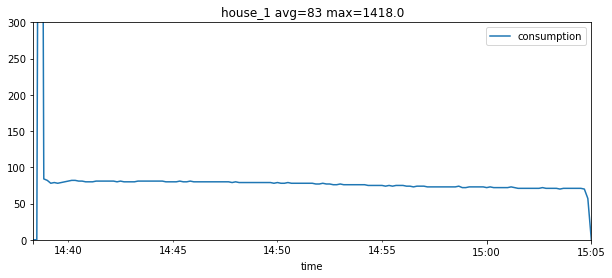

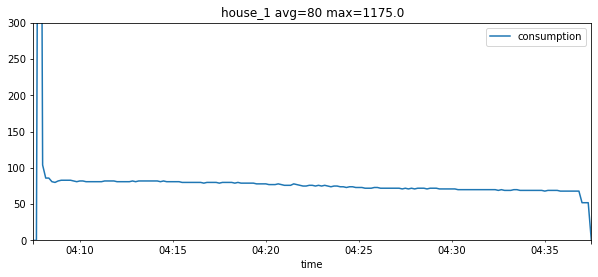

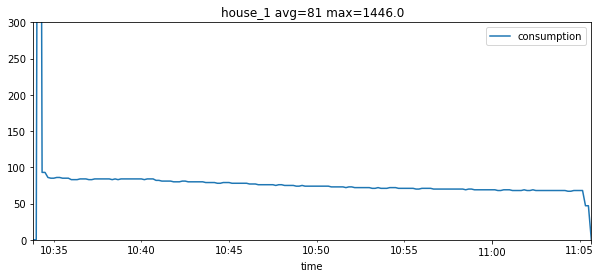

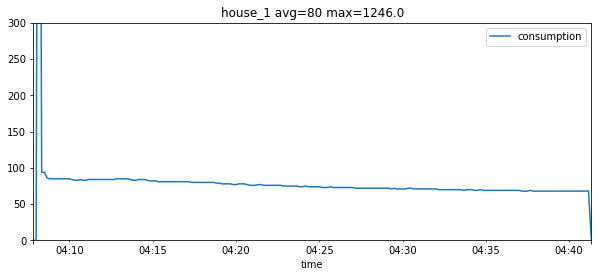

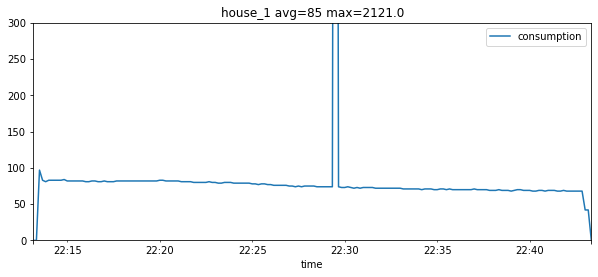

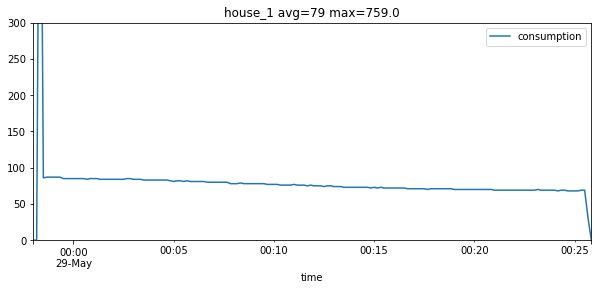

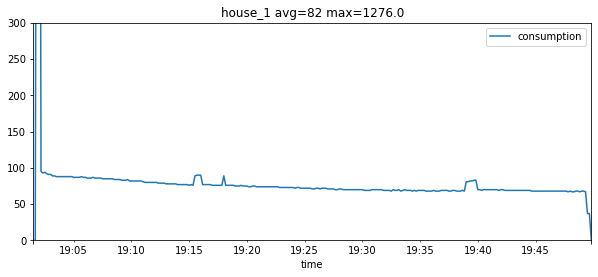

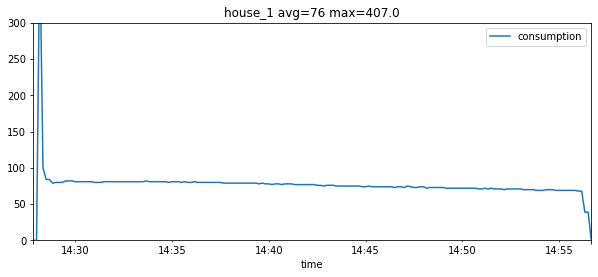

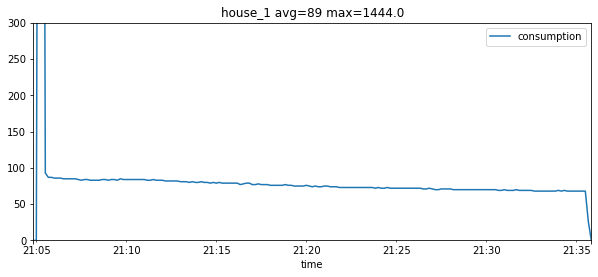

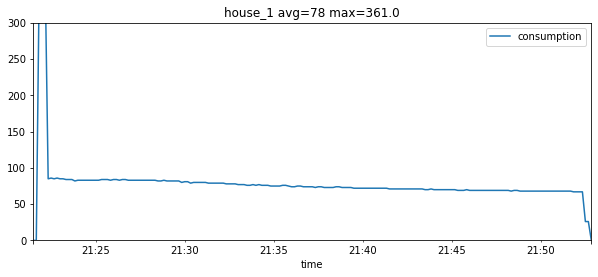

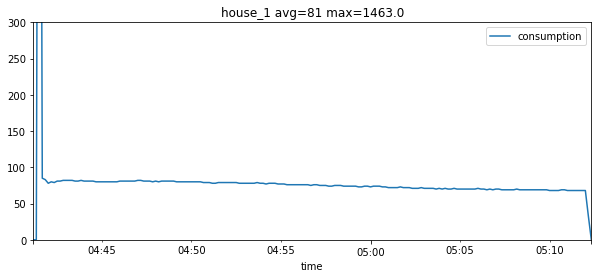

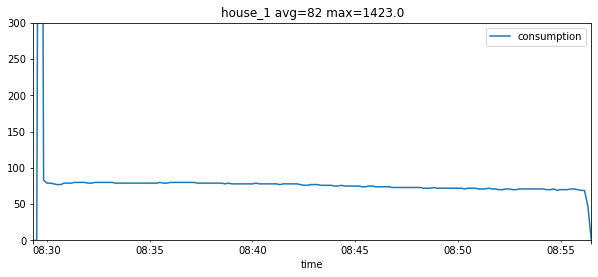

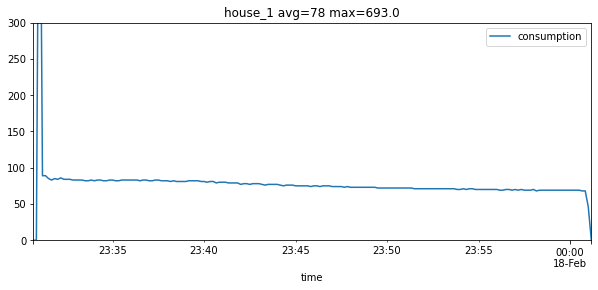

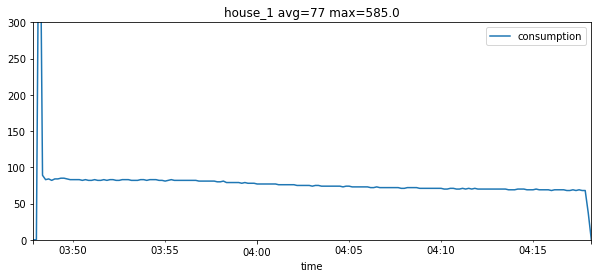

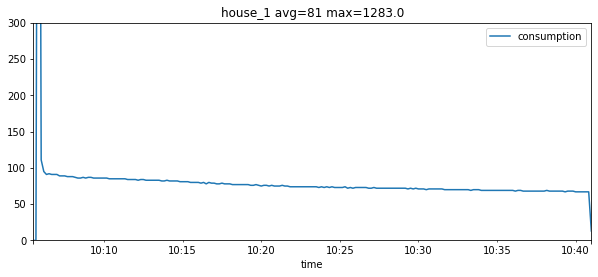

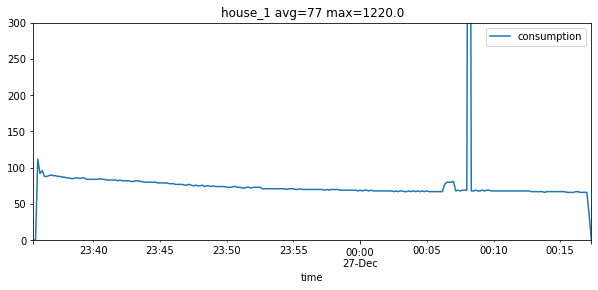

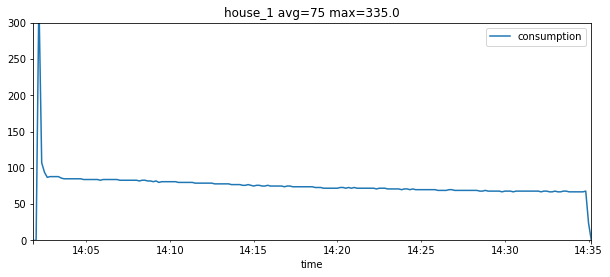

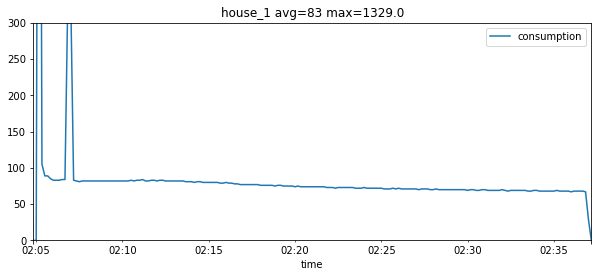

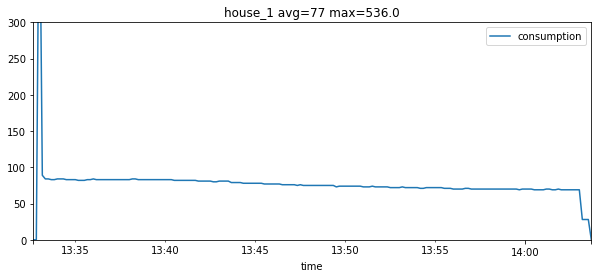

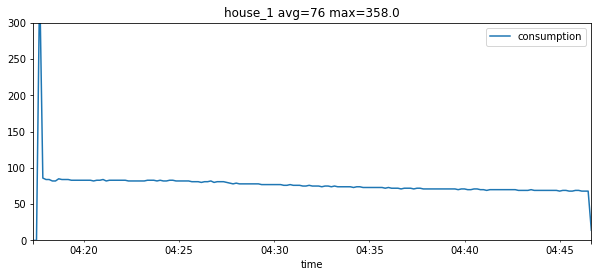

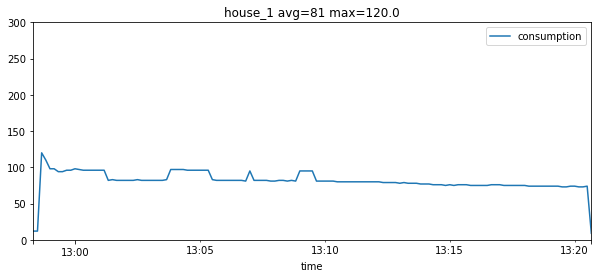

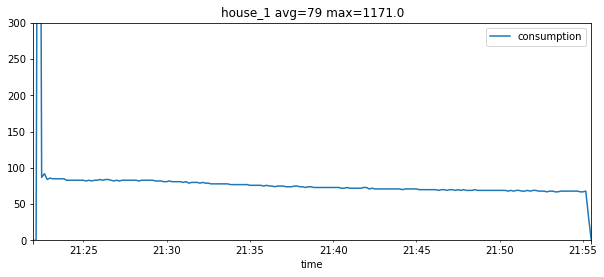

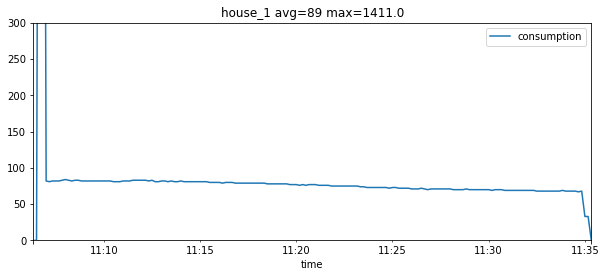

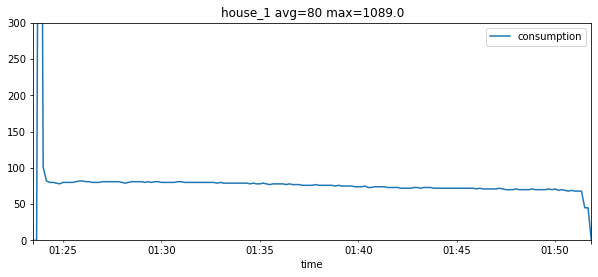

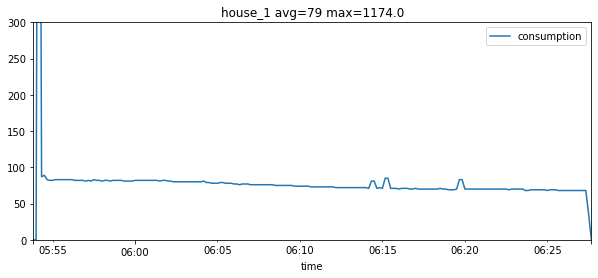

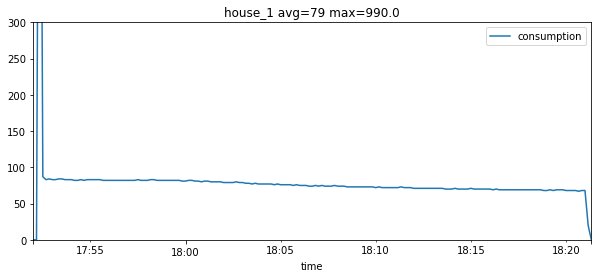

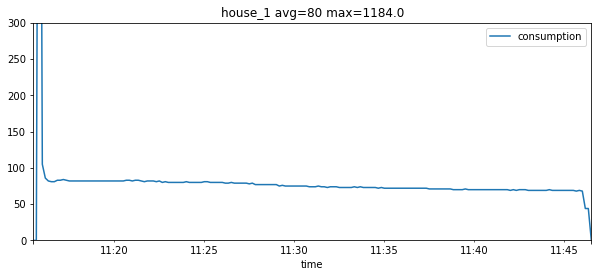

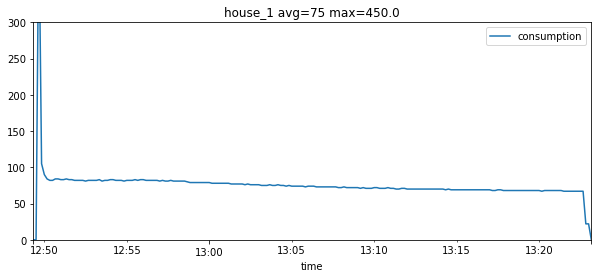

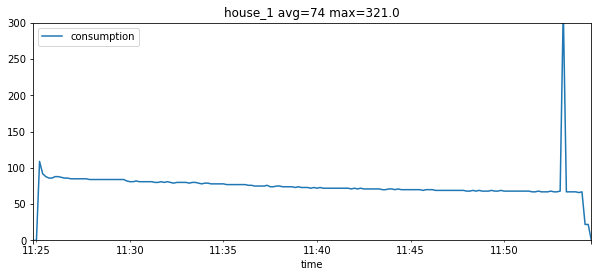

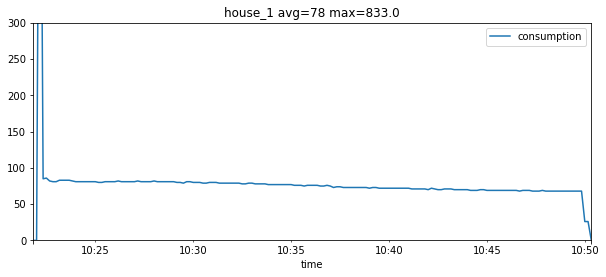

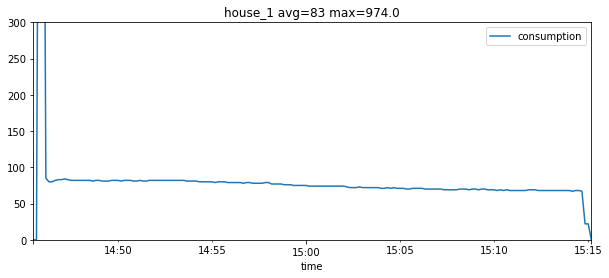

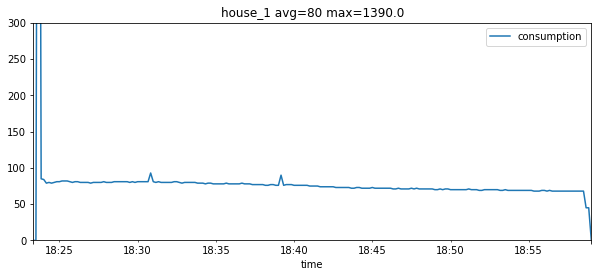

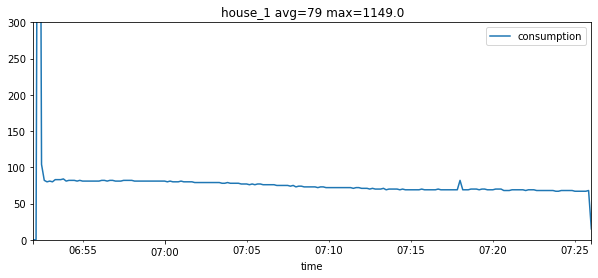

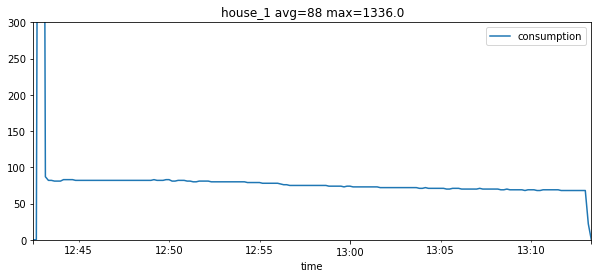

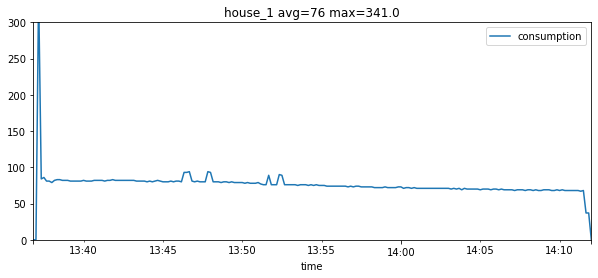

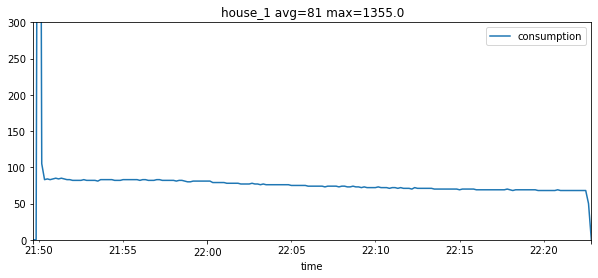

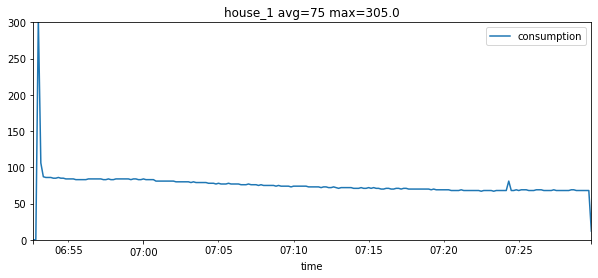

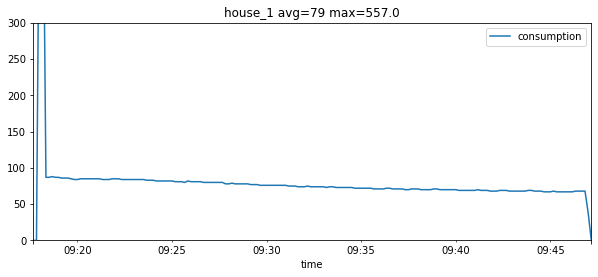

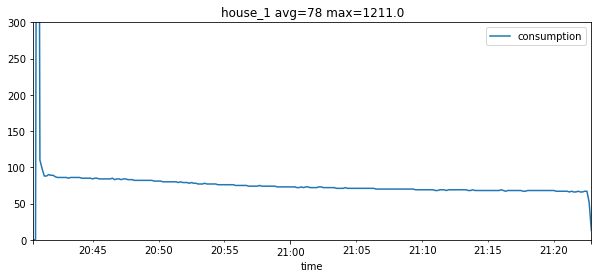

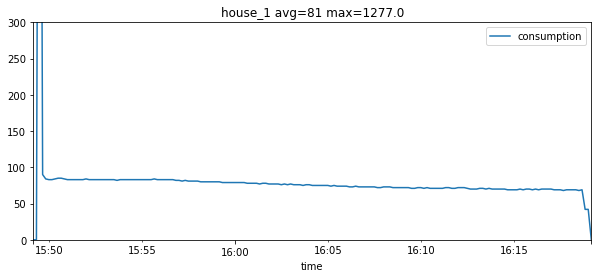

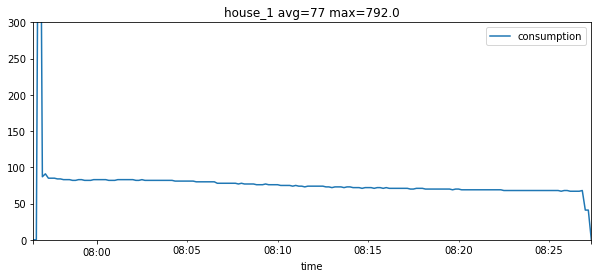

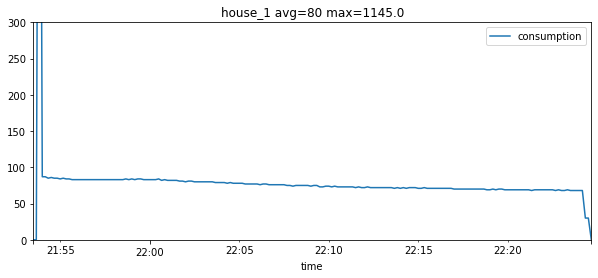

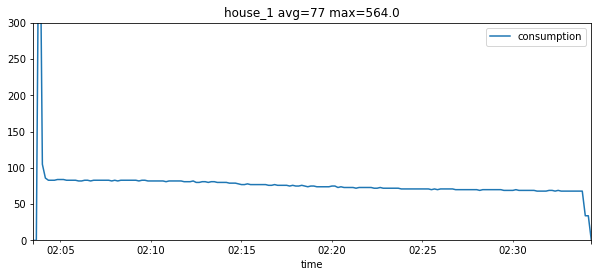

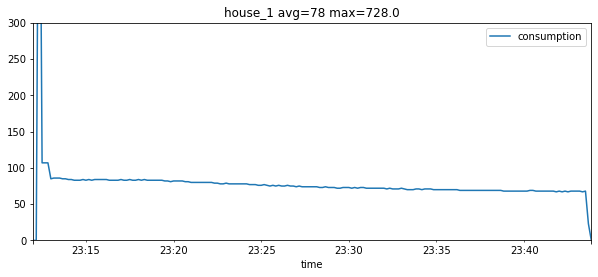

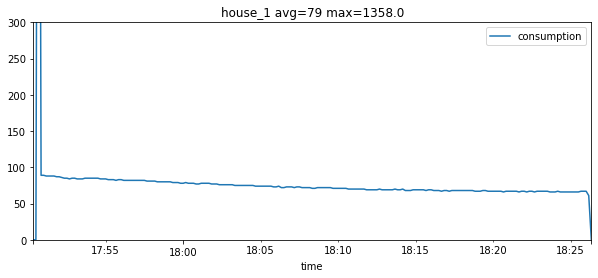

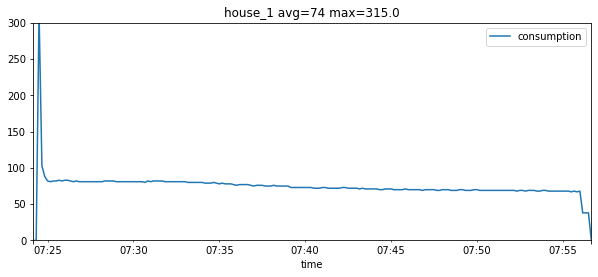

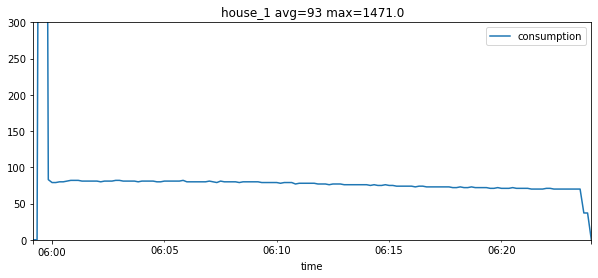

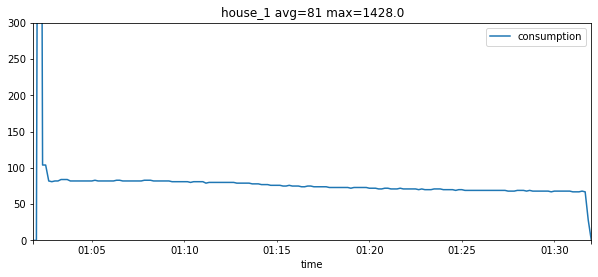

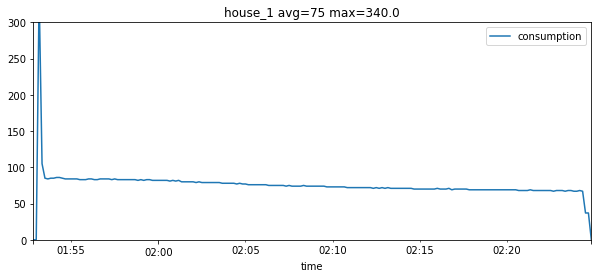

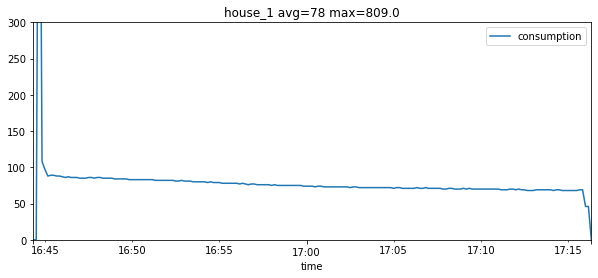

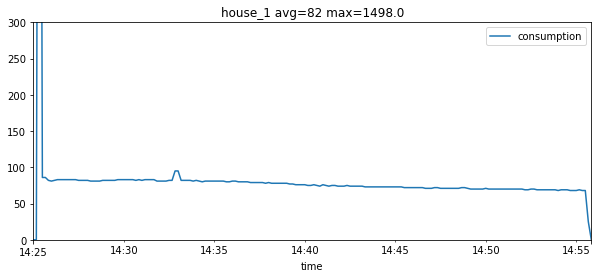

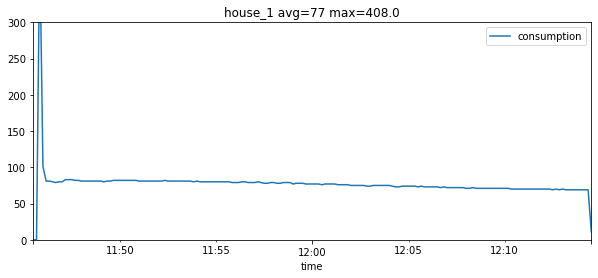

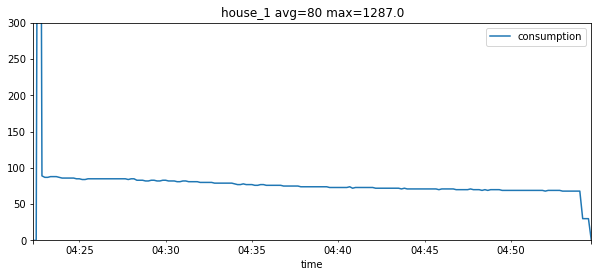

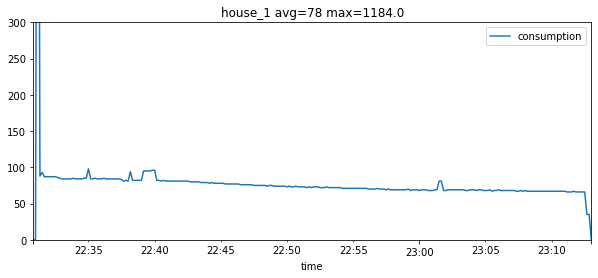

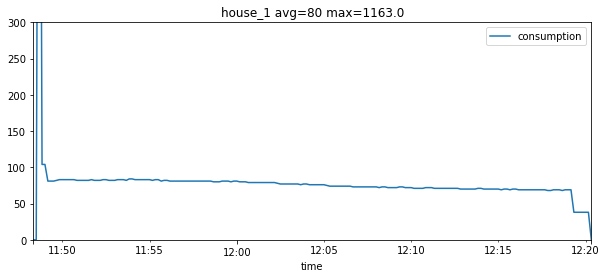

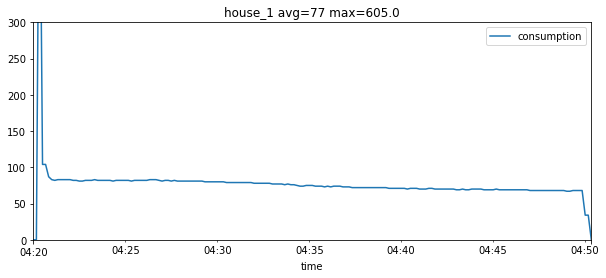

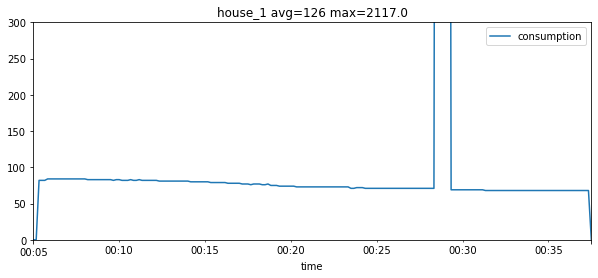

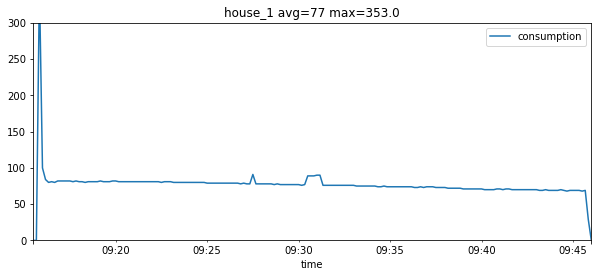

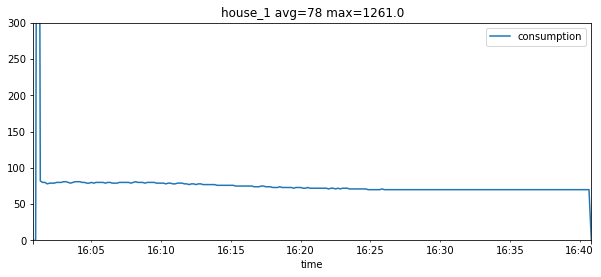

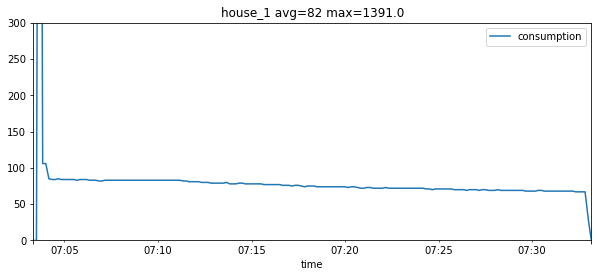

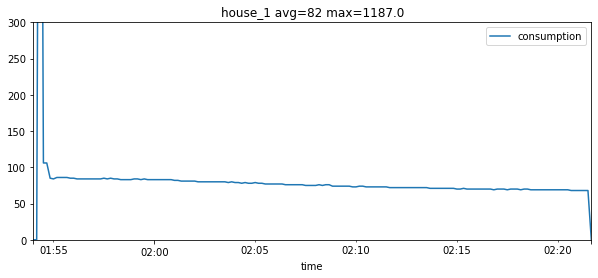

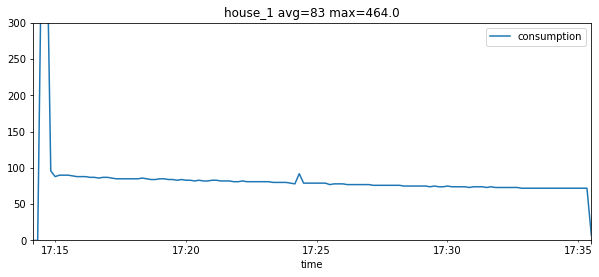

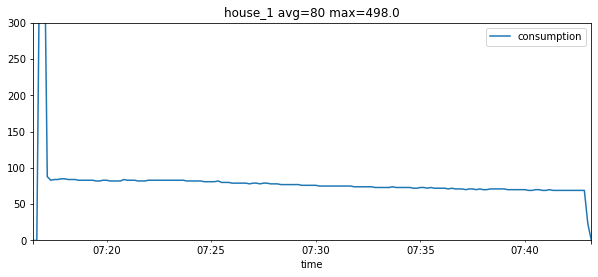

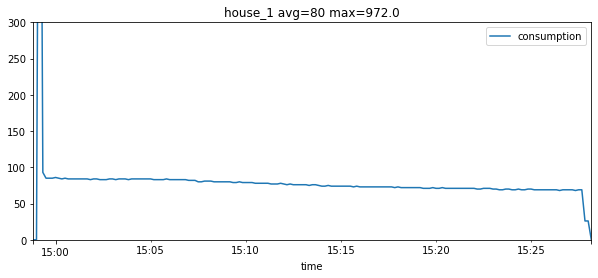

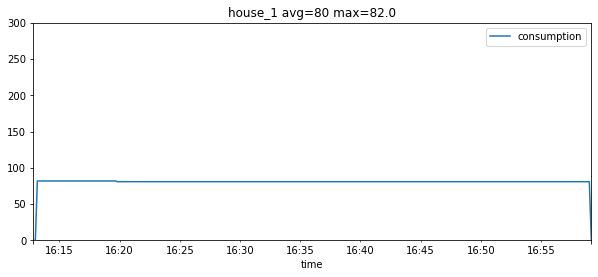

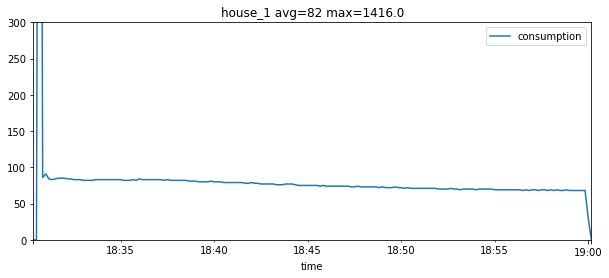

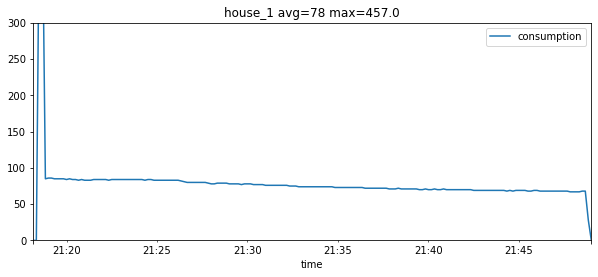

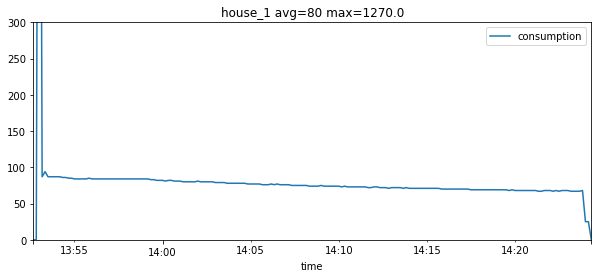

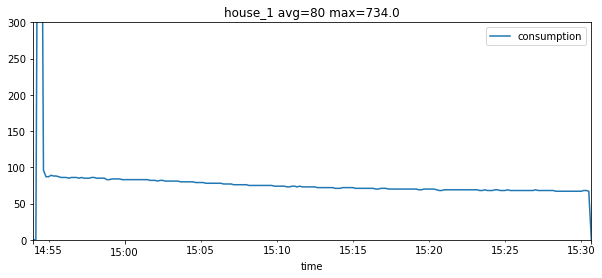

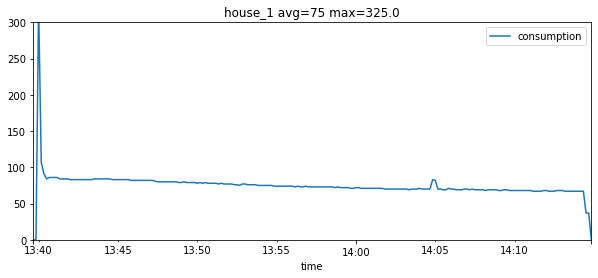

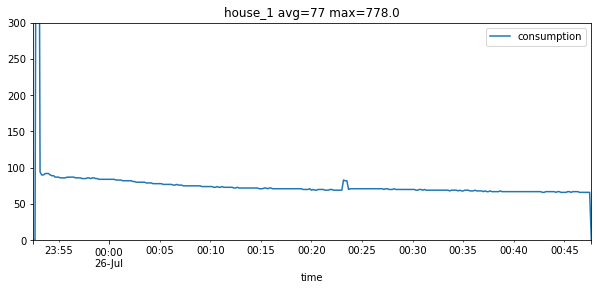

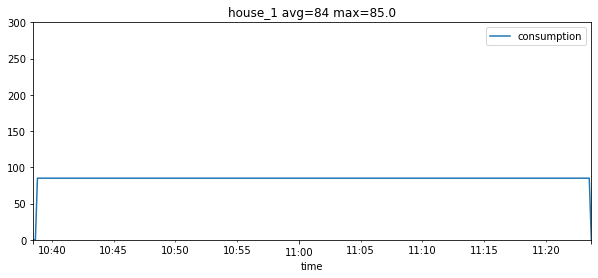

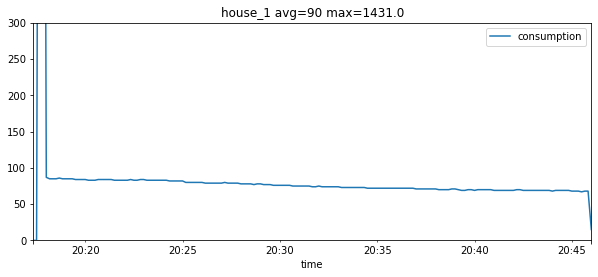

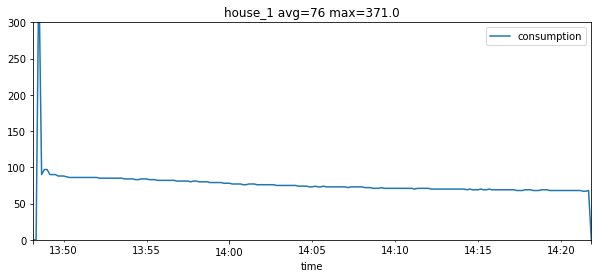

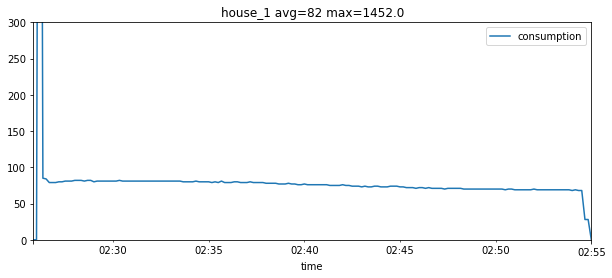

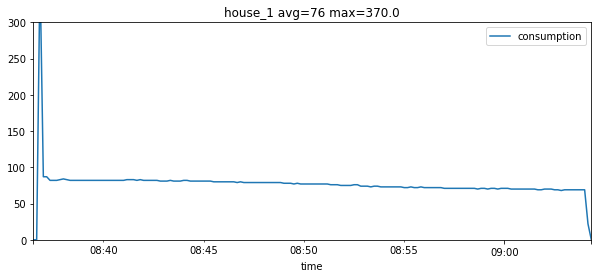

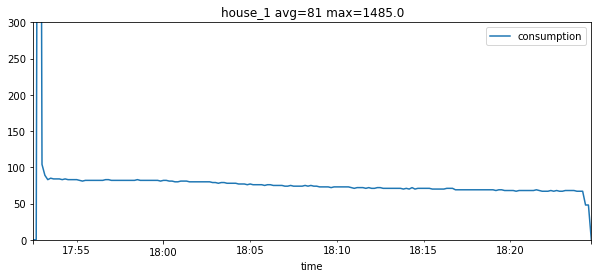

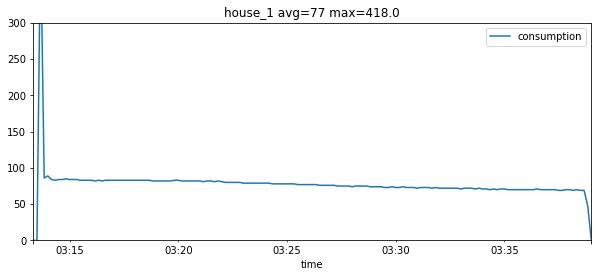

In [75]:
house=1
activations=random.sample(range(0, len(Refit_fridge_anomolous_activations[house])),100)
df=Refit_fridges[house]
for activation in activations:
    beginning=Refit_fridge_anomolous_activations[house][activation][0]
    end=Refit_fridge_anomolous_activations[house][activation][1]
    avg=sum(df.consumption.iloc[beginning:end])/len(df.consumption.iloc[beginning:end])
    maximus=max(df.consumption.iloc[beginning:end])
    ax=df.iloc[beginning:end].plot(x="time",y=['consumption'], figsize=(10,4),title="house_"+str(house)+" avg="+str(round(avg))+" max="+str(maximus))
    ax.set_ylim(0,300)

In [5]:
def get_activation_type(activations,normal_activations,house_nb):
    activation_type=[]
    for activation in activations:
        if activation in normal_activations:
            activation_type.append(0)
        else:
            activation_type.append(1)
    return(activation_type,house_nb)

In [22]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_activation_type,((Refit_fridge_activations[i],Refit_fridge_normal_activations[i],i) for i in Refit_fridge_normal_activations.keys() ))

In [23]:
duration_anomolous_activations={}
for i in range(len(result)):
        duration_anomolous_activations[result[i][1]]=result[i][0]

In [84]:
def activations_to_csv(activations,activation_type,house_nb):
    df=pd.DataFrame(activations, columns =['beginning','end'])
    df1 = pd.DataFrame(activation_type, columns =['label'])
    df_row = pd.concat([df, df1],axis=1)
    df_row.to_csv("Refit_activations/labels/fridge_duration/house_"+str(house_nb),index=False)

In [5]:
for i in Refit_fridge_activation_type.keys():
    activations_to_csv(Refit_fridge_activations[i],Refit_fridge_activation_type[i],i)

NameError: name 'Refit_fridge_activation_type' is not defined

In [42]:
def get_durations(activations):
    durations=[]
    for activation in activations:
        durations.append(round((activation[1]-activation[0])/6))
    return (durations)

In [43]:
Refit_fridges_durations=[]
for house in Refit_fridges.keys():
    Refit_fridges_durations.append(get_durations(Refit_fridge_normal_activations[house]))

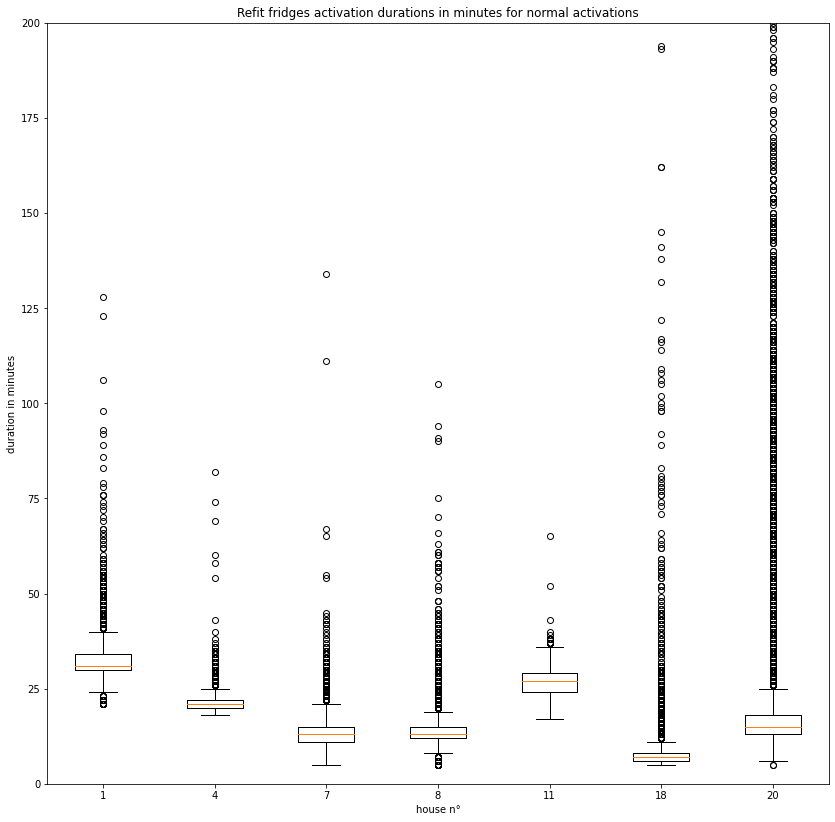

In [44]:
fig7, ax7 = plt.subplots(figsize=(14,14))
ax7.set_title('Refit fridges activation durations in minutes for normal activations')
ax7.boxplot(Refit_fridges_durations)
ax7.set_ylim(0,200)
ax7.set_xticklabels(Refit_fridges.keys())
plt.ylabel("duration in minutes")
plt.xlabel("house n°")
plt.savefig('Refit_fridges_max-avg_normal_activation_durations_in_minutes.jpg',dpi=184)

plt.show()

In [37]:
def csv_to_activations(file_title):
    df=pd.read_table(file_title, sep="," )
    df = df[['beginning', 'end','label']]
    activation = [tuple(x[0:2]) for x in df.to_numpy()]
    activation_type = [x[2] for x in df.to_numpy()]
    return(activation,activation_type)

In [38]:
Refit_fridge_activation_type={}
Refit_fridge_activations={}
for house_nb in range(22):
    try:
        Refit_fridge_activations[house_nb]=csv_to_activations("Refit_activations/labels/fridge/house_"+str(house_nb))[0]
        Refit_fridge_activation_type[house_nb]=csv_to_activations("Refit_activations/labels/fridge/house_"+str(house_nb))[1]
    except:
        None

In [39]:
def normal_anomolous(activations,activation_type,house_nb):
    normal_activations=[]
    anomolous_activations=[]
    for i in range(len(activations)):
        if activation_type[i]==0:
            normal_activations.append(activations[i])
        else:
            anomolous_activations.append(activations[i])
    return(normal_activations,anomolous_activations,house_nb)

In [40]:
Refit_fridge_normal_activations={}
Refit_fridge_anomolous_activations={}
for house_nb in Refit_fridge_activations.keys():
    result=normal_anomolous(Refit_fridge_activations[house_nb],Refit_fridge_activation_type[house_nb],house_nb)
    Refit_fridge_normal_activations[house_nb]=result[0]
    Refit_fridge_anomolous_activations[house_nb]=result[1]

In [45]:
def get_duration_normal(normal_activations,threshold,house_nb):
    duration_normal_activations=[]
    for activation in normal_activations:
        if round((activation[1]-activation[0])/6)<=threshold:
            duration_normal_activations.append(activation)
    return(duration_normal_activations,house_nb)

In [71]:
duration_threshold={}
for house_nb in Refit_fridge_activations.keys():
    duration_threshold[house_nb]=75
duration_threshold[4]=50
duration_threshold[7]=50
duration_threshold[11]=50

In [72]:
duration_normal_activations={}
for house_nb in Refit_fridge_activations.keys():
    duration_normal_activations[house_nb]=get_duration_normal(Refit_fridge_normal_activations[house_nb],duration_threshold[house_nb],house_nb)[0]

In [73]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_anomolous_activations,((Refit_fridge_activations[i],duration_normal_activations[i],i) for i in duration_normal_activations.keys() ))

In [74]:
duration_anomolous_activations={}
for i in range(len(result)):
        duration_anomolous_activations[result[i][1]]=result[i][0]

In [75]:
Refit_fridges_durations=[]
for house in duration_anomolous_activations.keys():
    Refit_fridges_durations.append(get_durations(duration_normal_activations[house]))

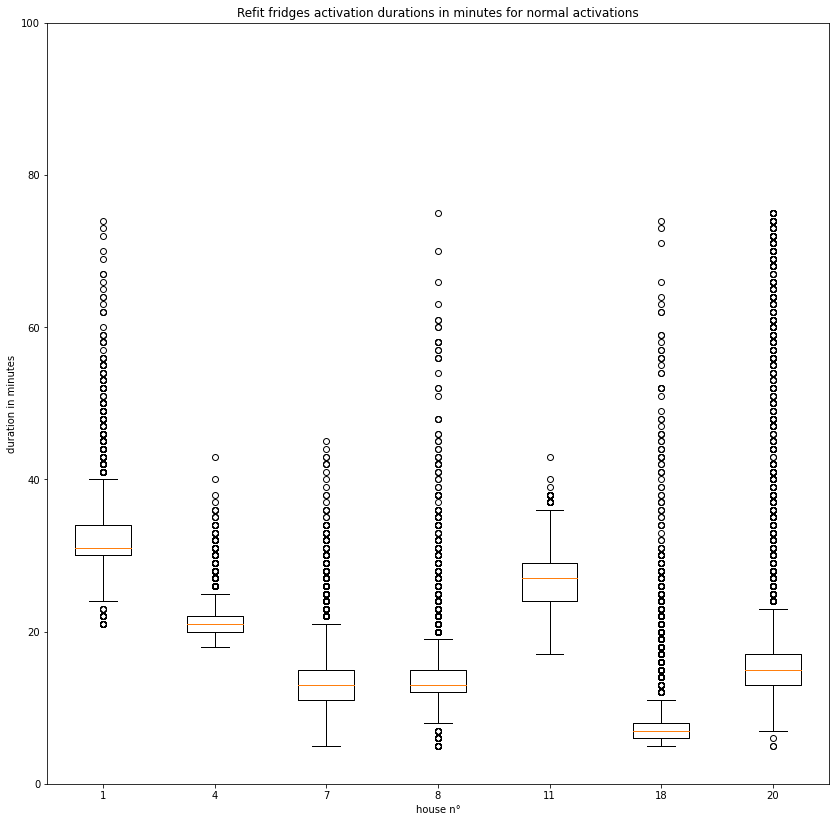

In [77]:
fig7, ax7 = plt.subplots(figsize=(14,14))
ax7.set_title('Refit fridges activation durations in minutes for normal activations')
ax7.boxplot(Refit_fridges_durations)
ax7.set_ylim(0,100)
ax7.set_xticklabels(duration_anomolous_activations.keys())
plt.ylabel("duration in minutes")
plt.xlabel("house n°")
plt.savefig('Refit_fridges_max-avg-duration_normal_activation_durations_in_minutes.jpg',dpi=184)
plt.show()

[5251, 6343, 10768, 8474, 2723, 9124, 8645]
[337, 577, 406, 1253, 832, 559, 1384]


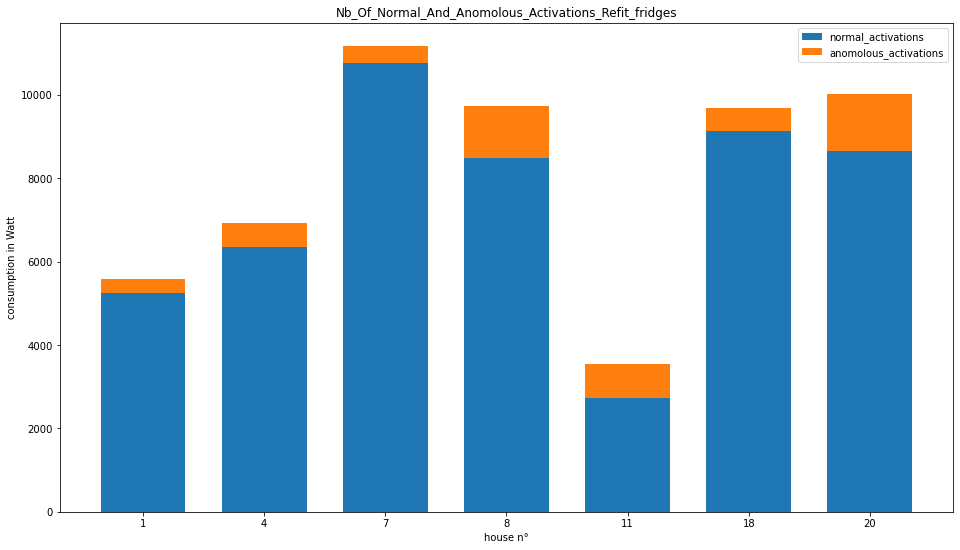

In [78]:
nb_normal_activations=[]
nb_anomolous_activations=[]
for i in duration_normal_activations.keys(): 
    nb_normal_activations.append(len(duration_normal_activations[i]))
    nb_anomolous_activations.append(len(duration_anomolous_activations[i]))
fig, ax = plt.subplots(figsize =(16, 9))
width =0.7
y_pos = np.arange(7)
ax.bar(np.arange(len(nb_normal_activations)), nb_normal_activations, width=width,label='normal_activations')
ax.bar(np.arange(len(nb_anomolous_activations)), nb_anomolous_activations,bottom=nb_normal_activations, width=width,label="anomolous_activations")
plt.xticks(y_pos, Refit_fridge_normal_activations.keys())
plt.title('Nb_Of_Normal_And_Anomolous_Activations_Refit_fridges')
plt.legend()
plt.ylabel("consumption in Watt")
plt.xlabel("house n°")

plt.savefig('Refit_fridges_Nb_Of_Normal_And_Anomolous_Activations.jpg',dpi=184)


#plt.show()
print(nb_normal_activations)
print(nb_anomolous_activations)

/home/mahdi/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


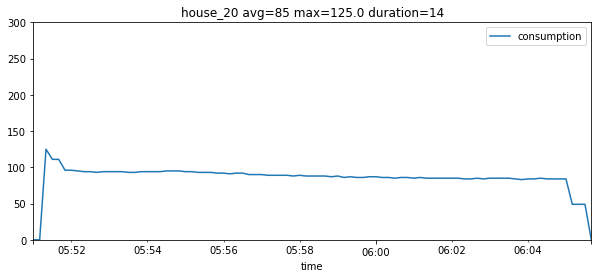

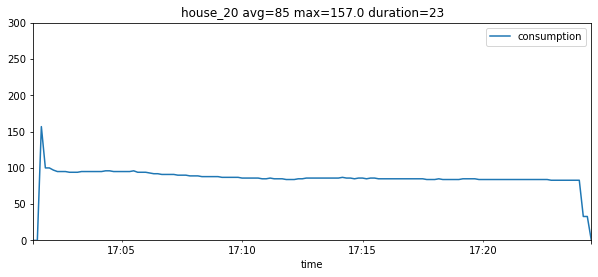

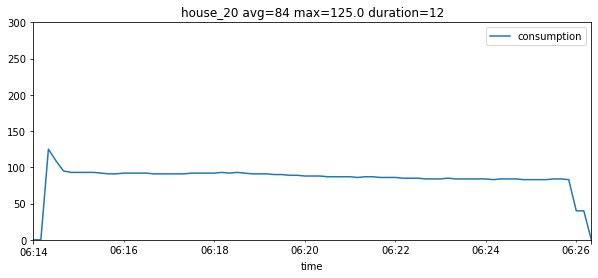

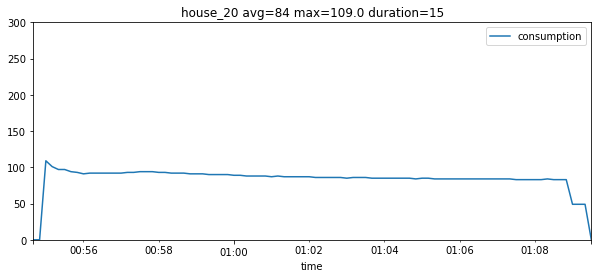

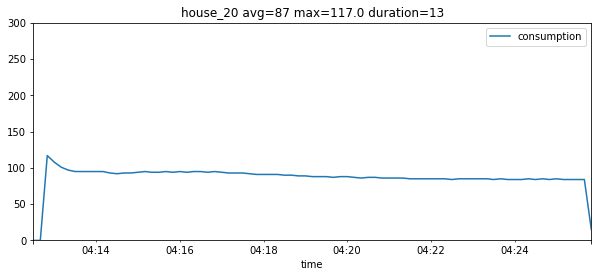

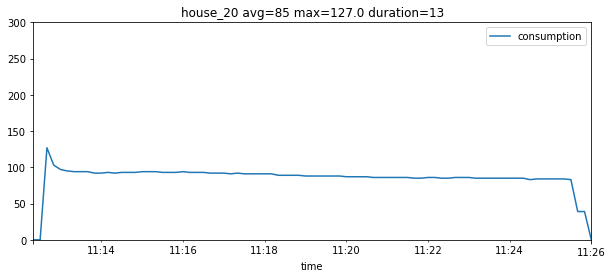

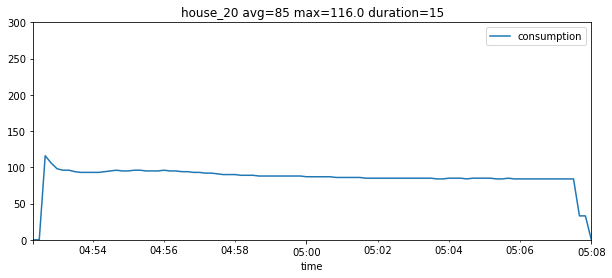

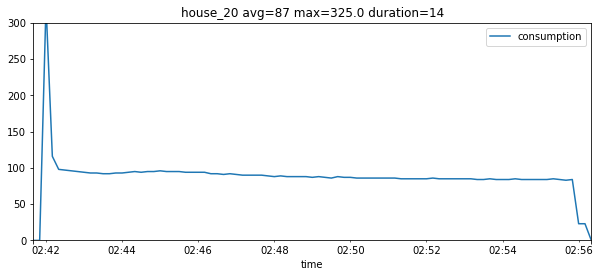

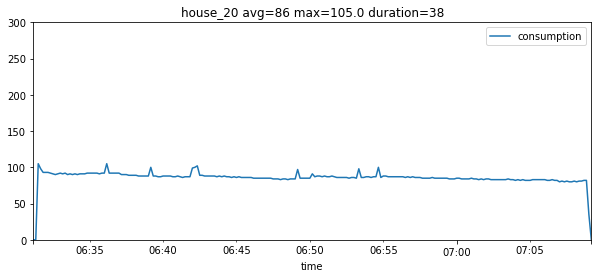

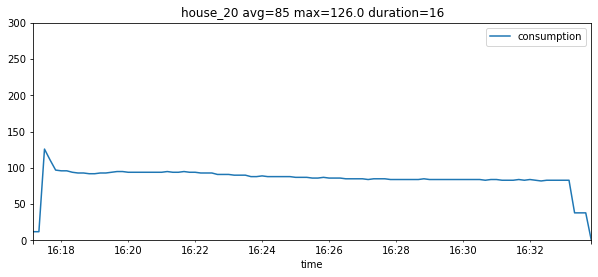

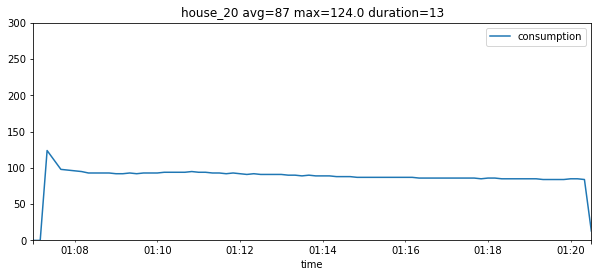

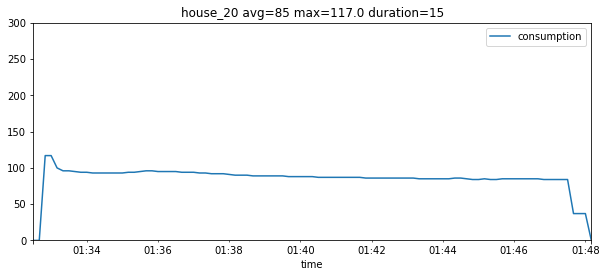

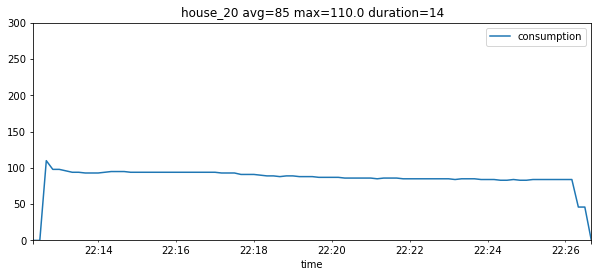

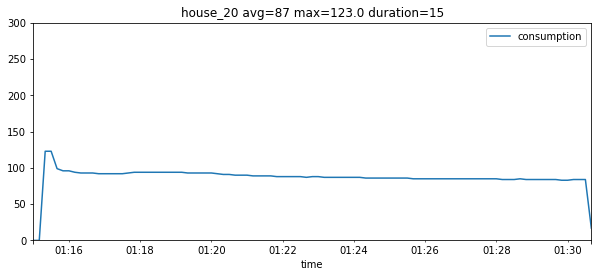

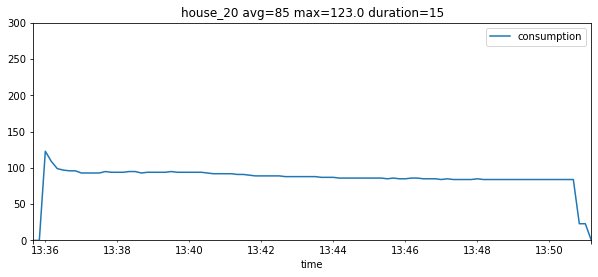

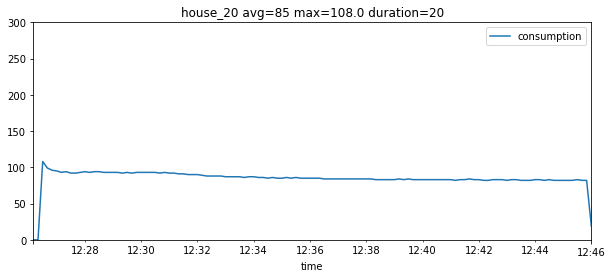

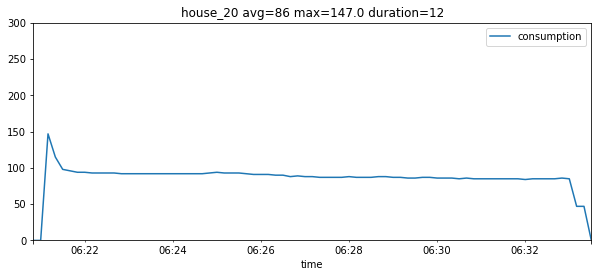

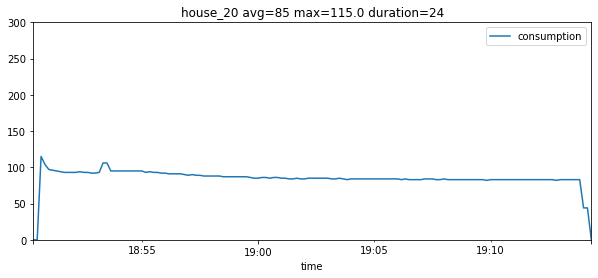

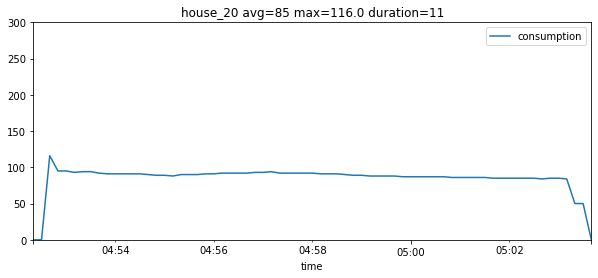

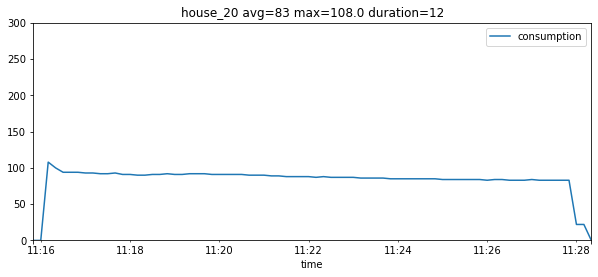

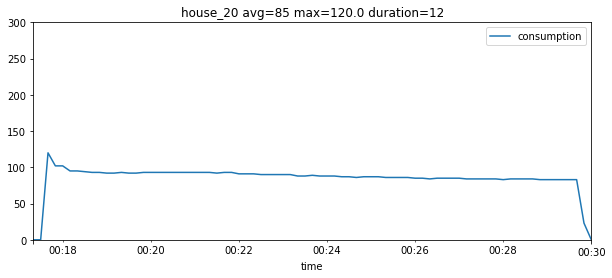

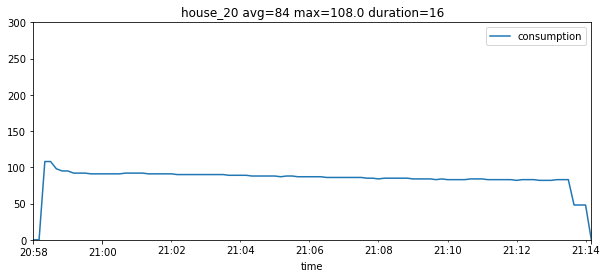

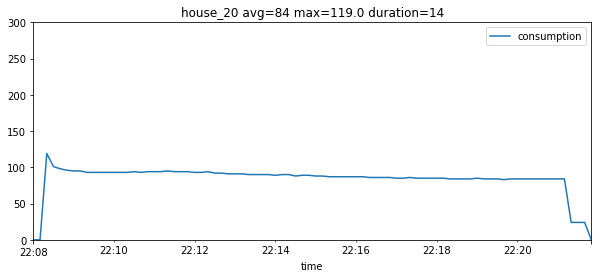

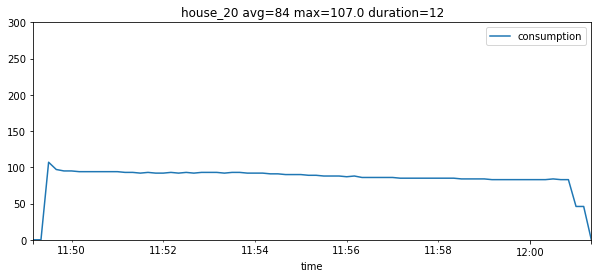

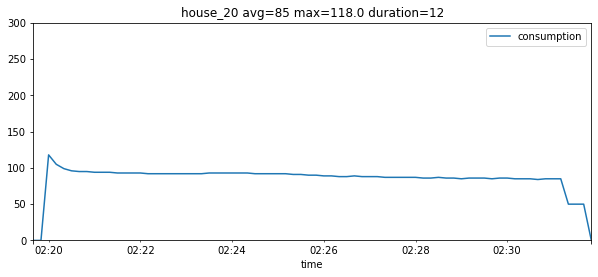

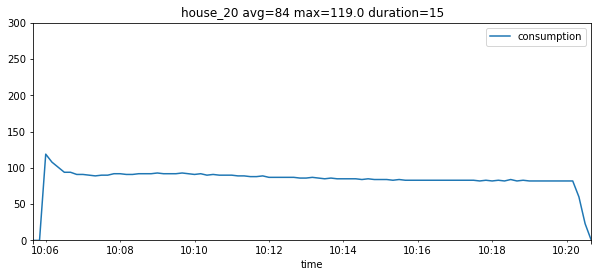

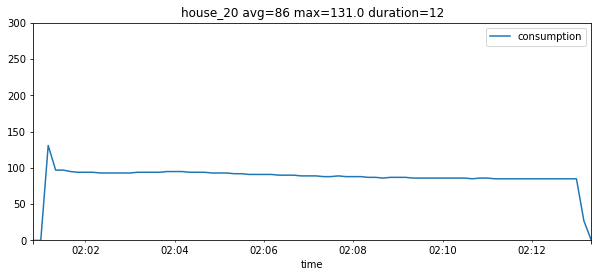

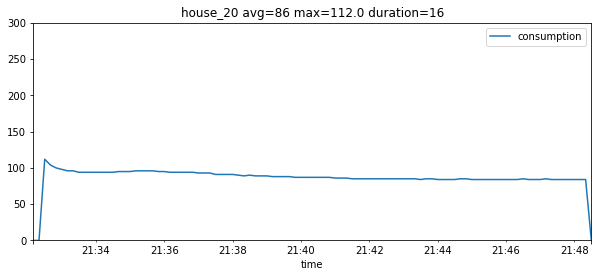

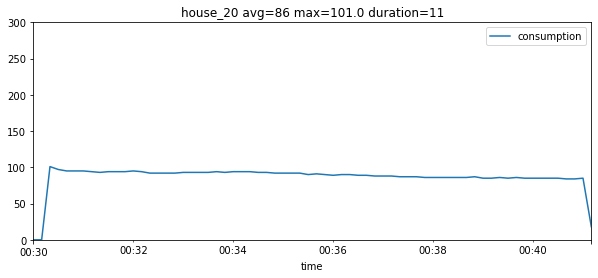

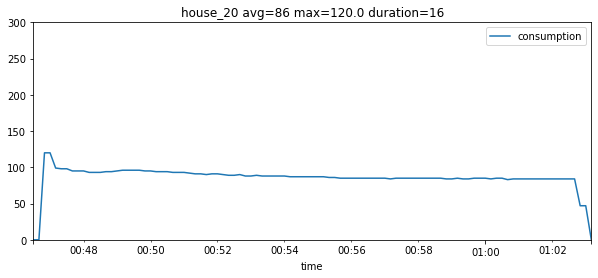

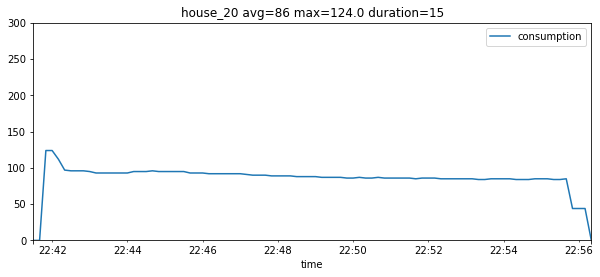

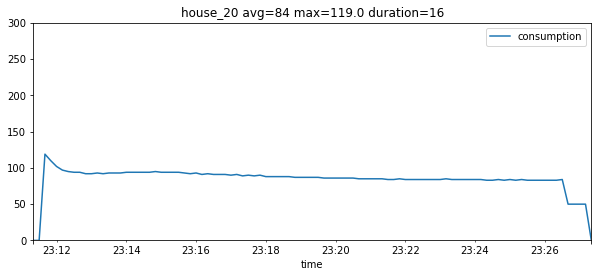

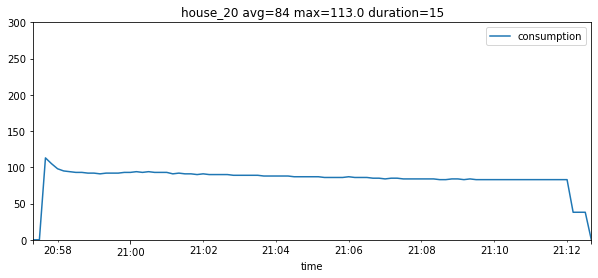

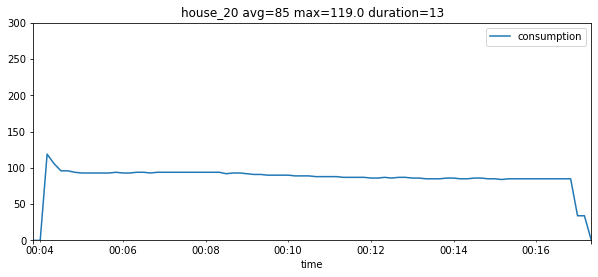

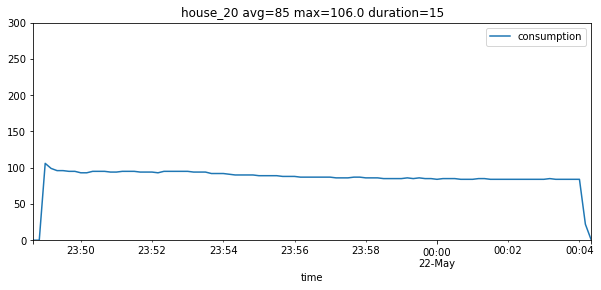

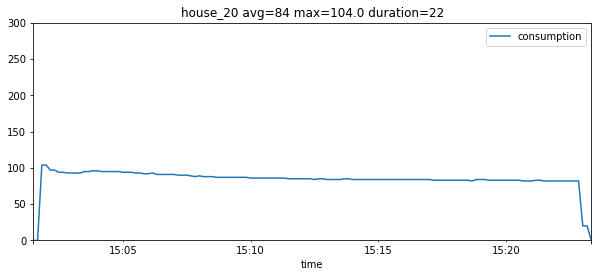

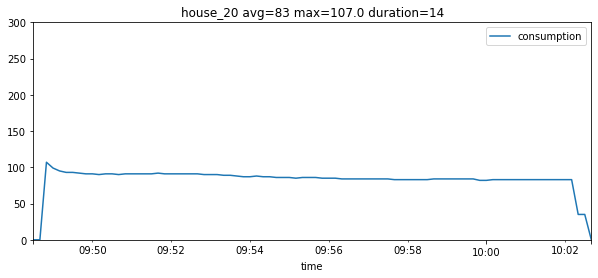

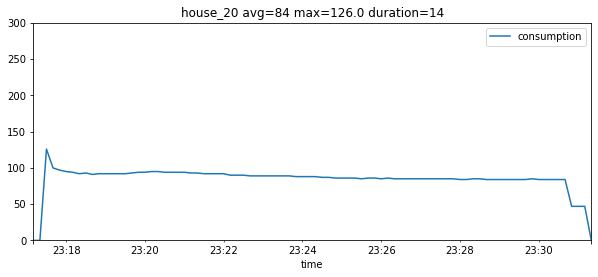

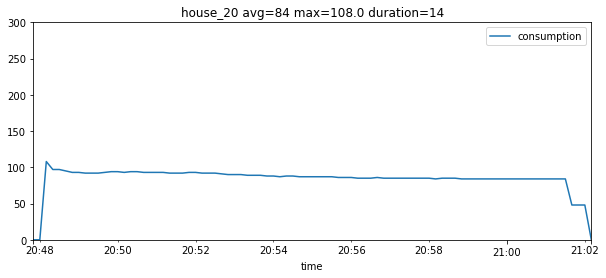

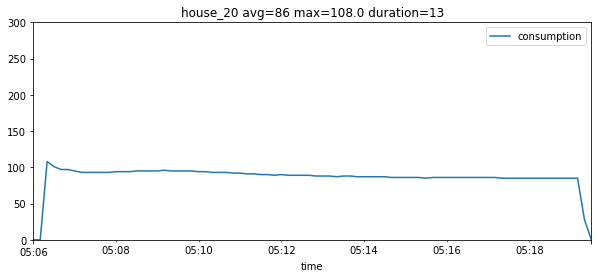

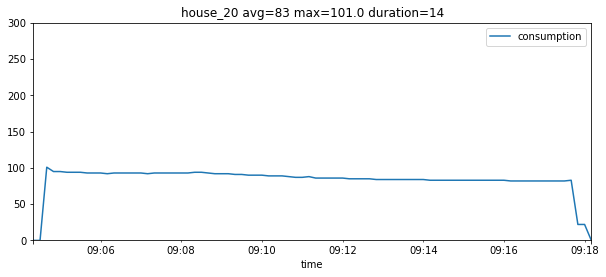

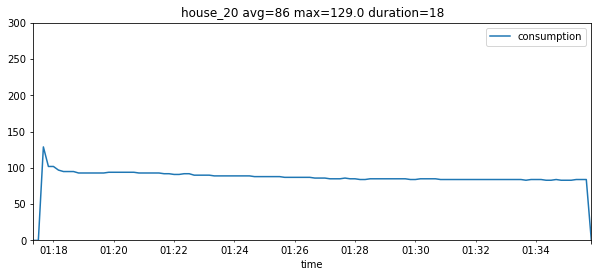

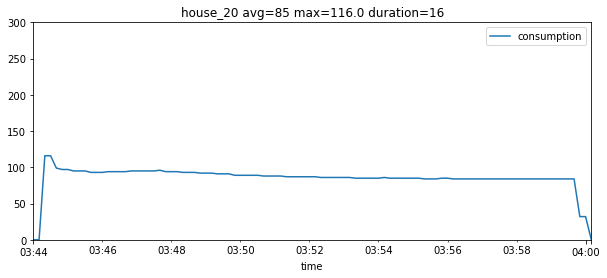

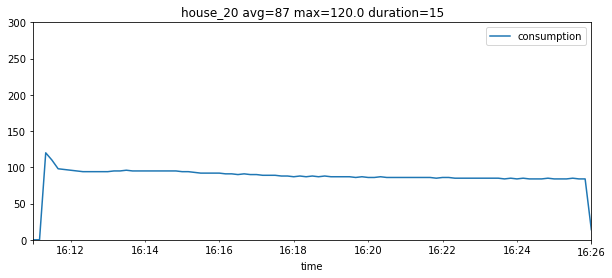

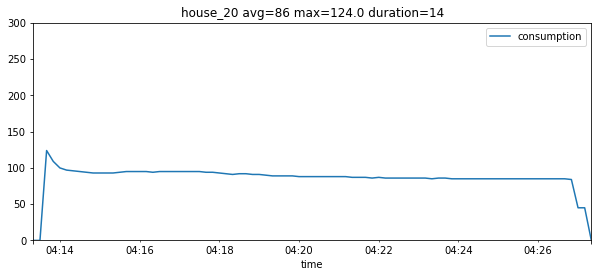

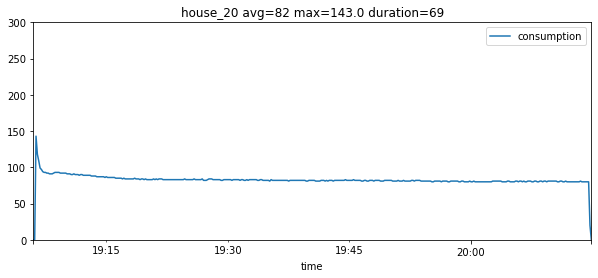

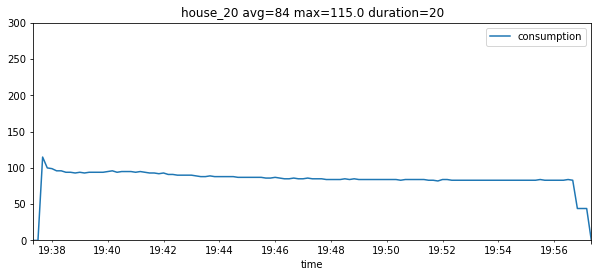

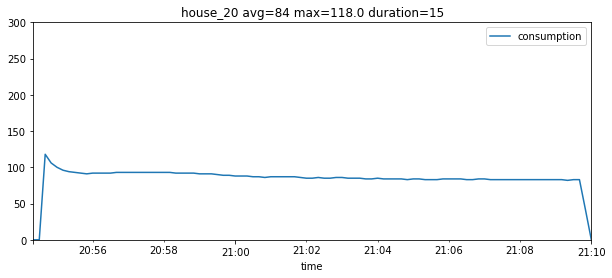

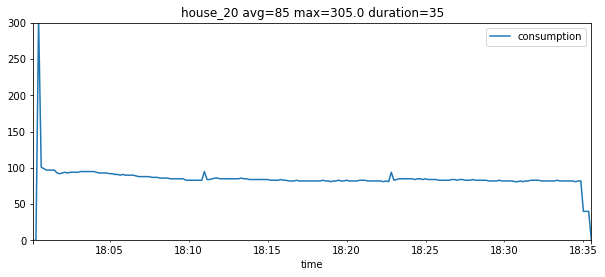

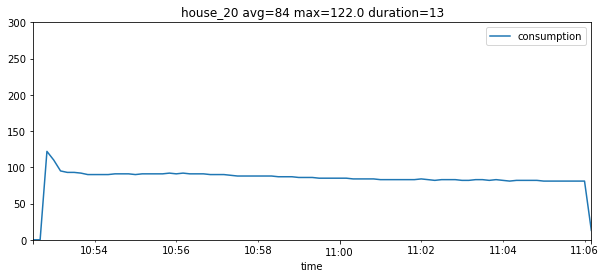

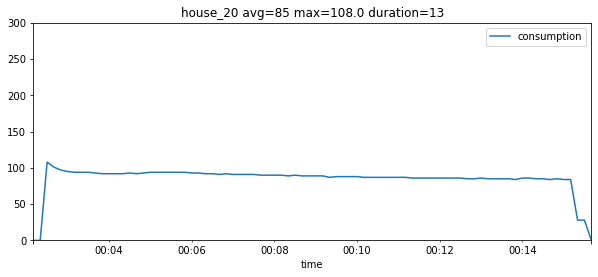

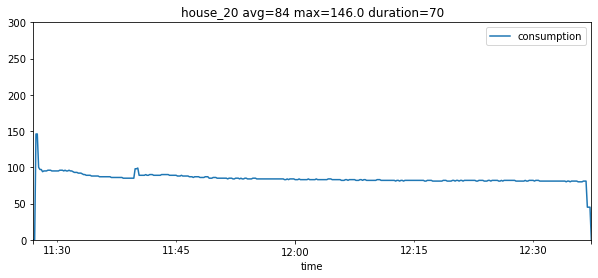

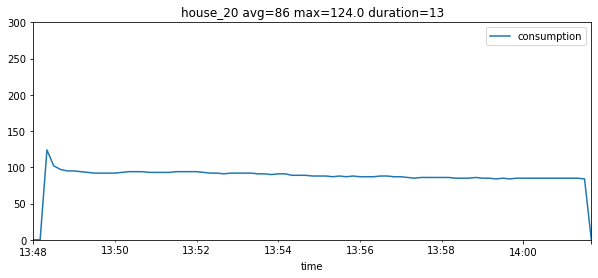

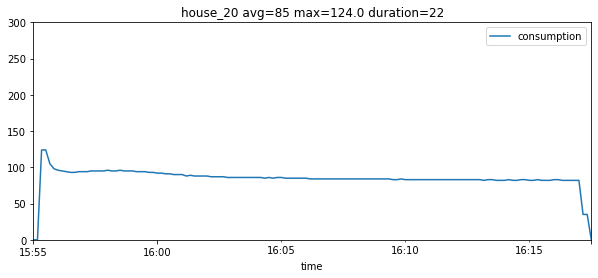

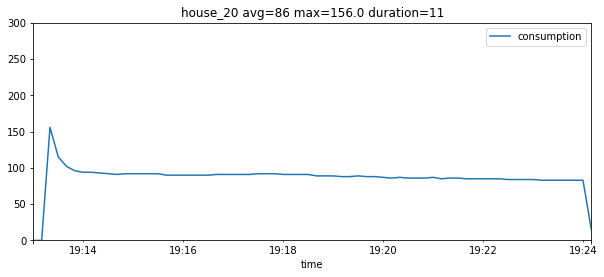

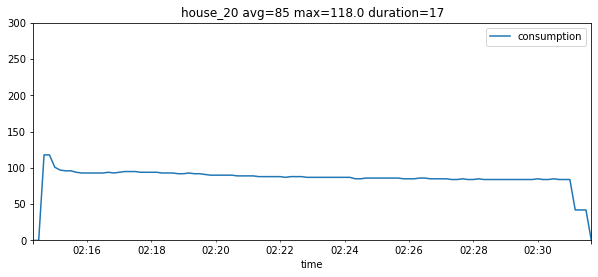

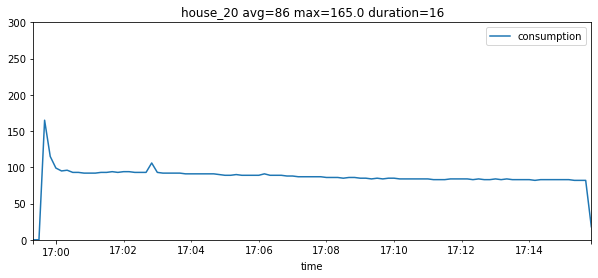

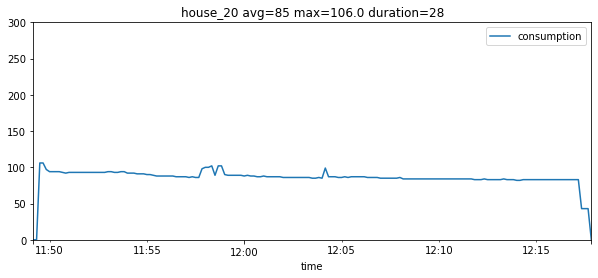

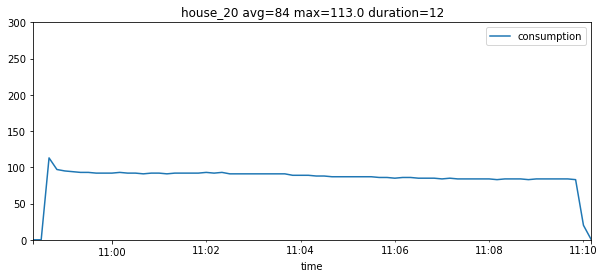

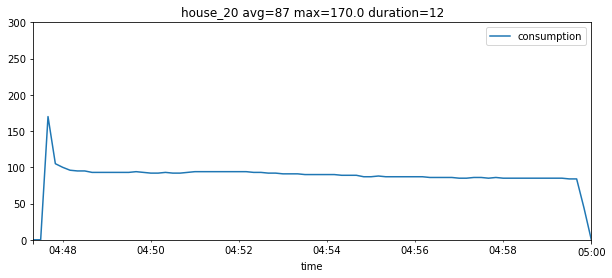

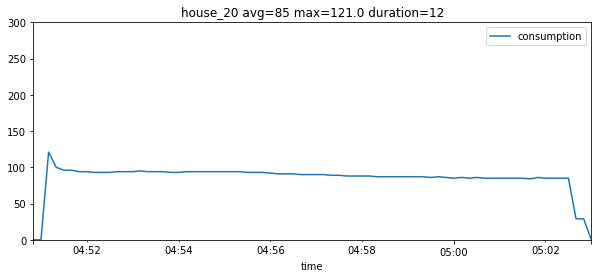

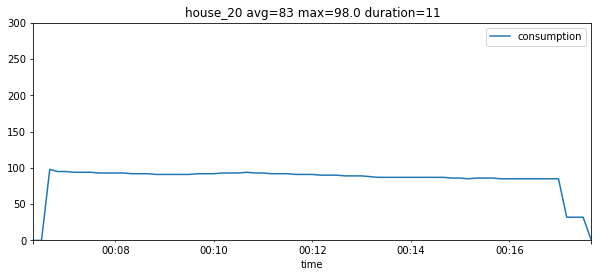

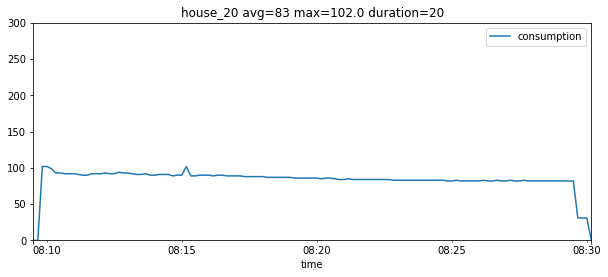

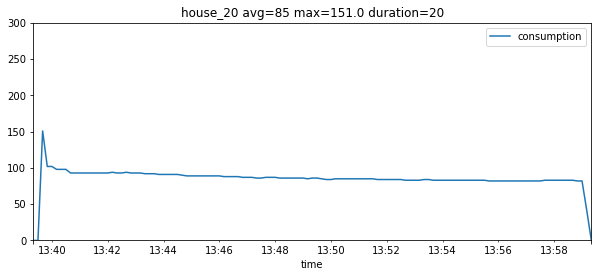

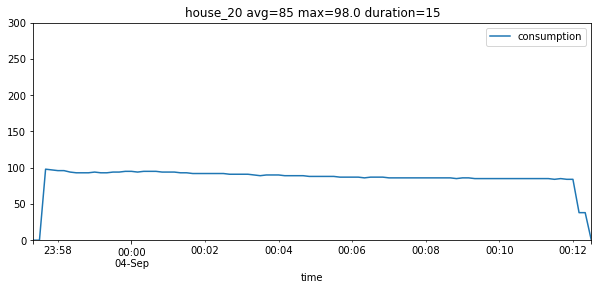

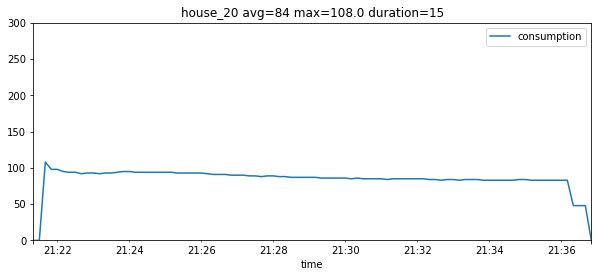

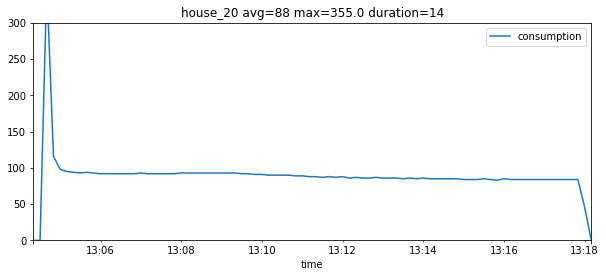

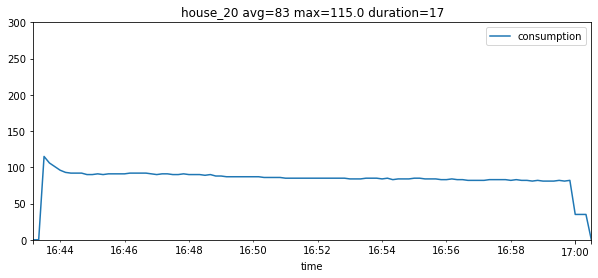

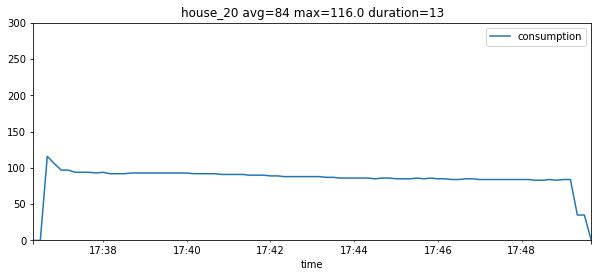

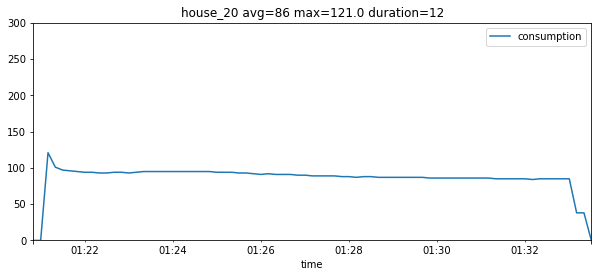

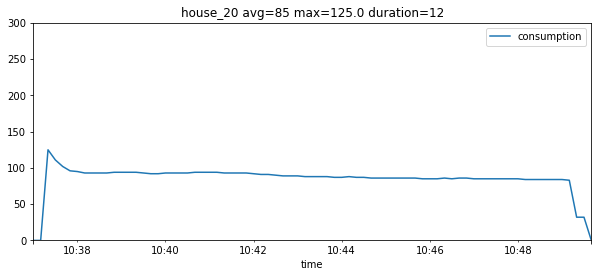

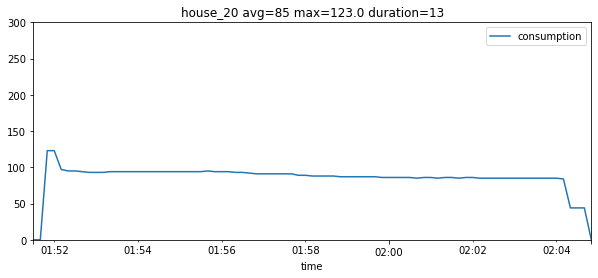

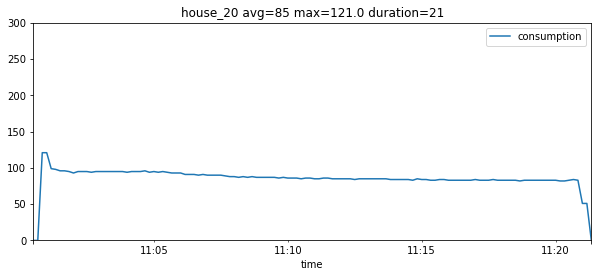

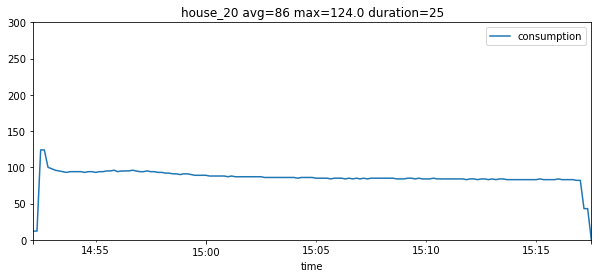

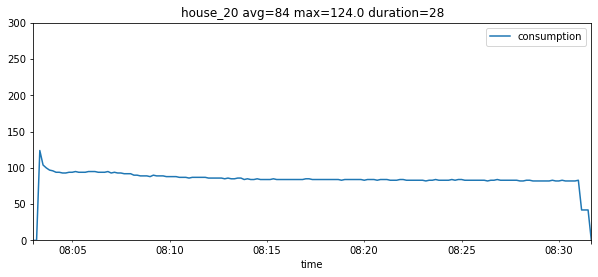

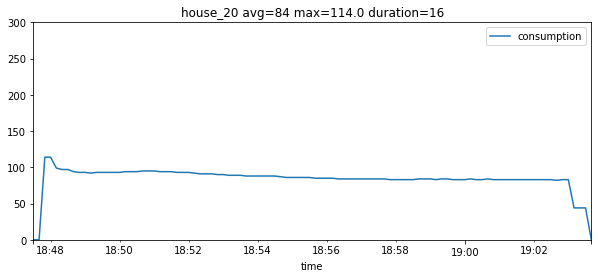

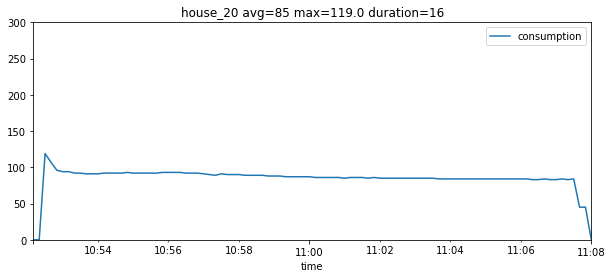

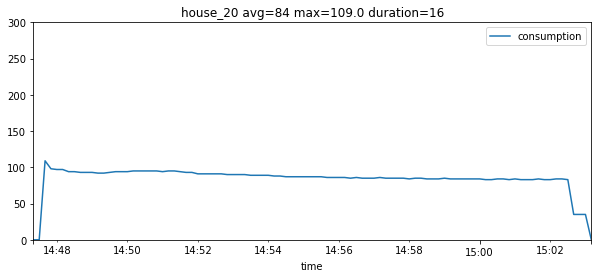

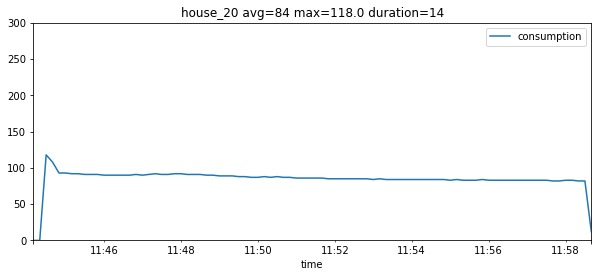

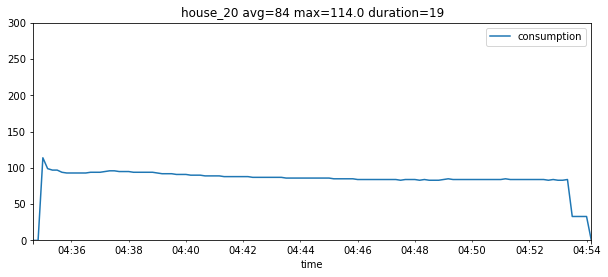

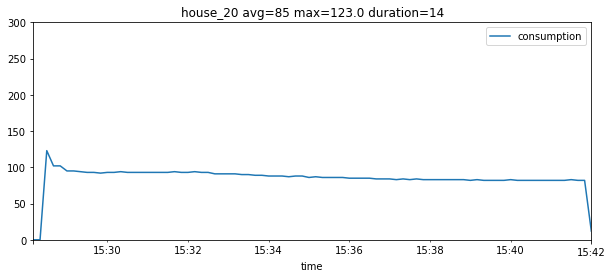

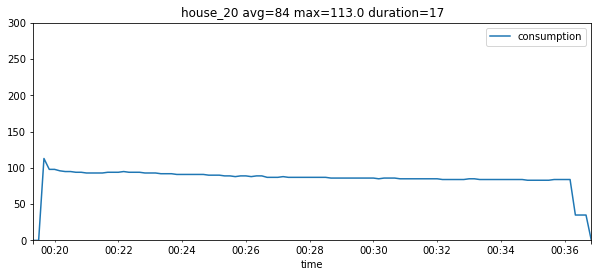

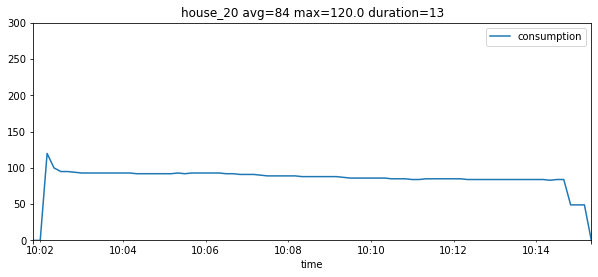

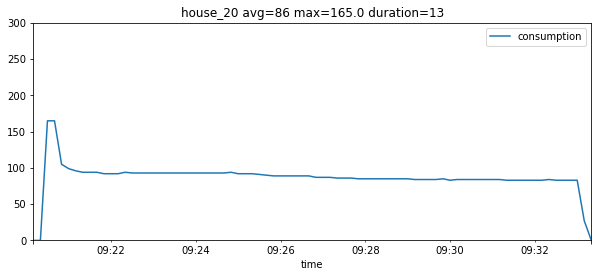

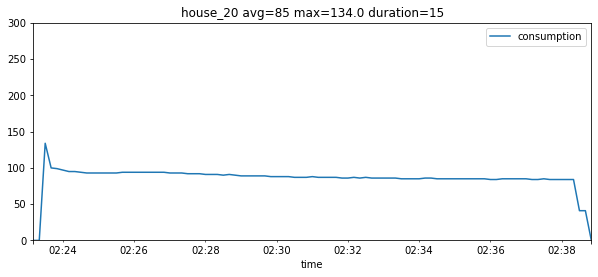

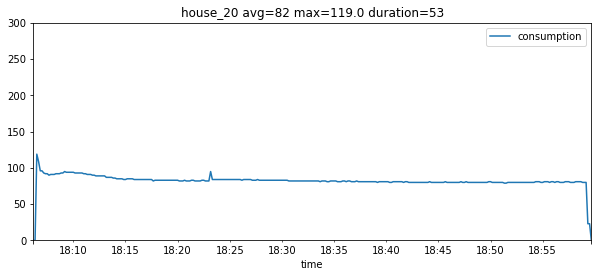

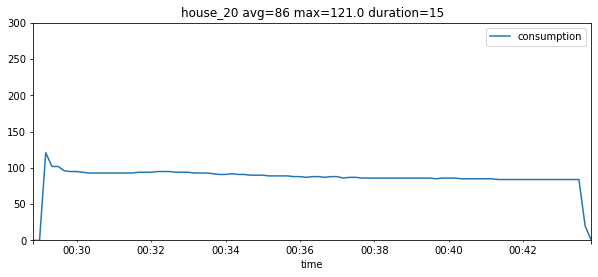

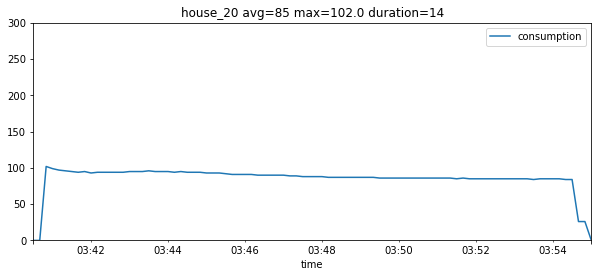

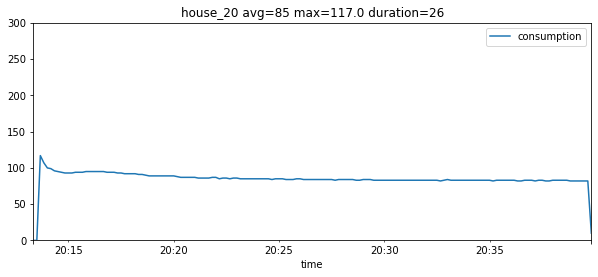

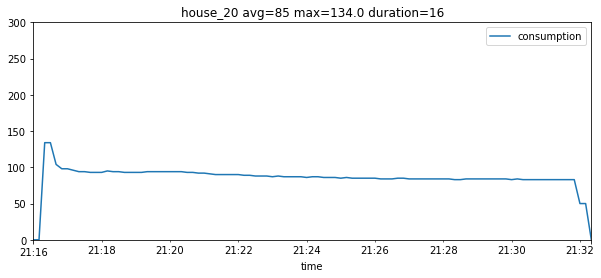

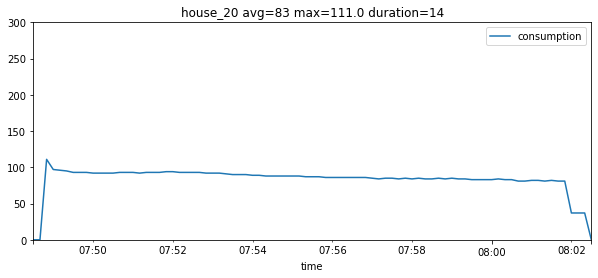

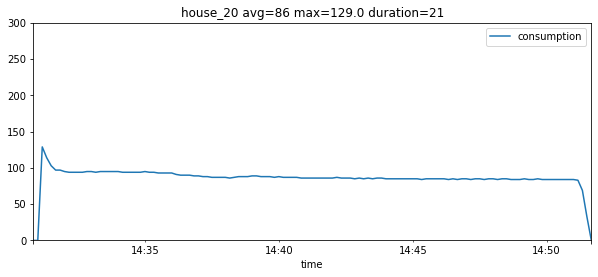

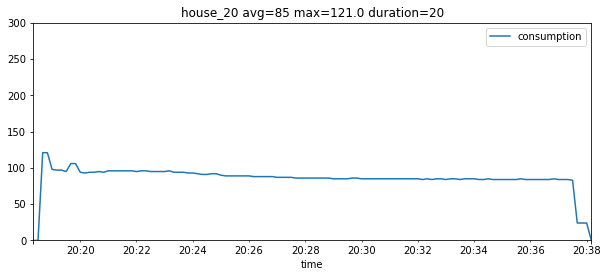

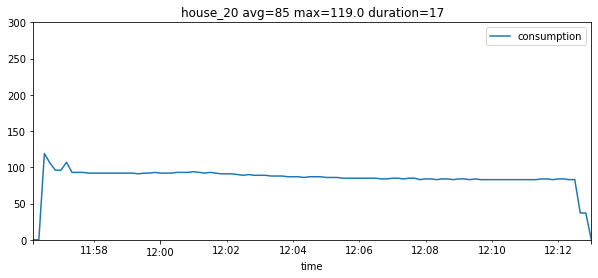

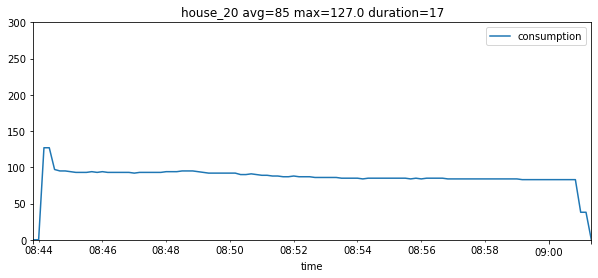

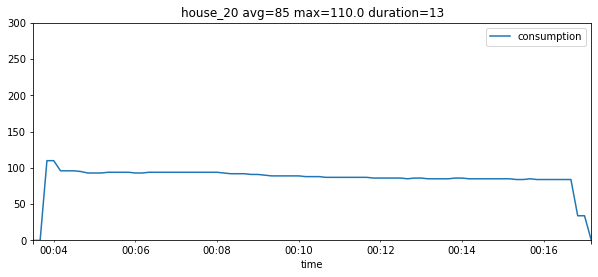

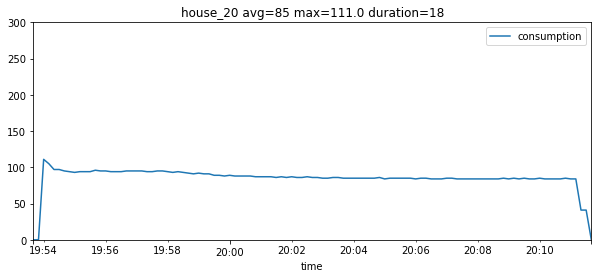

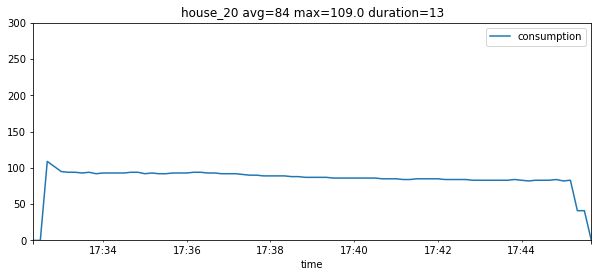

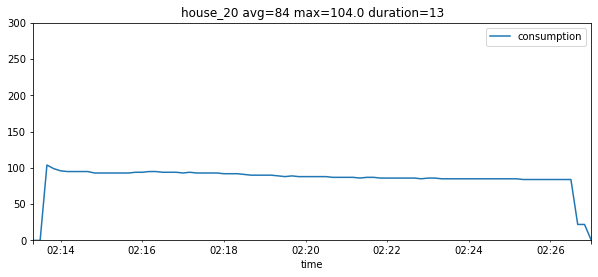

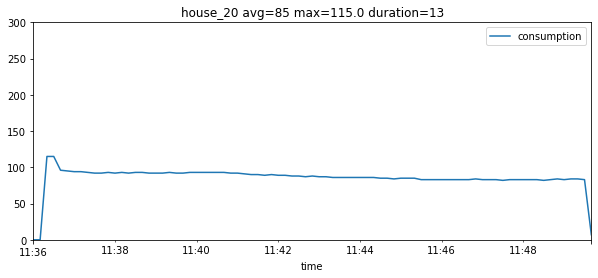

In [79]:
house=20
activations=random.sample(range(0, len(duration_normal_activations[house])),100)
df=Refit_fridges[house]
for activation in activations:
    beginning=duration_normal_activations[house][activation][0]
    end=duration_normal_activations[house][activation][1]
    avg=sum(df.consumption.iloc[beginning:end])/len(df.consumption.iloc[beginning:end])
    maximus=max(df.consumption.iloc[beginning:end])
    duration=int((end-beginning)/6)
    ax=df.iloc[beginning:end].plot(x="time",y=['consumption'], figsize=(10,4),title="house_"+str(house)+" avg="+str(round(avg))+" max="+str(maximus)+" duration="+str(duration))
    ax.set_ylim(0,300)

/home/mahdi/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


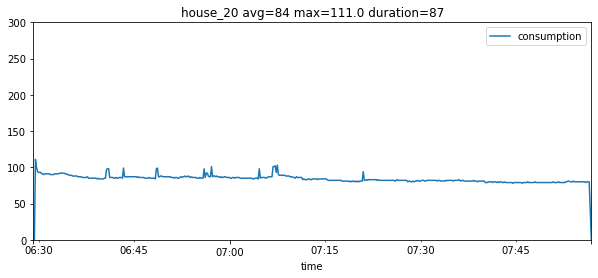

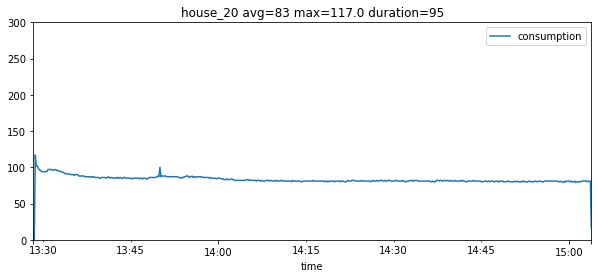

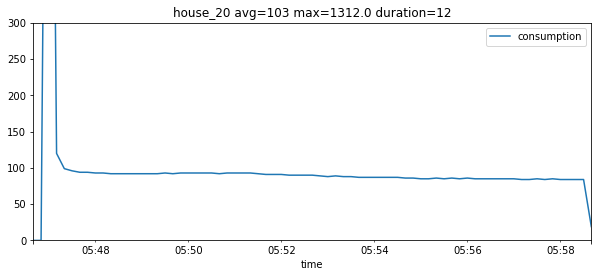

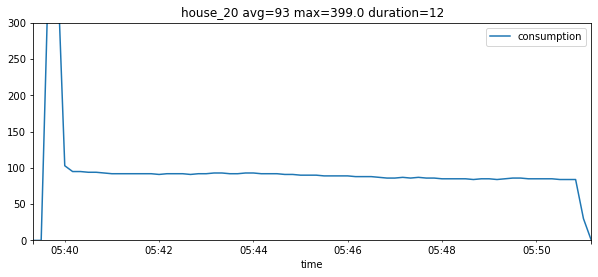

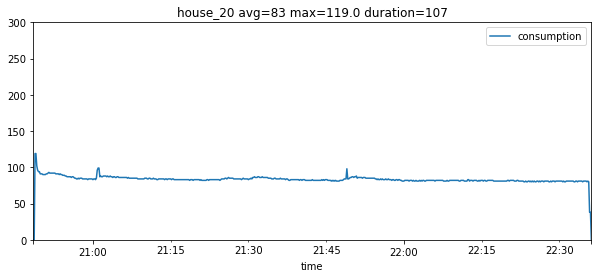

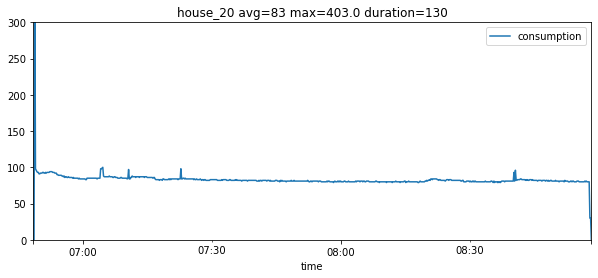

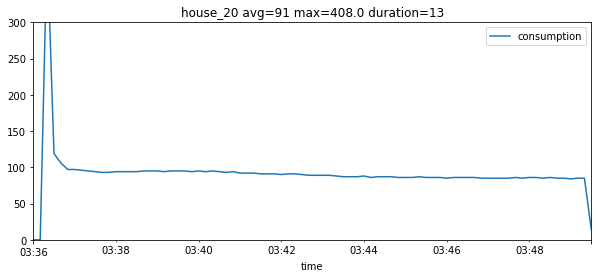

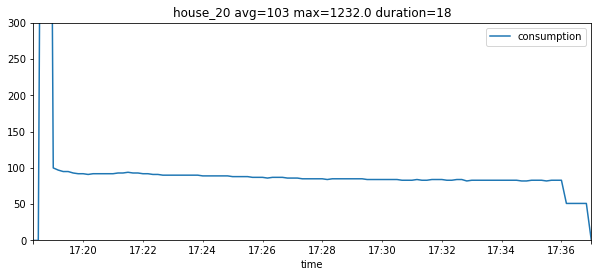

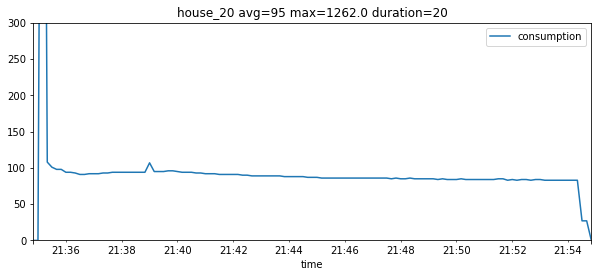

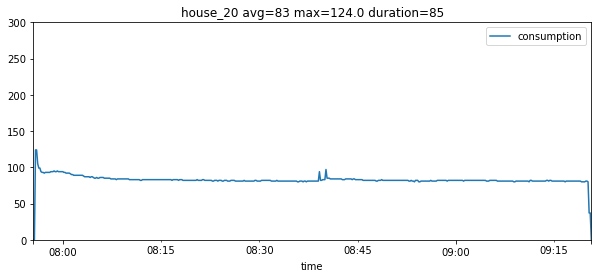

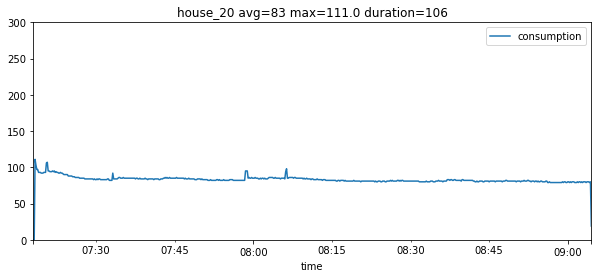

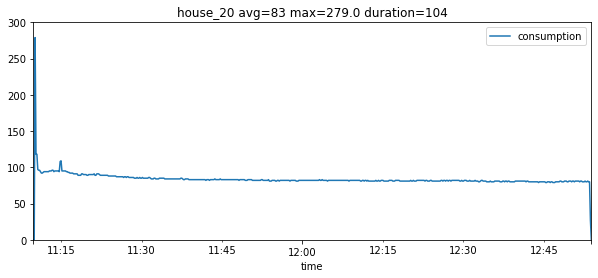

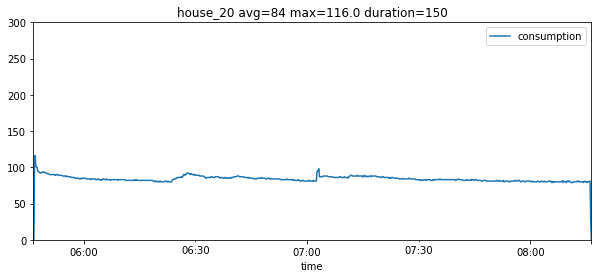

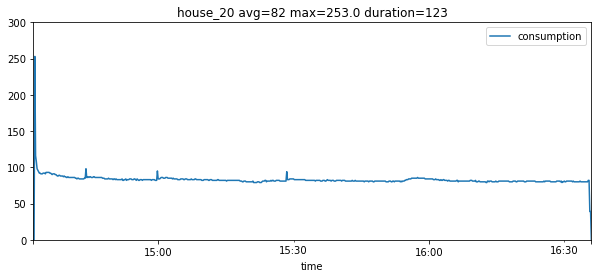

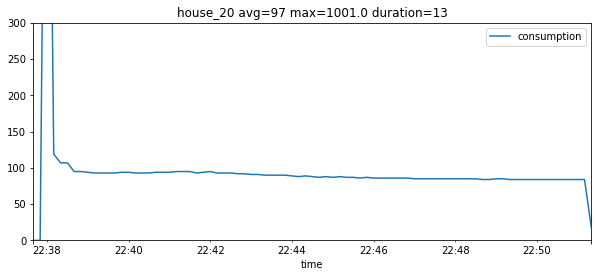

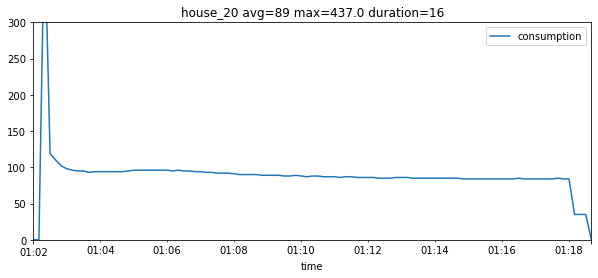

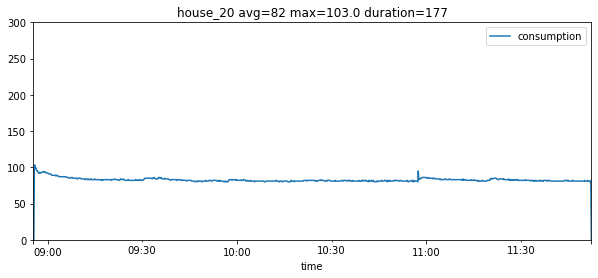

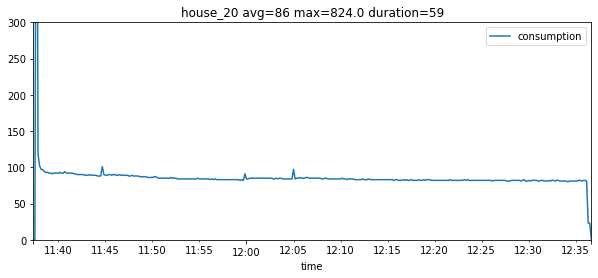

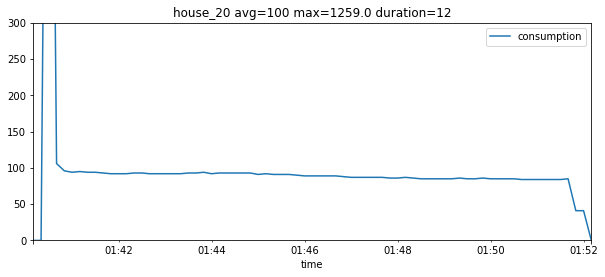

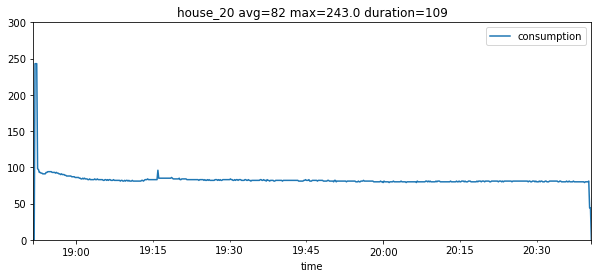

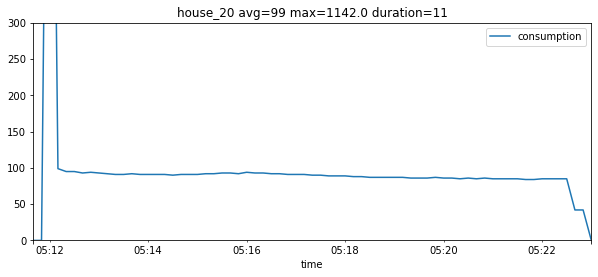

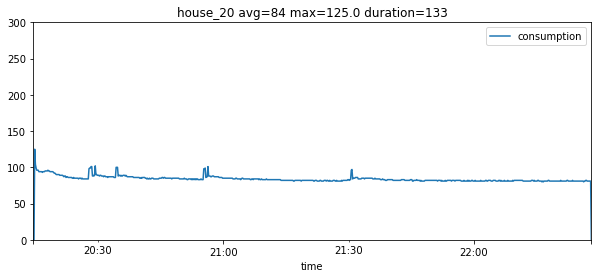

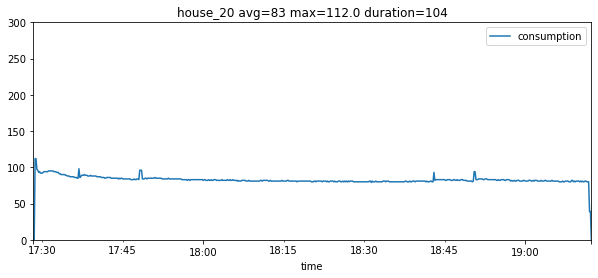

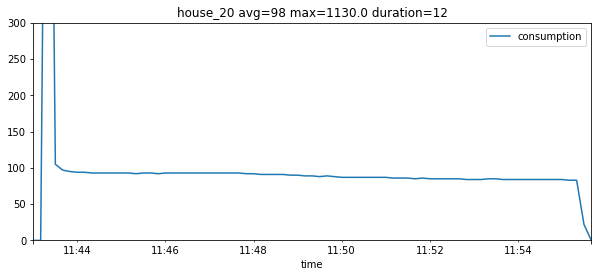

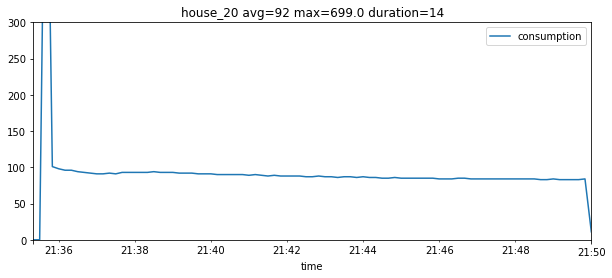

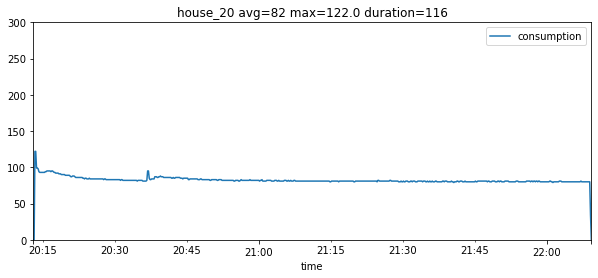

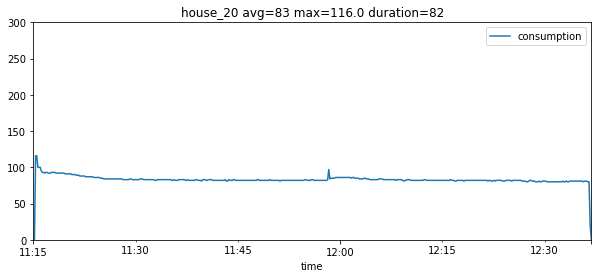

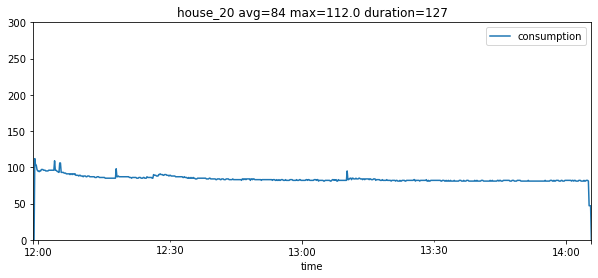

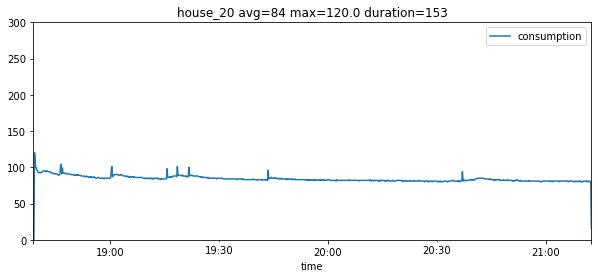

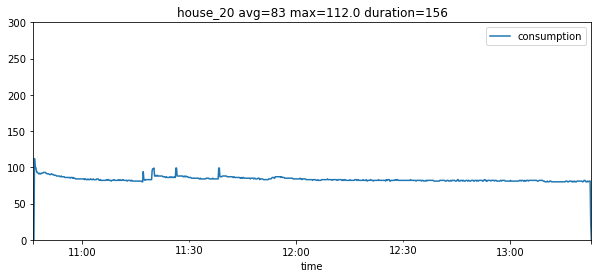

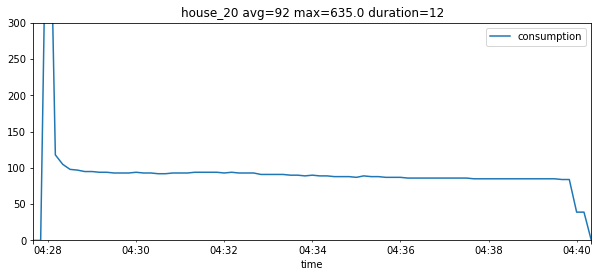

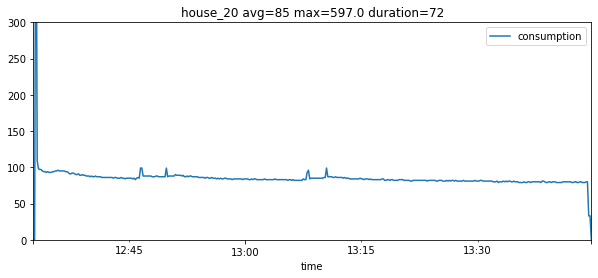

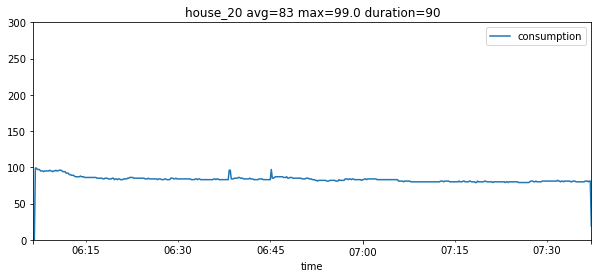

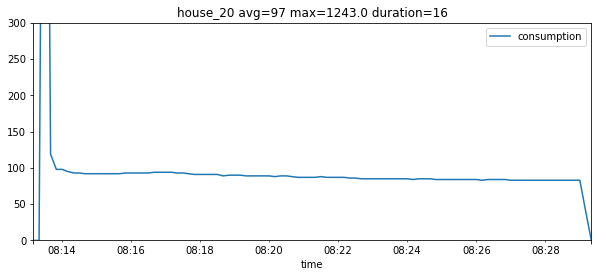

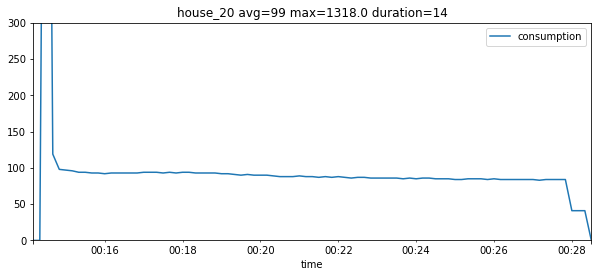

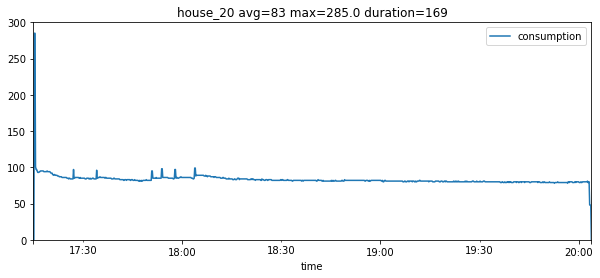

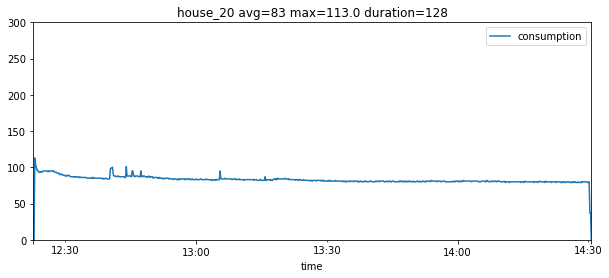

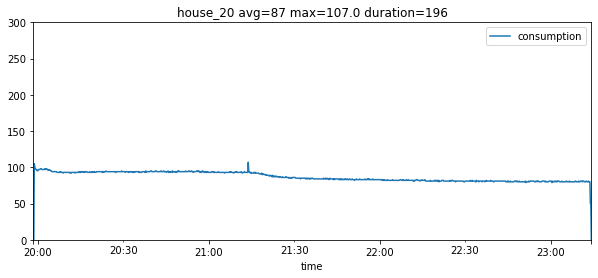

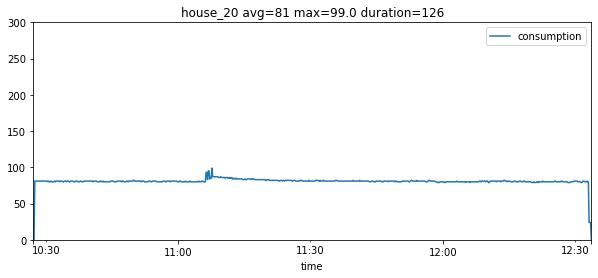

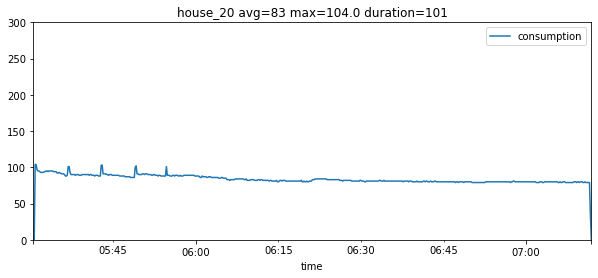

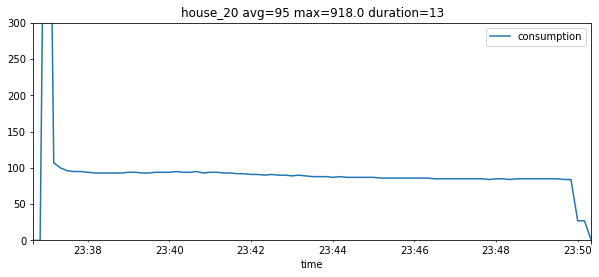

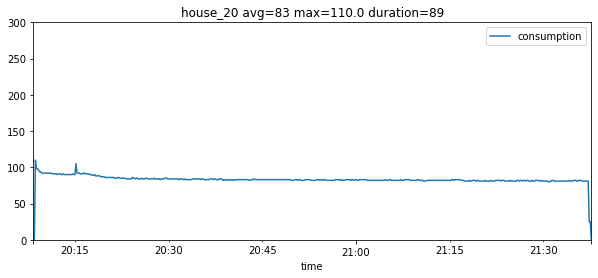

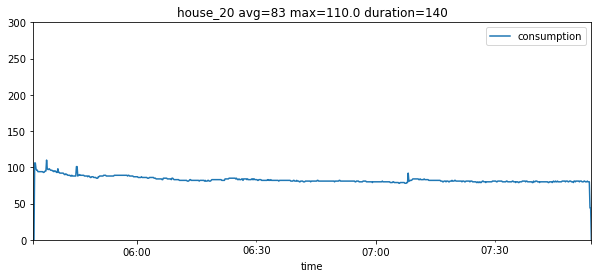

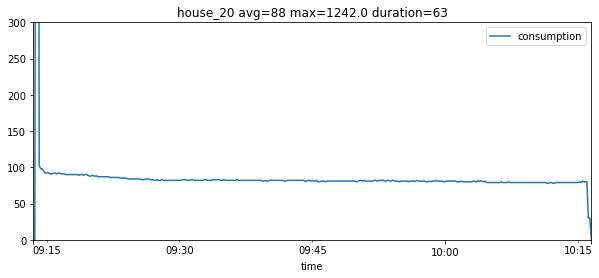

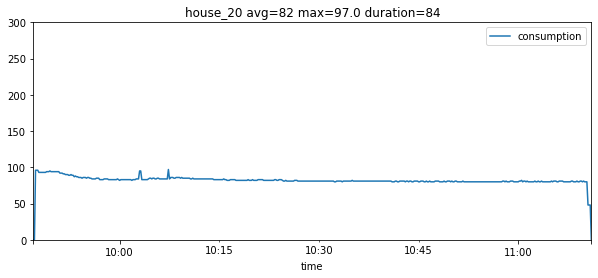

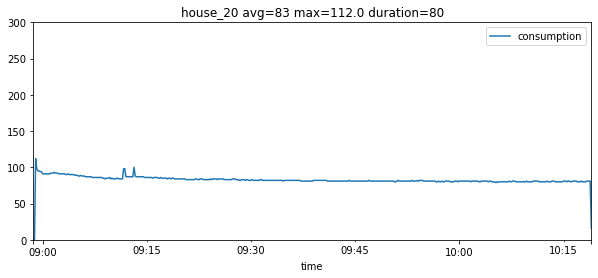

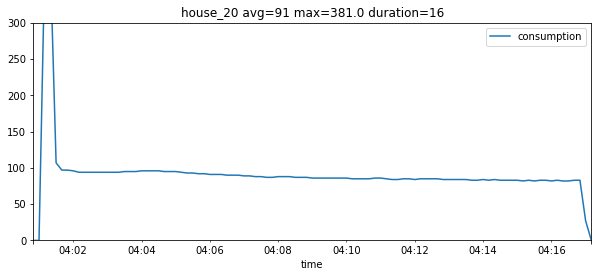

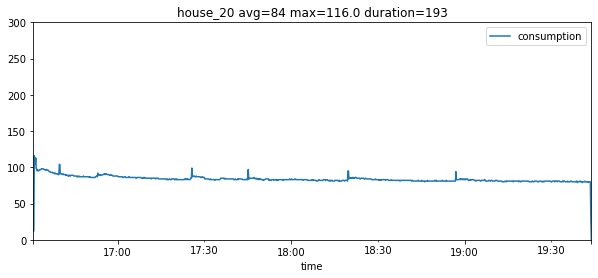

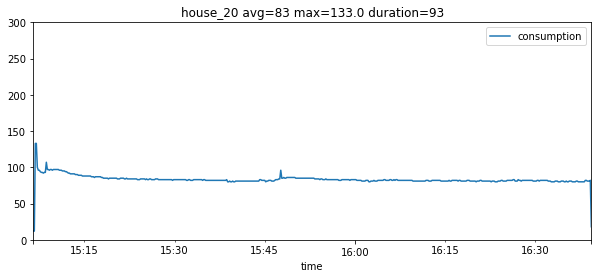

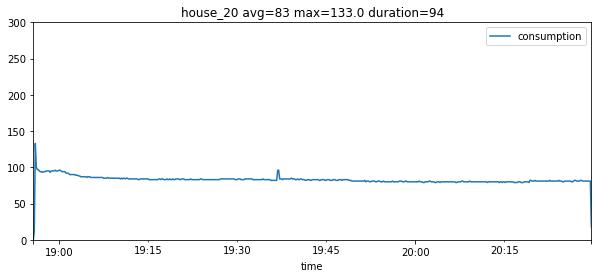

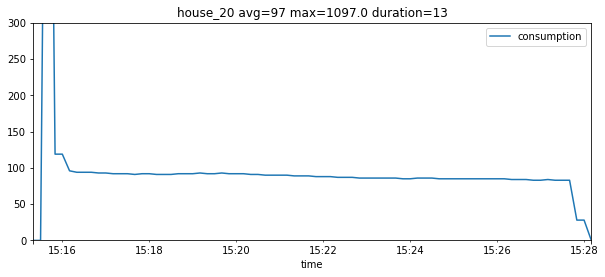

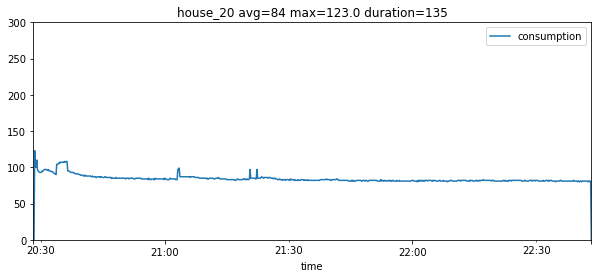

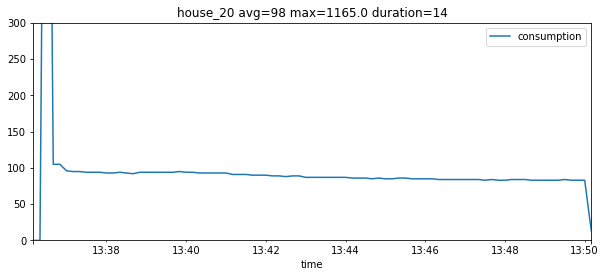

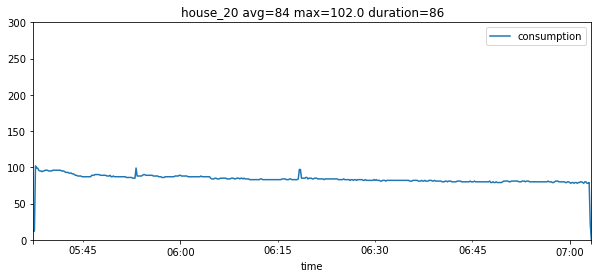

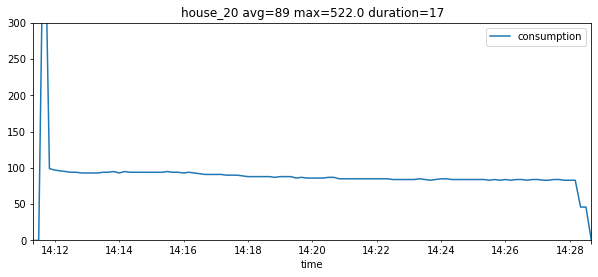

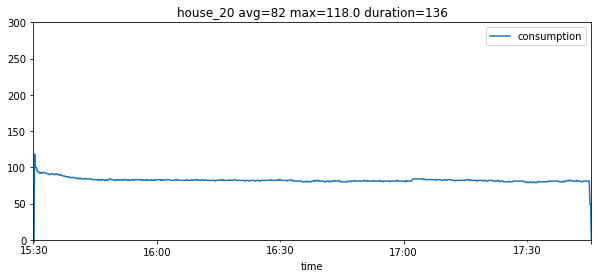

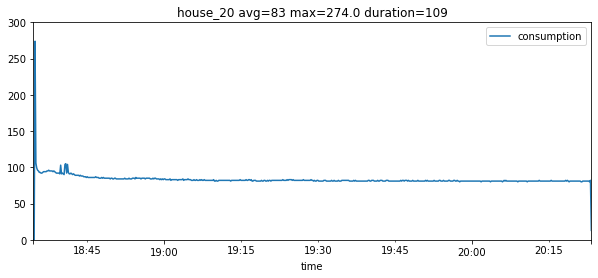

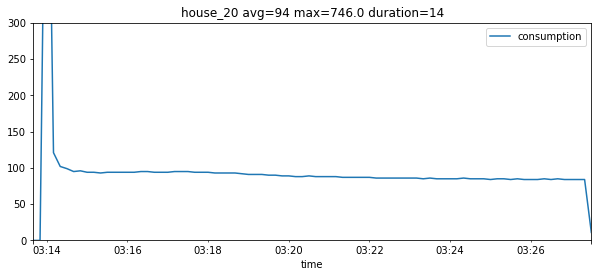

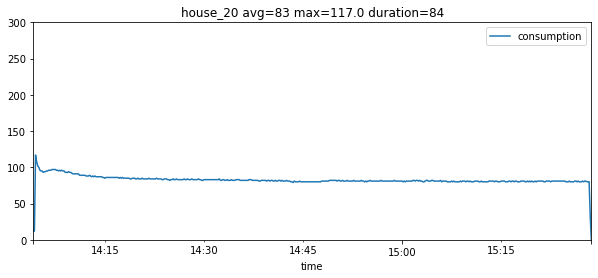

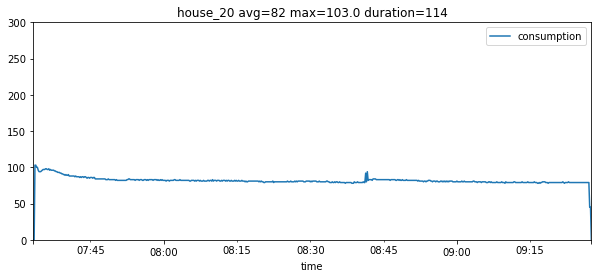

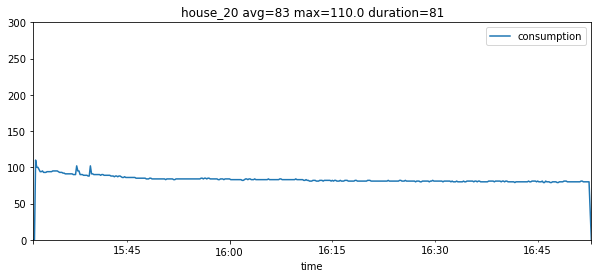

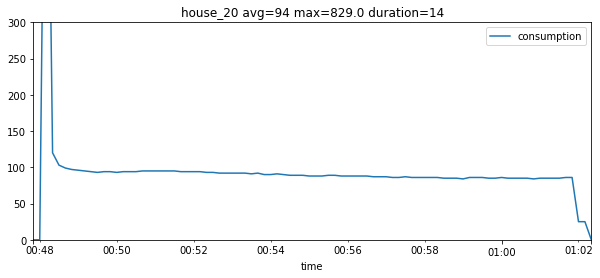

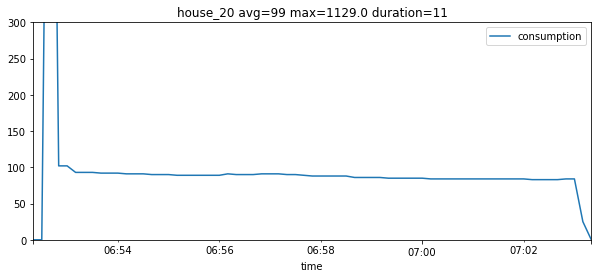

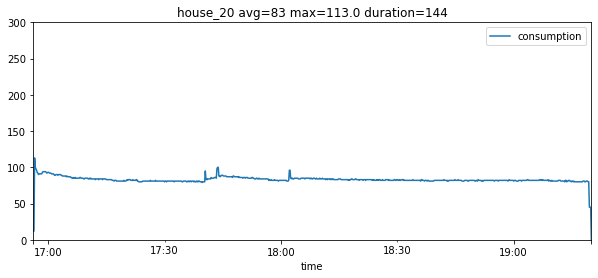

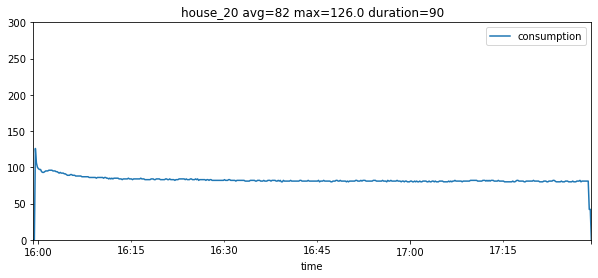

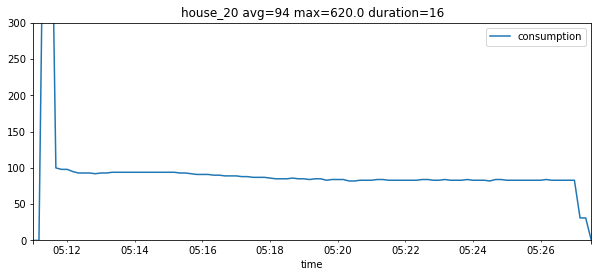

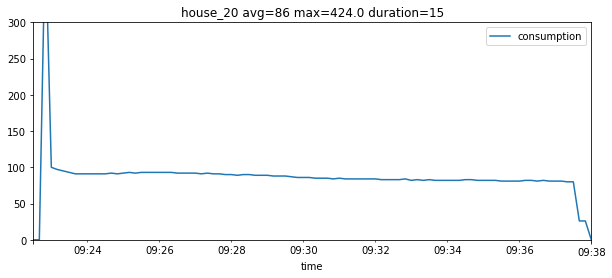

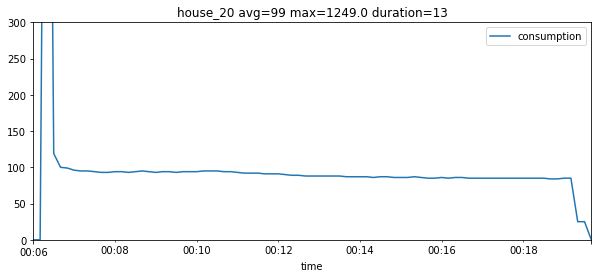

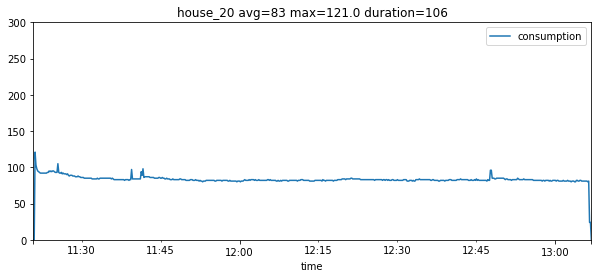

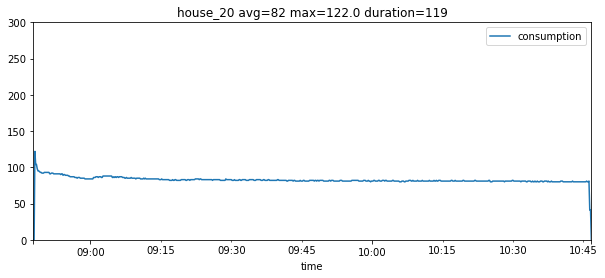

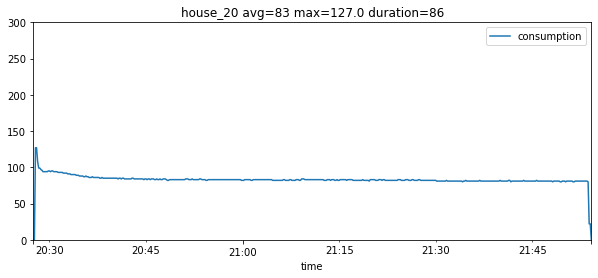

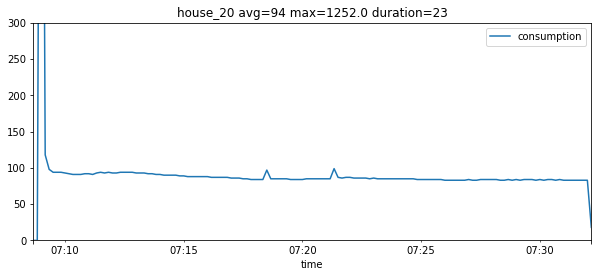

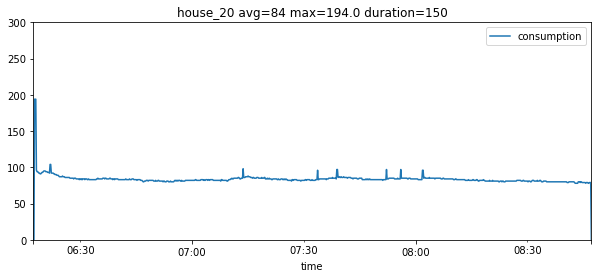

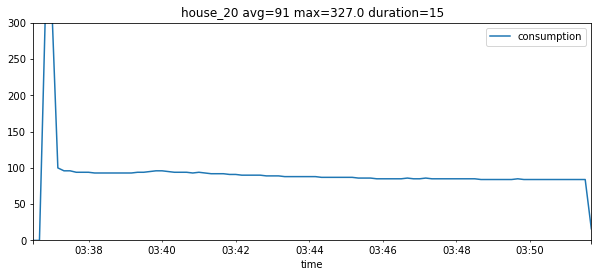

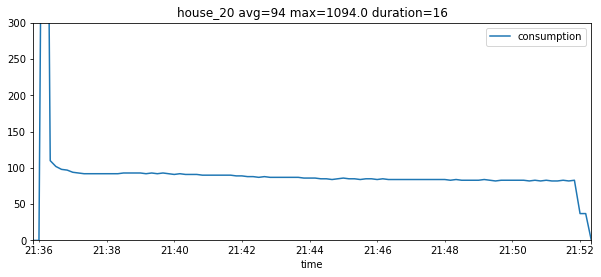

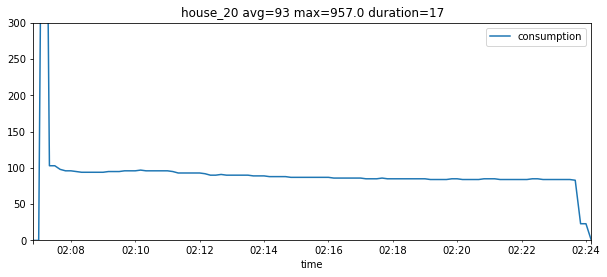

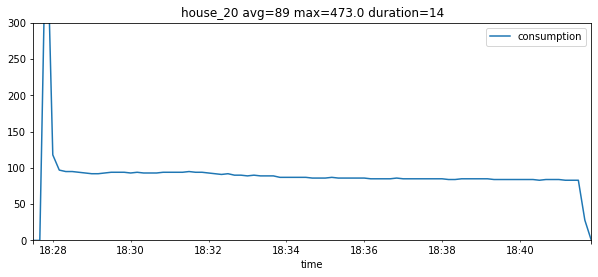

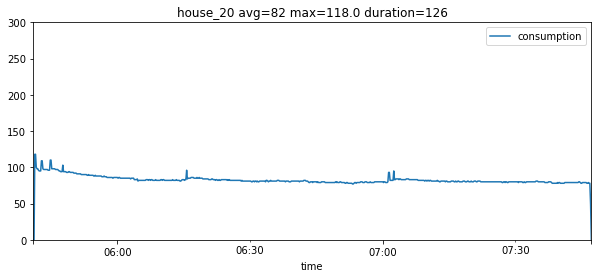

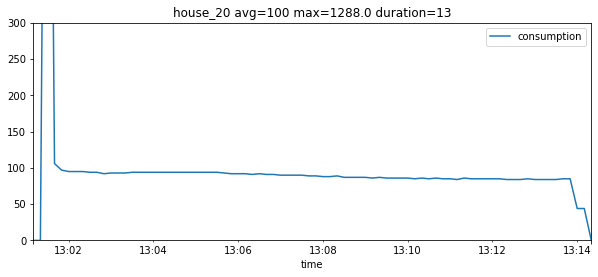

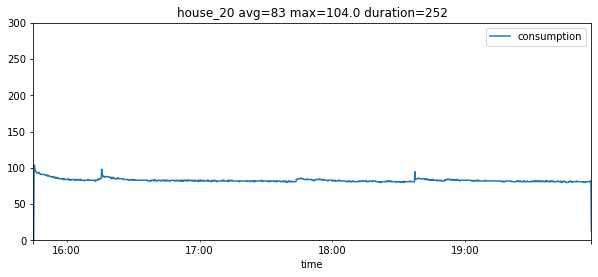

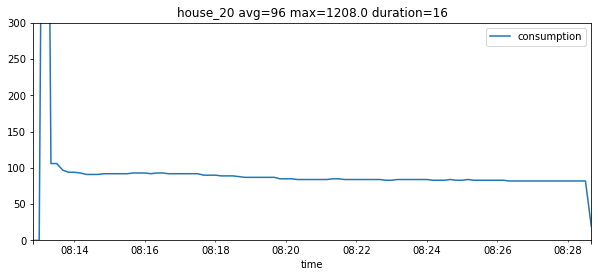

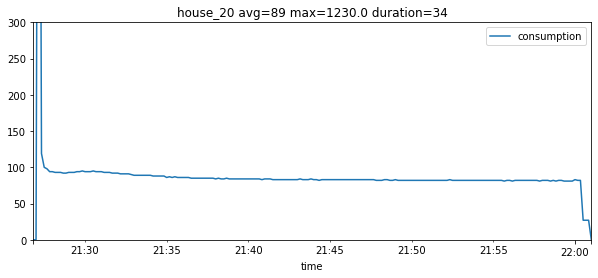

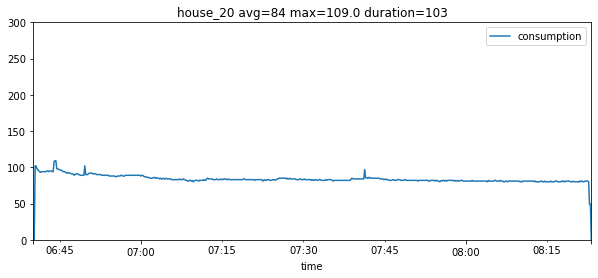

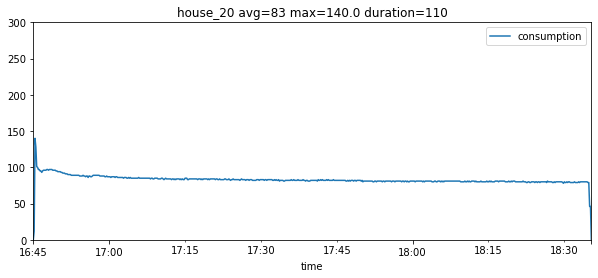

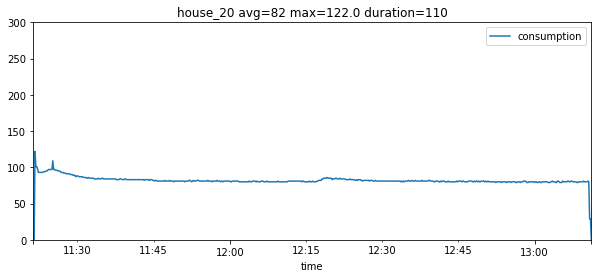

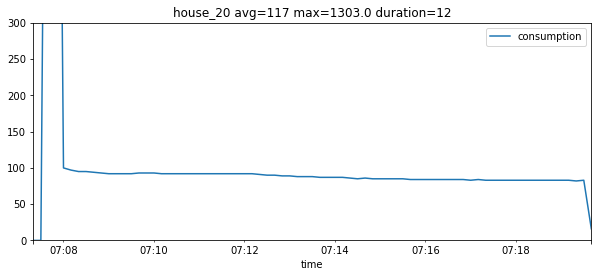

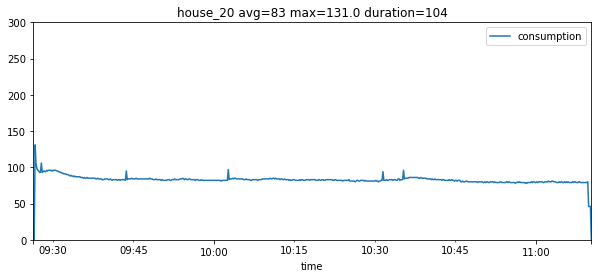

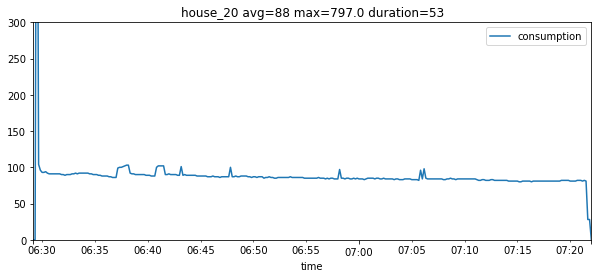

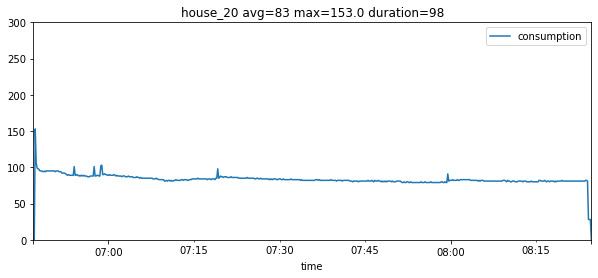

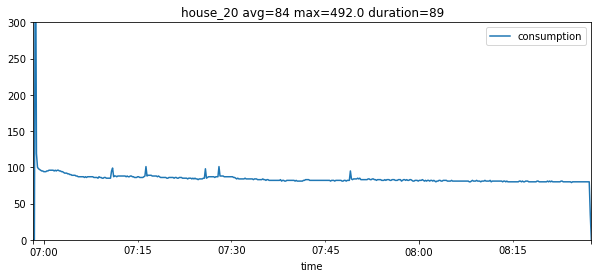

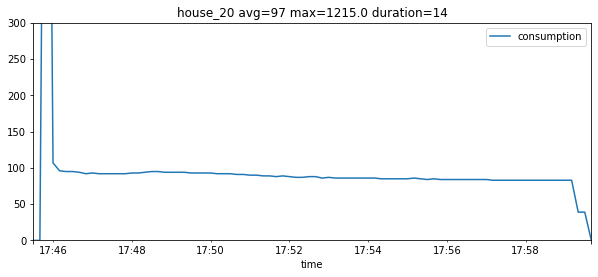

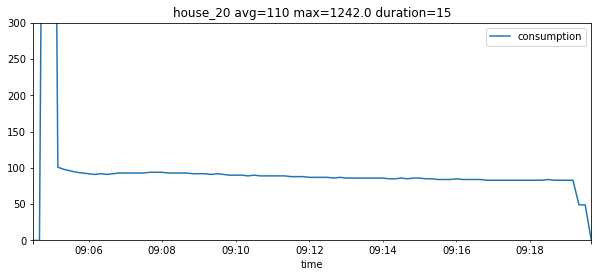

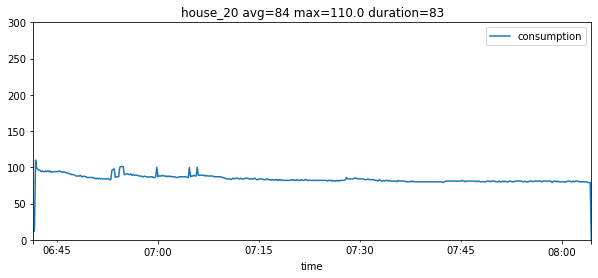

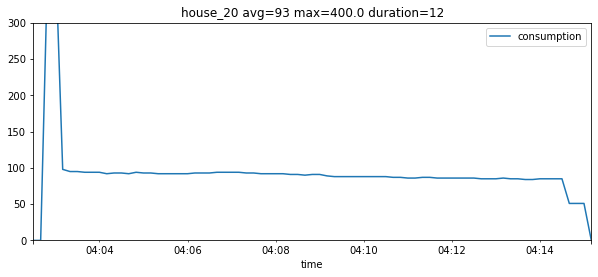

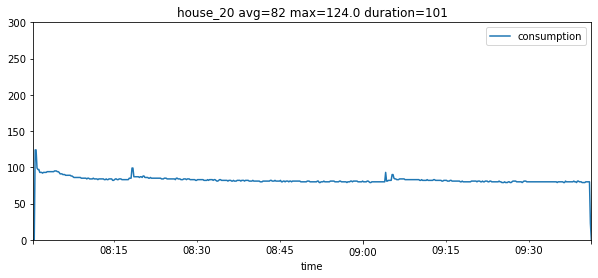

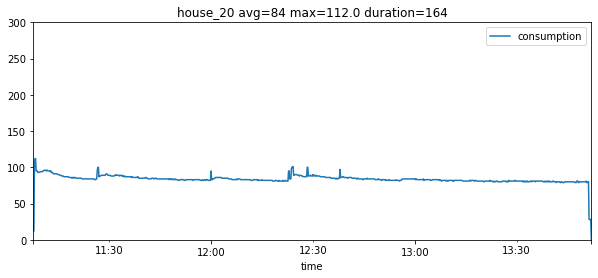

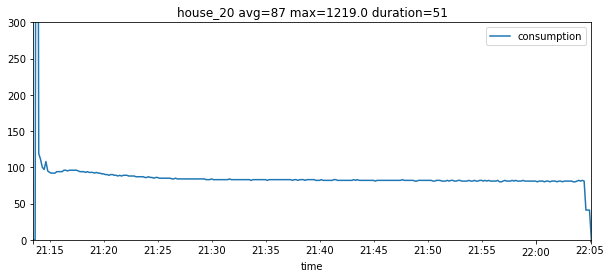

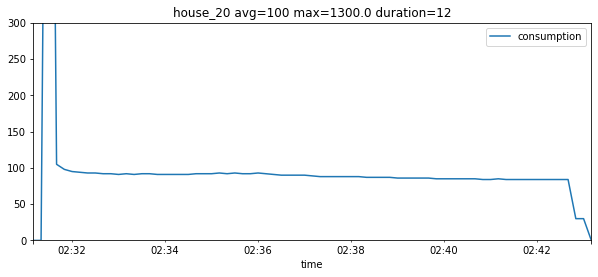

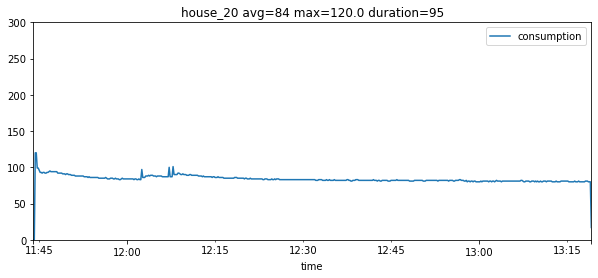

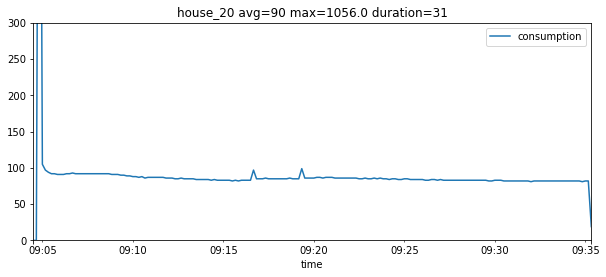

In [80]:
house=20
activations=random.sample(range(0, len(duration_anomolous_activations[house])),100)
df=Refit_fridges[house]
for activation in activations:
    beginning=duration_anomolous_activations[house][activation][0]
    end=duration_anomolous_activations[house][activation][1]
    avg=sum(df.consumption.iloc[beginning:end])/len(df.consumption.iloc[beginning:end])
    maximus=max(df.consumption.iloc[beginning:end])
    duration=int((end-beginning)/6)
    ax=df.iloc[beginning:end].plot(x="time",y=['consumption'], figsize=(10,4),title="house_"+str(house)+" avg="+str(round(avg))+" max="+str(maximus)+" duration="+str(duration))
    ax.set_ylim(0,300)

In [81]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_activation_type,((Refit_fridge_activations[i],duration_normal_activations[i],i) for i in duration_normal_activations.keys() ))

In [82]:
Refit_fridge_activation_type={}
for i in range(len(result)):
        Refit_fridge_activation_type[result[i][1]]=result[i][0]

In [85]:
for i in Refit_fridge_activation_type.keys():
    activations_to_csv(Refit_fridge_activations[i],Refit_fridge_activation_type[i],i)